**Repeated observations within units**

What is the impact of having a heirarchical model on the coefficients of other predictor variables.

 How to deal with repeated observations from the same patient?

In [1]:
import arviz as az
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit, logit
from scipy.optimize import curve_fit
import statsmodels.api as sm
import daft
from causalgraphicalmodels import CausalGraphicalModel
%matplotlib inline

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95  # sets default credible interval used by arviz

sns.set_context("talk")

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Questions

Given known amount of data (each with 1000 rows).

Intercept only model
- Each observation from a different patient
- The same observation from a smaller number of patients
    - Fixed prior
    - Adaptive prior


Intercept + one predictor
- Each observation from a different patient
- The same observation from a smaller number of patients
    - Fixed prior on intercept, fixed prior on slope
    - Adaptive prior on intercept, adaptive prior on slope
    - Adaptive prior on intercept, fixed prior on slope
    - Adaptive prior on intercept, adaptive prior on slope


Imagine there are unseen predictors. Then what's the impact?


# Data with only the intercept, no repeat observations

A ridiculous looking DAG.

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


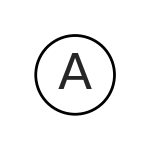

<IPython.core.display.Javascript object>

In [3]:
dag = CausalGraphicalModel(
    nodes=["A"],
    edges=[],
)
pgm = daft.PGM()
coordinates = {
    "A": (0, 1),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)

pgm.render()


## Identifying parameters for data generation

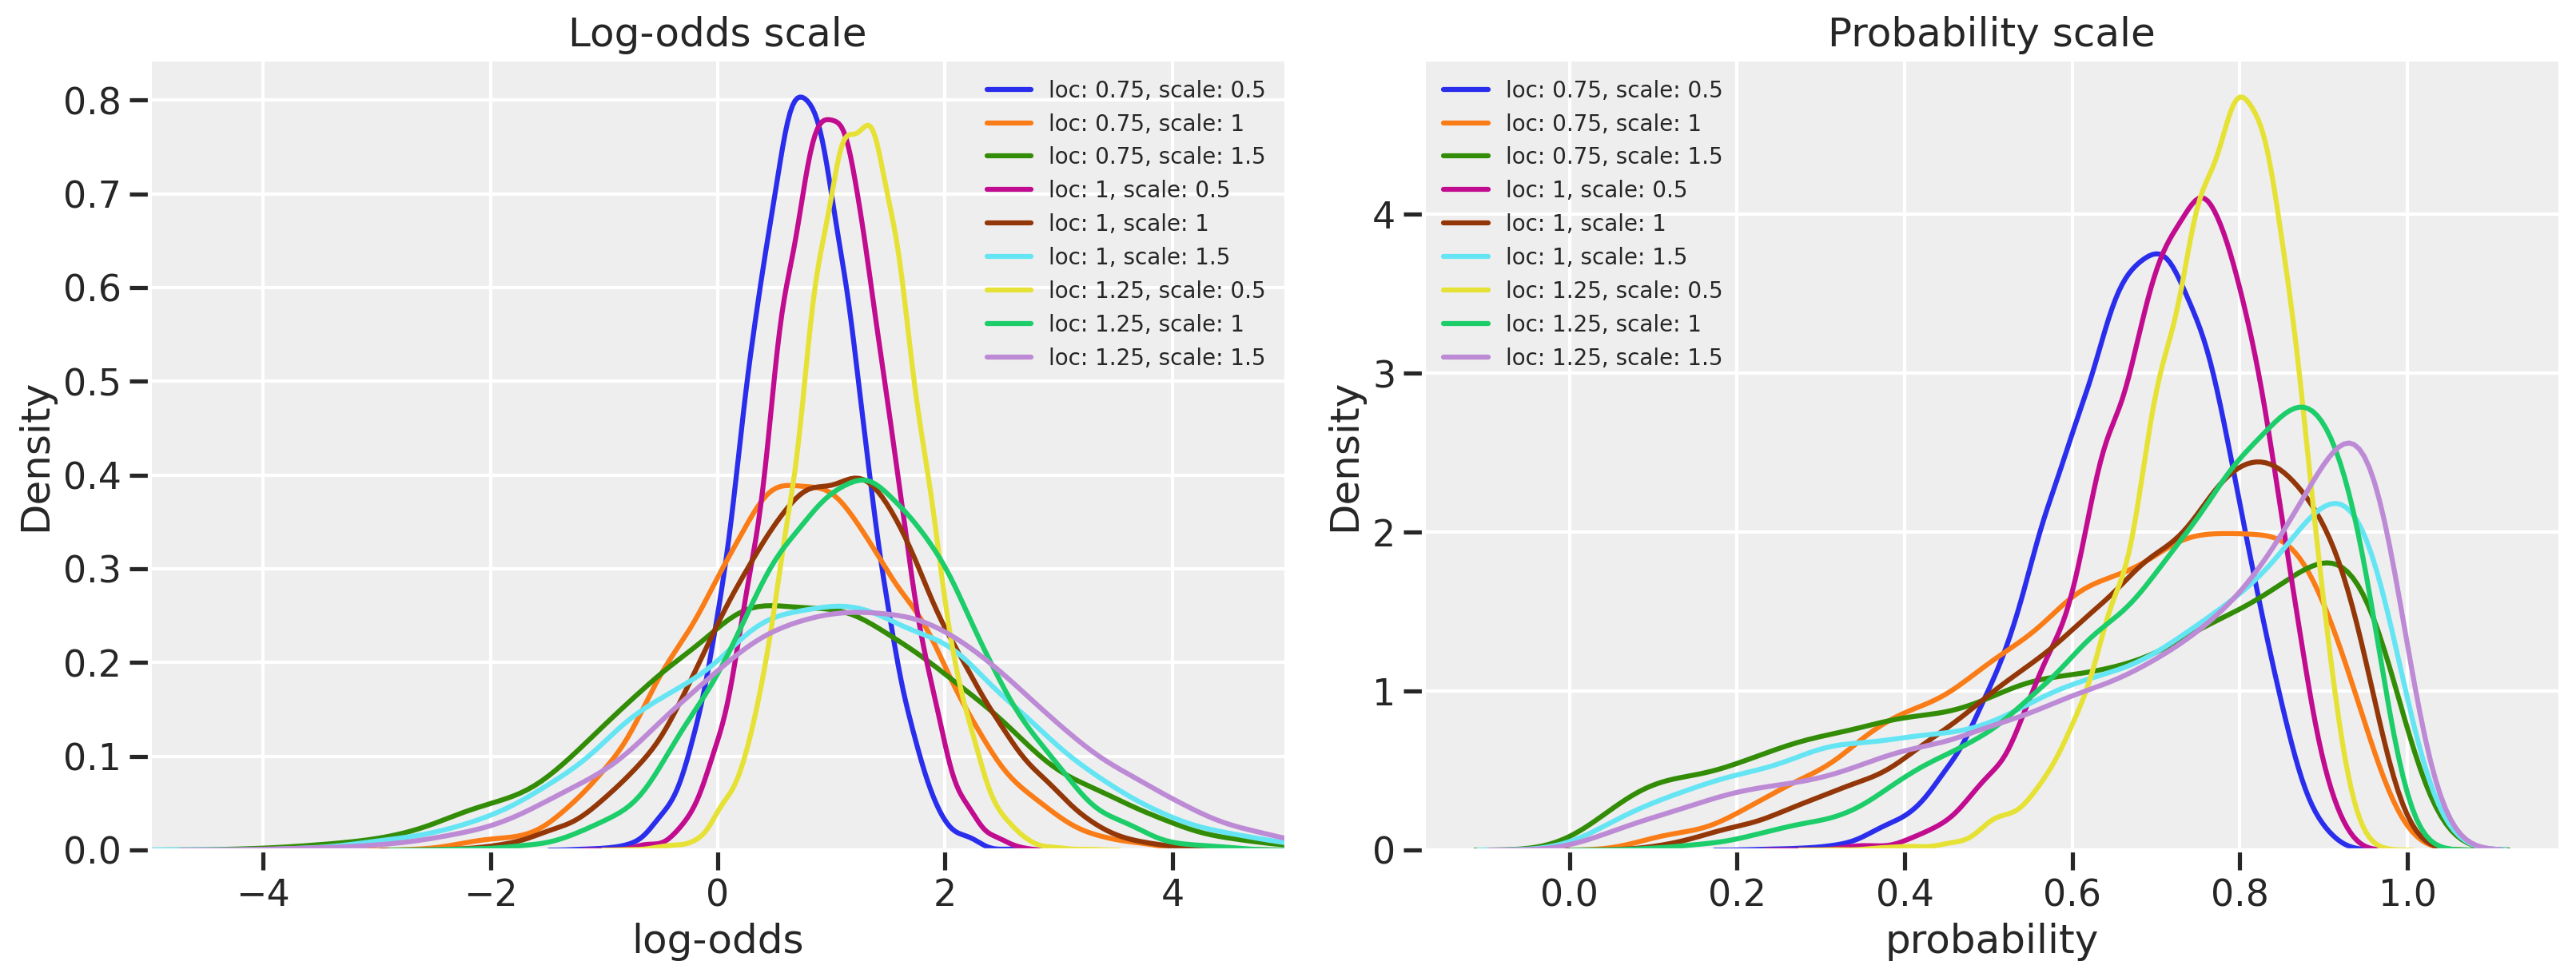

<IPython.core.display.Javascript object>

In [4]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
loc_params = [0.75, 1, 1.25]
scale_params = [0.5, 1, 1.5]

for loc_param in loc_params:
    for scale_param in scale_params:
        # log-odds scale
        log_odds_samples = stats.norm.rvs(
            loc=loc_param, scale=scale_param, size=10 ** 4
        )
        sns.kdeplot(
            log_odds_samples, ax=ax0, label=f"loc: {loc_param}, scale: {scale_param}"
        )

        # probability scale
        sns.kdeplot(
            expit(log_odds_samples),
            ax=ax1,
            label=f"loc: {loc_param}, scale: {scale_param}",
        )

ax0.set(xlim=[-5,5], xlabel='log-odds', title='Log-odds scale')
ax1.set(xlabel='probability', title='Probability scale')
ax0.legend(fontsize=10)
ax1.legend(fontsize=10)


What I am looking for are parameters where most patients make their appointments, yet there is still a spread in the distribution that accounts for a minority of patients that miss many appointments. From looking at the right plot, the parameters where the `loc` is at 0.75 and `scale` is at 1.5 looks like a decent distribution.

## Simulate each observation as coming from a different patient

- In all of the data we generate, each row will represent a different appointment.
- In this first example, each row is also a unique patient.

But most patients adhere so we'll set the population parameter for the log-odds to be high.

In [541]:
n_patients = 1000
patient_id = range(n_patients)
a_bar = 0.75  # population average log-odds of adherence
sd_pop = 1.5  # population SD on log-odds of adherence
alpha_i = stats.norm.rvs(
    loc=a_bar, scale=sd_pop, size=n_patients
)  # use population to get individuals
prob_adhere_i = expit(alpha_i)  # use probability of adherence to get individuals
appt_adhere_i = stats.bernoulli.rvs(p=prob_adhere_i)

df_Sim1 = pd.DataFrame(
    {
        "patient_id": patient_id,
        # "alpha":alpha_i,                     # commenting out because this normally wouldn't be in the EHR
        # "prob_adhere":prob_adhere_i,         # commenting out because this normally wouldn't be in the EHR
        "appt_adhere": appt_adhere_i,
    }
)

print(
    "Have a look at 10 randomly sampled values that would be observed from the dataframe"
)
df_Sim1.sample(10)


Have a look at 10 randomly sampled values that would be observed from the dataframe


patient_id  appt_adhere
23           23            1
610         610            1
463         463            1
390         390            1
605         605            0
224         224            1
498         498            1
118         118            0
252         252            0
14           14            0

<IPython.core.display.Javascript object>

In [548]:
print("Proportion of made appointments: ", df_Sim1['appt_adhere'].mean())
print("Log-odds of made appointments: ", logit(df_Sim1['appt_adhere'].mean()))

Proportion of made appointments:  0.619
Log-odds of made appointments:  0.48530589755789505


<IPython.core.display.Javascript object>

## Run inference

### Fixed prior, population intercept only

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha $$
$$ \alpha_j \sim \text{Normal}(0.5, 1.5) $$

We'll be slightly more conservative in our prior by shifting the mean a little bit closer to 50% probability that an appointment will be made. We'd expect the data to deal with this.

In [689]:
# population intercept only, no patient-specific intercept, fixed prior
with pm.Model() as mSim1Ia:

    # prior for patient_id
    a = pm.Normal("a", 0.5, 1.5)

    # link functionƒ˙
    p = pm.math.invlogit(a)

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim1["appt_adhere"])

    trace_mSim1Ia = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # prior predictive simulations
    prior_checks_mSim1Ia = pm.sample_prior_predictive(samples=100)

    # summaries and plotting
    df_summary_mSim1Ia = az.summary(trace_mSim1Ia)
    trace_mSim1Ia_df = pm.trace_to_dataframe(trace_mSim1Ia)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


<IPython.core.display.Javascript object>

In [547]:
df_summary_mSim1Ia

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a  0.488  0.066     0.357      0.608      0.001    0.001    2131.0  2131.0   

   ess_bulk  ess_tail  r_hat  
a    2146.0    2922.0    1.0

<IPython.core.display.Javascript object>

The data generating process itself has some stochasticity in terms of what will be the population average. Let's run the simulation five times and estimate.

In [550]:
df_summaries_Sim1 = list()
trace_posteriors_Sim1 = dict()

for i in range(5):
    alpha_i = stats.norm.rvs(
    loc=a_bar, scale=sd_pop, size=n_patients
    )
    prob_adhere_i = expit(alpha_i)
    appt_adhere_i = stats.bernoulli.rvs(p=prob_adhere_i)

    df_Sim1_test = pd.DataFrame(
        {
            "patient_id": patient_id,
            "appt_adhere": appt_adhere_i,
        }
    )

    with pm.Model() as mSim1Ia_test:
        a = pm.Normal("a", 0.5, 1.5)
        p = pm.math.invlogit(a)
        A = pm.Bernoulli("A", p=p, observed=df_Sim1_test["appt_adhere"])
        trace_mSim1Ia_test = pm.sample(draws=1000, return_inferencedata=False, progressbar=False)
        df_summary_mSim1Ia_test = az.summary(trace_mSim1Ia_test)
        trace_mSim1Ia_test_df = pm.trace_to_dataframe(trace_mSim1Ia_test)
        df_summaries_Sim1.append(df_summary_mSim1Ia_test)
        trace_posteriors_Sim1[i] = trace_mSim1Ia_test_df

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_

<IPython.core.display.Javascript object>

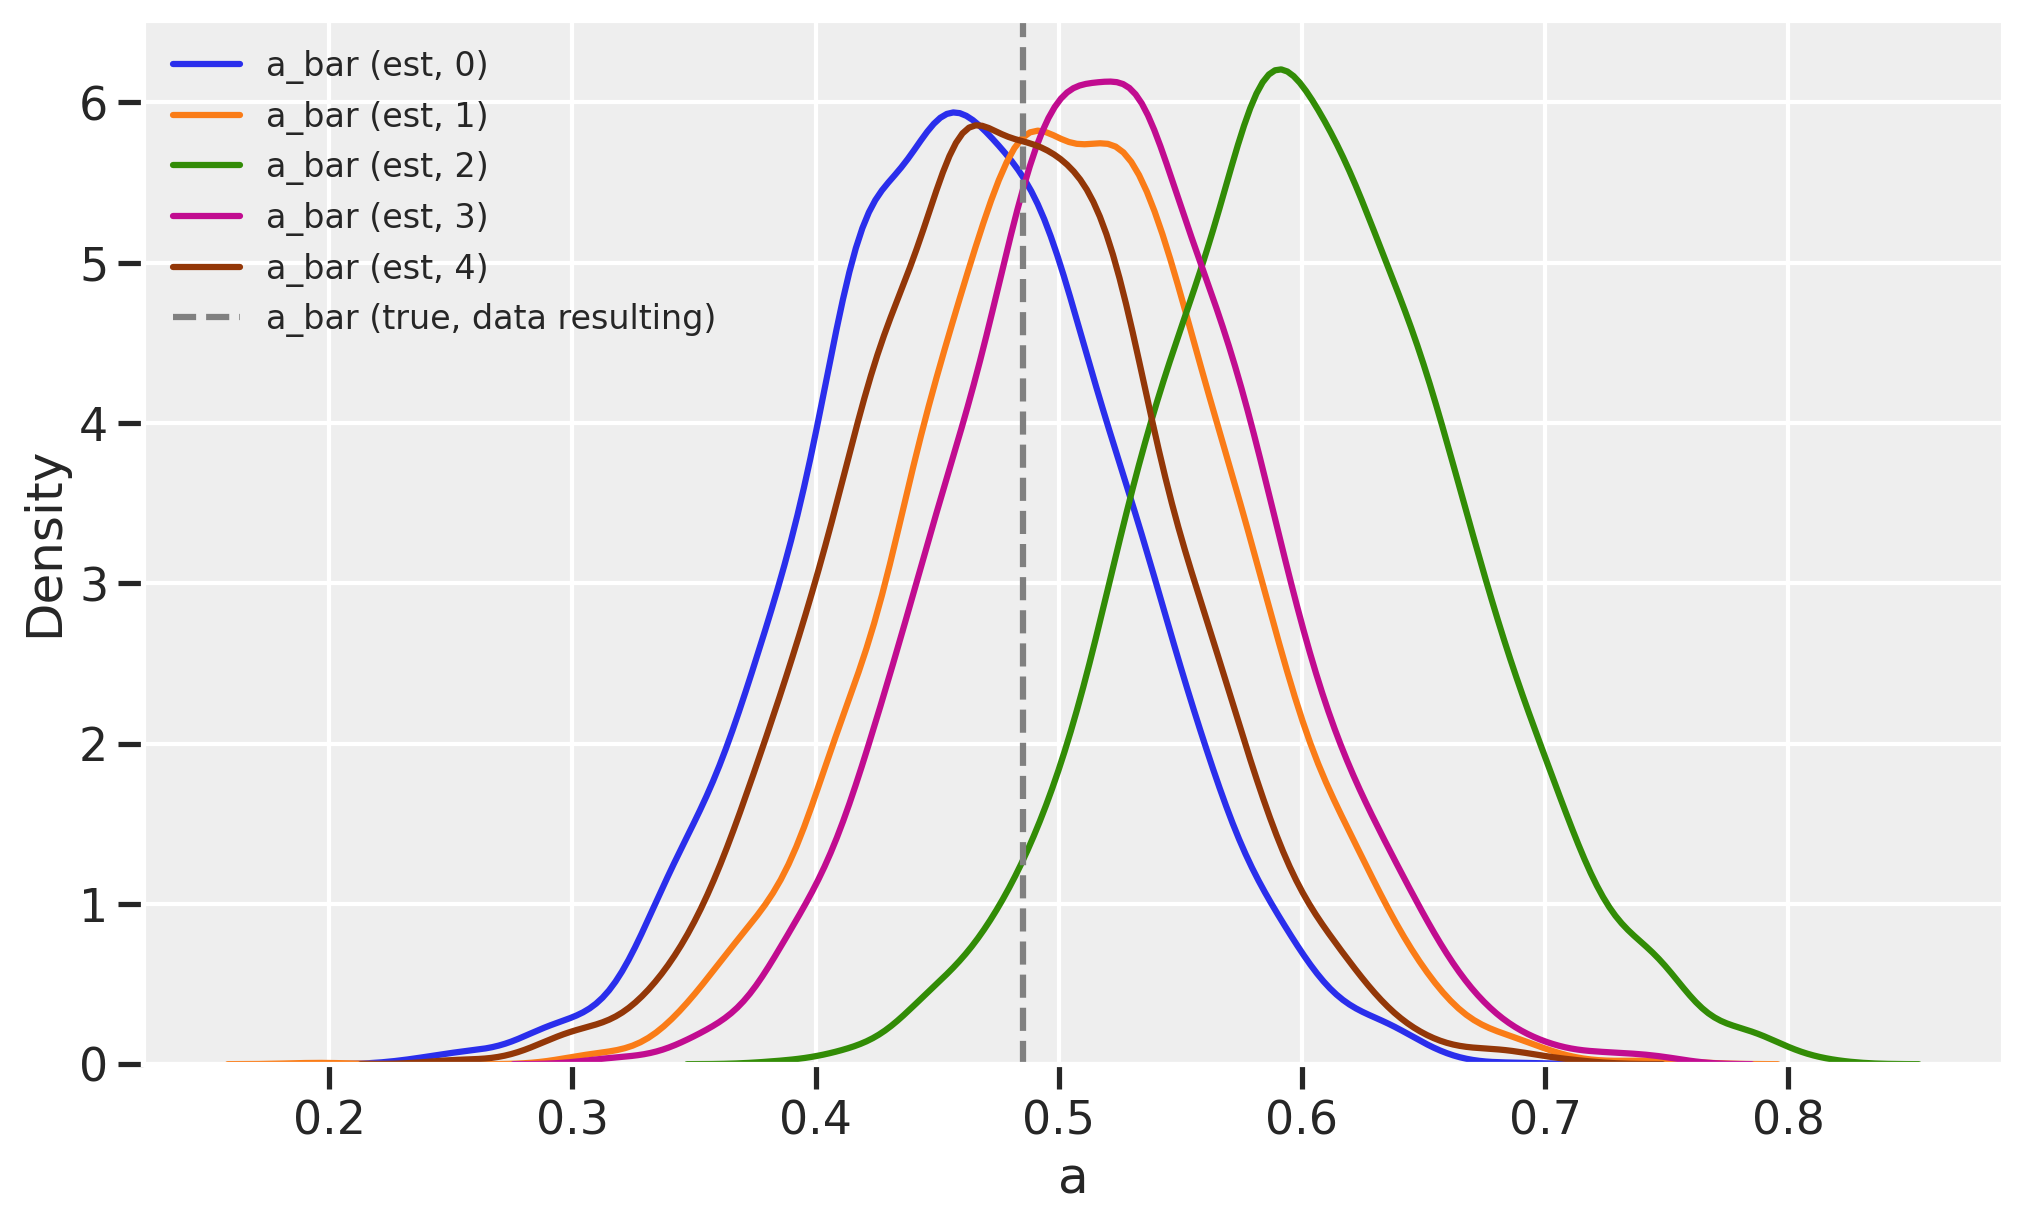

<IPython.core.display.Javascript object>

In [554]:
f, ax0 = plt.subplots(figsize=(10,6))
for i in range(5):
    sns.kdeplot(trace_posteriors_Sim1[i]['a'], label=f'a_bar (est, {i})')

# sns.kdeplot(alpha_i, c='red', label='alpha (individual)')
ax0.axvline(logit(df_Sim1['appt_adhere'].mean()), color='gray', linestyle='dashed', label='a_bar (true, data resulting)')
ax0.legend(fontsize=12)

### Fixed prior, with patient-specific intercept

Now we'll introduce the idea of patient-specific averages, but still using the same dataset where each patient only has one observation (appointment).

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} $$
$$ \alpha_j \sim \text{Normal}(0.5, 1.5) $$

In [555]:
n_patients = len(df_Sim1['patient_id'].unique())

# population intercept only, no patient-specific intercept, fixed prior
with pm.Model() as mSim1Ib:

    # prior for patient_id
    a = pm.Normal("a", 0.5, 1.5, shape=n_patients)

    # link functionƒ˙
    p = pm.math.invlogit(a)

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim1["appt_adhere"])

    trace_mSim1Ib = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # summaries and plotting
    df_summary_mSim1Ib = az.summary(trace_mSim1Ib)
    trace_mSim1Ib_df = pm.trace_to_dataframe(trace_mSim1Ib)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


<IPython.core.display.Javascript object>

In [556]:
df_summary_mSim1Ib

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
a[0]   -0.449  1.241    -2.989      1.916      0.016    0.025    5808.0   
a[1]   -0.400  1.276    -2.875      2.100      0.017    0.022    5458.0   
a[2]    1.154  1.307    -1.213      3.896      0.018    0.018    5132.0   
a[3]   -0.416  1.220    -2.787      1.911      0.017    0.024    4954.0   
a[4]   -0.437  1.202    -2.906      1.866      0.017    0.021    4770.0   
...       ...    ...       ...        ...        ...      ...       ...   
a[995]  1.176  1.310    -1.403      3.682      0.020    0.019    4366.0   
a[996]  1.155  1.274    -1.338      3.626      0.018    0.018    4773.0   
a[997]  1.142  1.287    -1.266      3.822      0.018    0.020    5184.0   
a[998] -0.460  1.280    -2.945      2.036      0.018    0.029    4923.0   
a[999]  1.105  1.260    -1.369      3.535      0.019    0.020    4253.0   

        ess_sd  ess_bulk  ess_tail  r_hat  
a[0]    1262.0    5819.0    2272.0   1.00  
a[1]    1620.0    5469.0    2477.0   1.00  
a[2]    2565.0    5140.0    2352.0   1.00  
a[3]    1313.0    4954.0    2223.0   1.00  
a[4]    1665.0    4762.0    2371.0   1.01  
...        ...       ...       ...    ...  
a[995]  2428.0    4398.0    2403.0   1.00  
a[996]  2526.0    4765.0    2455.0   1.00  
a[997]  2132.0    5143.0    2311.0   1.00  
a[998]   993.0    4902.0    2004.0   1.00  
a[999]  2063.0    4248.0    1903.0   1.00  

[1000 rows x 11 columns]

<IPython.core.display.Javascript object>

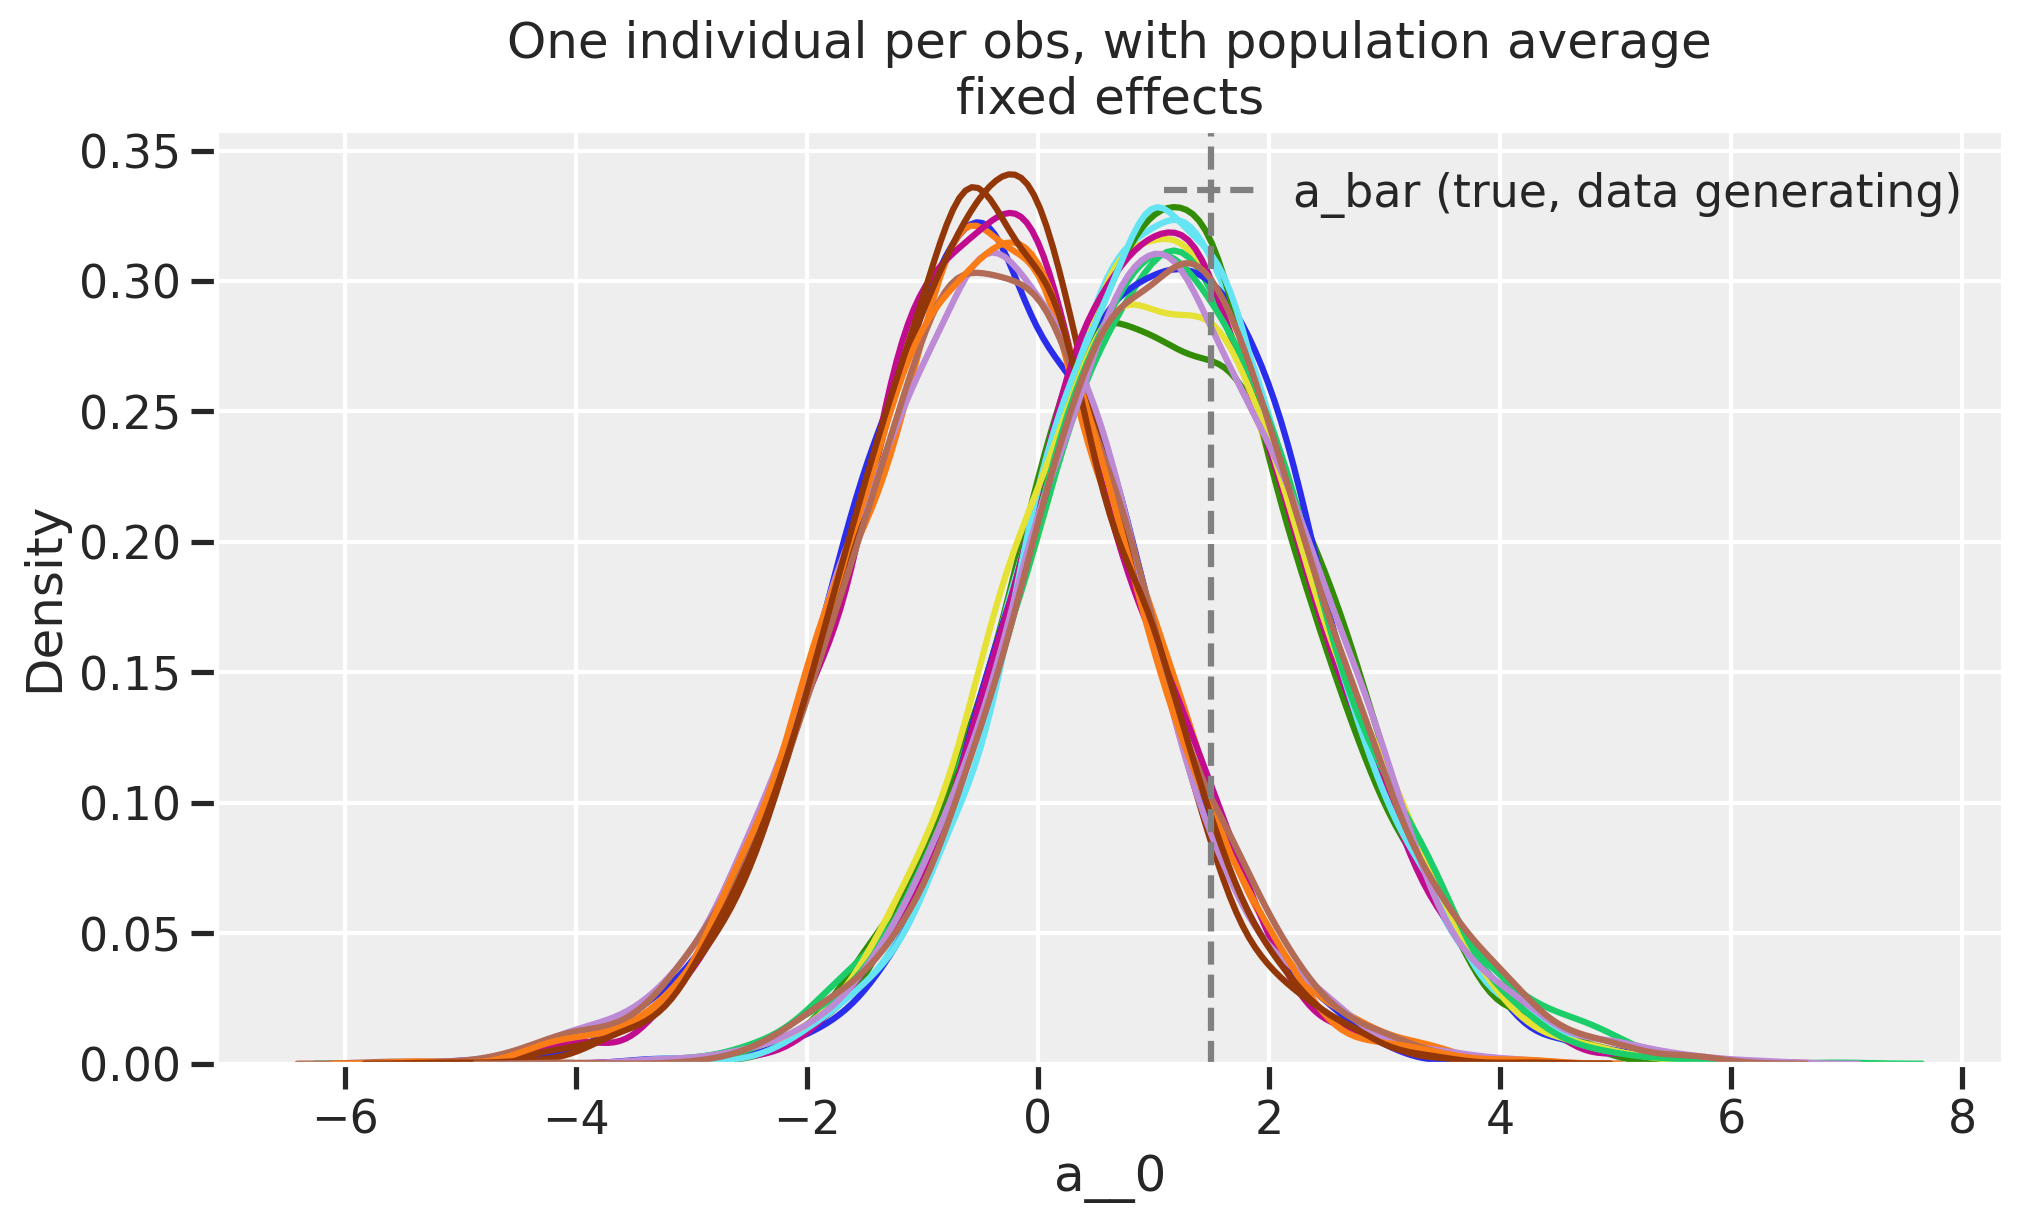

<IPython.core.display.Javascript object>

In [557]:
f, ax0 = plt.subplots(figsize=(10,6))
for i in range(20):
    sns.kdeplot(trace_mSim1Ib_df[f'a__{i}'])
 
ax0.axvline(1.5, color='gray', linestyle='dashed', label='a_bar (true, data generating)')
ax0.set(title='One individual per obs, with population average\nfixed effects')
ax0.legend()

We don't have a very interesting plot because each patient only has a single observation, either missed or not missed appointment. Therefore that's why we see two families of curves.

### Adaptive prior, with patient-specific intercept

The adaptive prior (partial pooling) approach in theory lets us get a population average back. Again, it won't be super interesting with only one observation per patient but also that it's the same across all patients. We can contrast this with the later dataset.

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) $$
$$ \sigma_{\alpha} \sim \text{Exp}(1) $$
$$ \bar{\alpha} \sim \text{Normal}(0.5, 1.5) $$

In [559]:
n_patients = len(df_Sim1['patient_id'].unique())

# patient-specific intercept, adaptive prior
with pm.Model() as mSim1Ic:

    # adaptive priors
    a_bar = pm.Normal("a_bar", 0.5, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    a = pm.Normal("a", a_bar, sigma_a, shape=n_patients)

    # link functionƒ˙
    p = pm.math.invlogit(a)

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim1["appt_adhere"])

    trace_mSim1Ic = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # summaries and plotting
    df_summary_mSim1Ic = az.summary(trace_mSim1Ic)
    trace_mSim1Ic_df = pm.trace_to_dataframe(trace_mSim1Ic)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma_a, a_bar]
INFO:pymc3:NUTS: [a, sigma_a, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.41632044288581105, but should be close to 0.8. Try to increase the number of tuning steps.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 106 divergences 

<IPython.core.display.Javascript object>

In [560]:
df_summary_mSim1Ic

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar    0.549  0.120     0.347      0.794      0.043    0.032       8.0   
a[0]     0.257  0.800    -1.619      1.692      0.164    0.118      24.0   
a[1]     0.177  0.778    -1.675      1.471      0.154    0.110      26.0   
a[2]     0.745  0.751    -0.659      2.356      0.141    0.117      29.0   
a[3]     0.291  0.753    -1.420      1.555      0.172    0.124      19.0   
...        ...    ...       ...        ...        ...      ...       ...   
a[996]   0.704  0.804    -0.611      2.537      0.170    0.122      22.0   
a[997]   0.694  0.800    -0.618      2.632      0.148    0.127      29.0   
a[998]   0.322  0.804    -1.518      1.664      0.183    0.131      19.0   
a[999]   0.728  0.837    -0.687      2.520      0.173    0.130      23.0   
sigma_a  0.639  0.528     0.147      1.878      0.238    0.180       5.0   

         ess_sd  ess_bulk  ess_tail  r_hat  
a_bar       8.0       8.0      26.0   1.51  
a[0]       24.0      29.0      27.0   1.23  
a[1]       26.0      32.0      29.0   1.21  
a[2]       21.0      50.0      26.0   1.20  
a[3]       19.0      32.0      26.0   1.23  
...         ...       ...       ...    ...  
a[996]     22.0      55.0      26.0   1.22  
a[997]     21.0      73.0      26.0   1.25  
a[998]     19.0      25.0      26.0   1.24  
a[999]     21.0      33.0      34.0   1.20  
sigma_a     5.0       5.0      25.0   2.32  

[1002 rows x 11 columns]

<IPython.core.display.Javascript object>

In [562]:
trace_mSim1Ic_df.head()

a_bar      a__0      a__1      a__2      a__3      a__4      a__5  \
0  0.640244  1.003245  0.100529  0.429749 -0.616213  0.293083  1.693105   
1  0.663095  0.855168 -0.548259  0.246577 -0.640301  1.613122  1.619554   
2  0.621324  1.229948 -0.173394  1.242739 -0.229204  0.843392  1.631582   
3  0.615710  0.660220  1.073024  0.791790  0.735611 -0.704696 -0.043801   
4  0.685761 -0.583137  0.334032  1.632242 -0.092819  0.622058 -0.059857   

       a__6      a__7      a__8  ...    a__991    a__992    a__993    a__994  \
0 -0.462210  1.745600  0.676749  ...  1.663947  1.575203  1.298608  0.818110   
1  1.138774  1.584470 -0.217698  ...  0.847897  2.130348  2.941174  0.558032   
2  1.692184  1.563801 -0.240288  ...  1.091490  1.530626  2.038320  1.325313   
3  0.768949  2.394191  0.360139  ...  3.146533  0.664945  0.465645  1.692229   
4 -0.014127  1.121989 -1.013007  ...  2.011912  1.740802  1.553329  1.488342   

     a__995    a__996    a__997    a__998    a__999   sigma_a  
0  1.662359  1.802362 -0.166499 -0.592226  1.299029  0.940301  
1  1.305998  2.790921  0.565844 -0.328496  0.712604  0.970878  
2  1.292687  1.570716 -0.484372  0.033975  0.627631  0.907866  
3 -0.853057  0.933083  0.764758  0.174441  0.971581  0.927942  
4  0.389247  1.945096 -0.199611  0.131869  0.747722  0.925589  

[5 rows x 1002 columns]

<IPython.core.display.Javascript object>

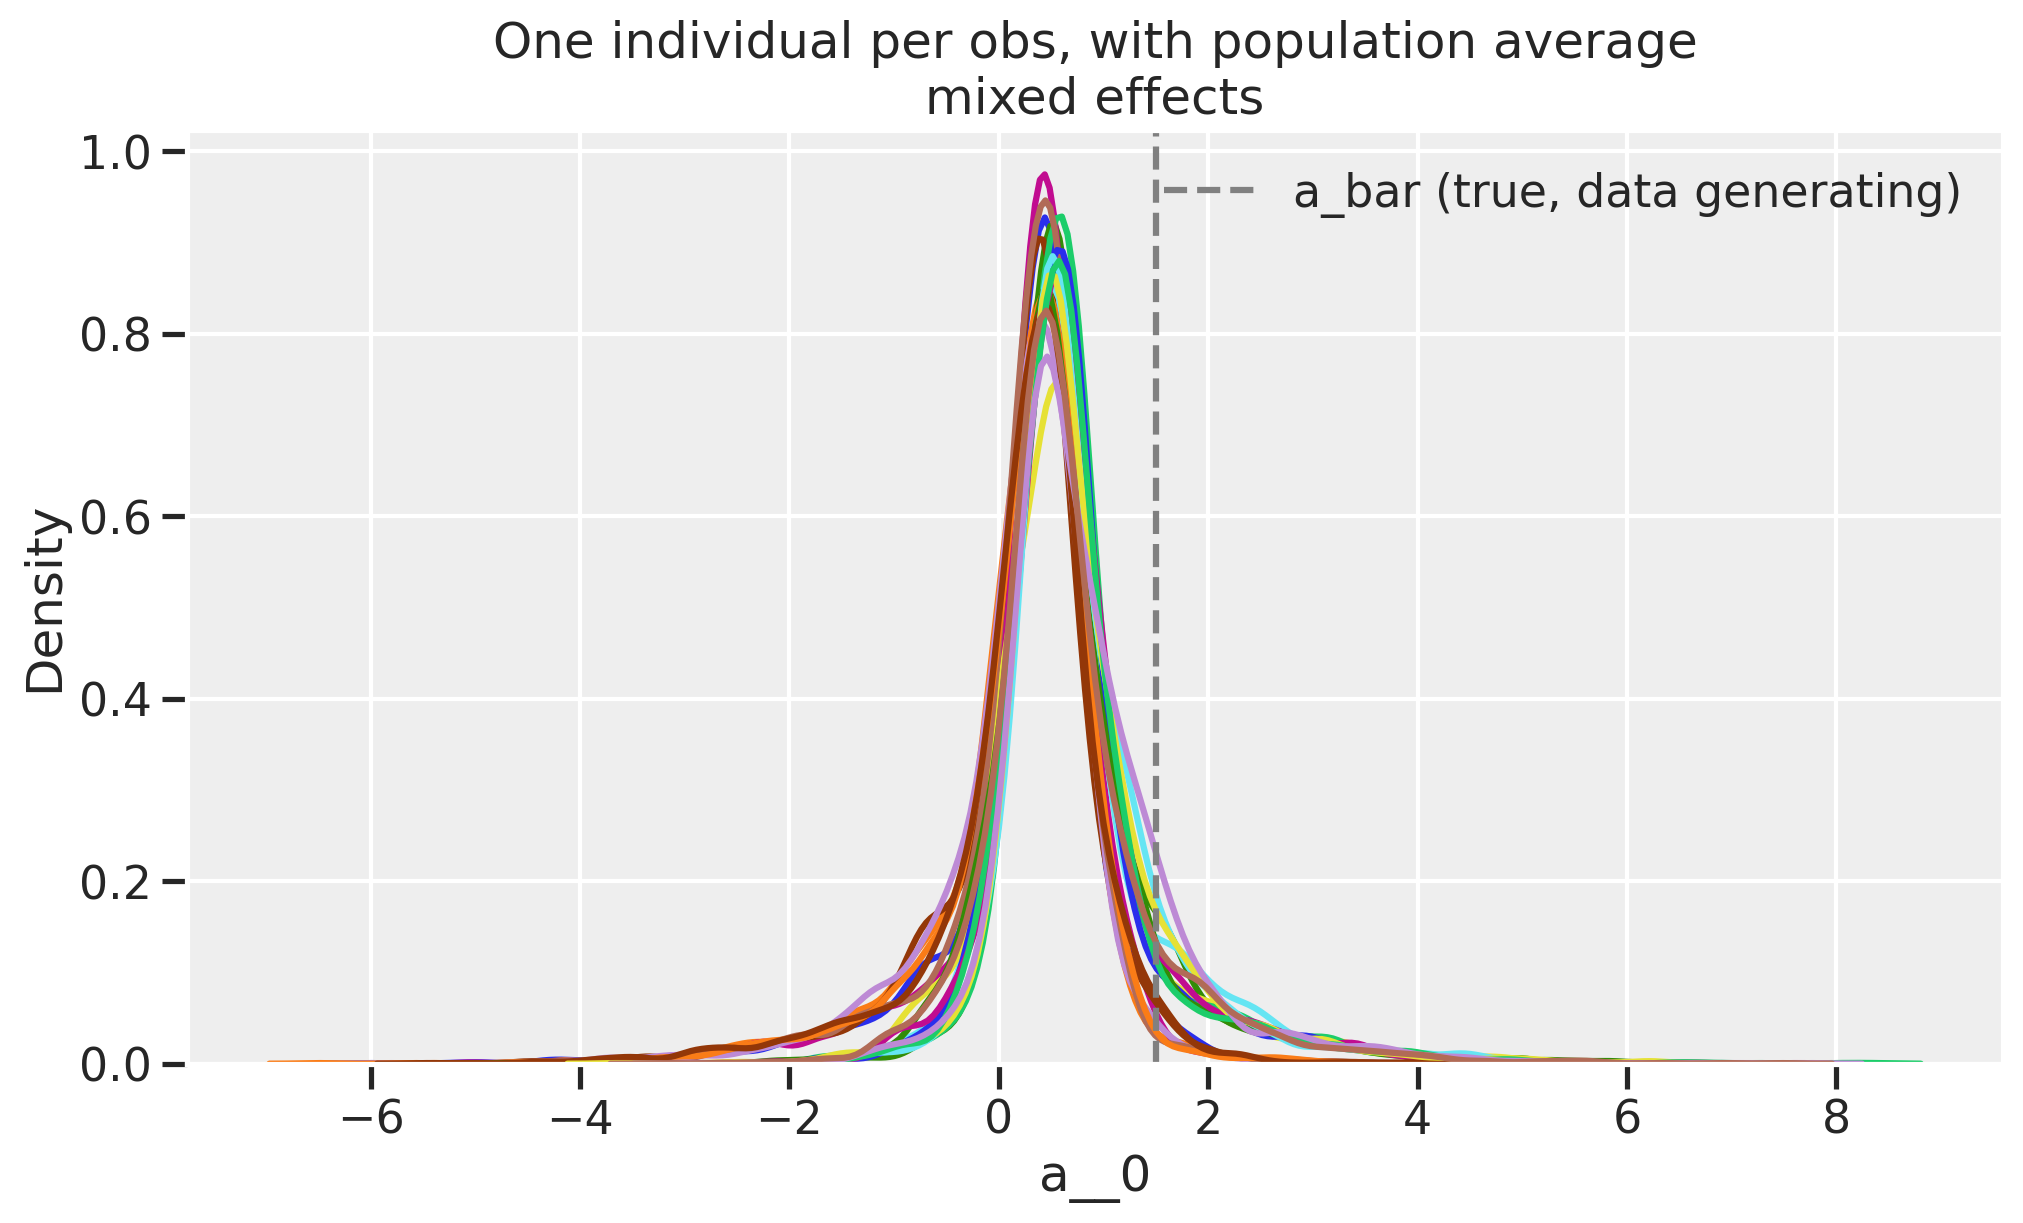

<IPython.core.display.Javascript object>

In [564]:
f, ax0 = plt.subplots(figsize=(10,6))
for i in range(20):
    sns.kdeplot(trace_mSim1Ic_df[f'a__{i}'])

# sns.kdeplot(trace_mSim1Ic_df[f'a_bar'], color='black', linewidth=5, label='a_bar (est)')
ax0.axvline(1.5, color='gray', linestyle='dashed', label='a_bar (true, data generating)')
ax0.set(title='One individual per obs, with population average\nmixed effects')
ax0.legend()

This is interesting now since we see partial pooling do its thing. We don't have two different distributions, but instead we basically see one. This is telling us that the model has little confidence that having only one observation, whether it's a 0 or 1, is not entirely meaningful. The posterior essentially pulled things towards the middle.

## Summary 1

In [566]:
df_summary_mSim1Ib.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0] -0.449  1.241    -2.989      1.916      0.016    0.025    5808.0  1262.0   
a[1] -0.400  1.276    -2.875      2.100      0.017    0.022    5458.0  1620.0   
a[2]  1.154  1.307    -1.213      3.896      0.018    0.018    5132.0  2565.0   
a[3] -0.416  1.220    -2.787      1.911      0.017    0.024    4954.0  1313.0   
a[4] -0.437  1.202    -2.906      1.866      0.017    0.021    4770.0  1665.0   

      ess_bulk  ess_tail  r_hat  
a[0]    5819.0    2272.0   1.00  
a[1]    5469.0    2477.0   1.00  
a[2]    5140.0    2352.0   1.00  
a[3]    4954.0    2223.0   1.00  
a[4]    4762.0    2371.0   1.01

<IPython.core.display.Javascript object>

In [565]:
df_summary_mSim1Ic.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar  0.549  0.120     0.347      0.794      0.043    0.032       8.0   
a[0]   0.257  0.800    -1.619      1.692      0.164    0.118      24.0   
a[1]   0.177  0.778    -1.675      1.471      0.154    0.110      26.0   
a[2]   0.745  0.751    -0.659      2.356      0.141    0.117      29.0   
a[3]   0.291  0.753    -1.420      1.555      0.172    0.124      19.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a_bar     8.0       8.0      26.0   1.51  
a[0]     24.0      29.0      27.0   1.23  
a[1]     26.0      32.0      29.0   1.21  
a[2]     21.0      50.0      26.0   1.20  
a[3]     19.0      32.0      26.0   1.23

<IPython.core.display.Javascript object>

In [568]:
df_summary_mSim1I_fixed_mixed = pd.merge(
    df_summary_mSim1Ib[['mean', 'sd']],
    df_summary_mSim1Ic[['mean', 'sd']],
    how='inner',
    left_index=True,
    right_index=True
)
df_summary_mSim1I_fixed_mixed.head()

mean_x   sd_x  mean_y   sd_y
a[0]  -0.449  1.241   0.257  0.800
a[1]  -0.400  1.276   0.177  0.778
a[2]   1.154  1.307   0.745  0.751
a[3]  -0.416  1.220   0.291  0.753
a[4]  -0.437  1.202   0.211  0.786

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'fixed effects'),
 Text(0, 0.5, 'mixed effects'),
 Text(0.5, 1.0, 'Fixed vs. Mixed effects standard deviation\nsized by n_obs')]

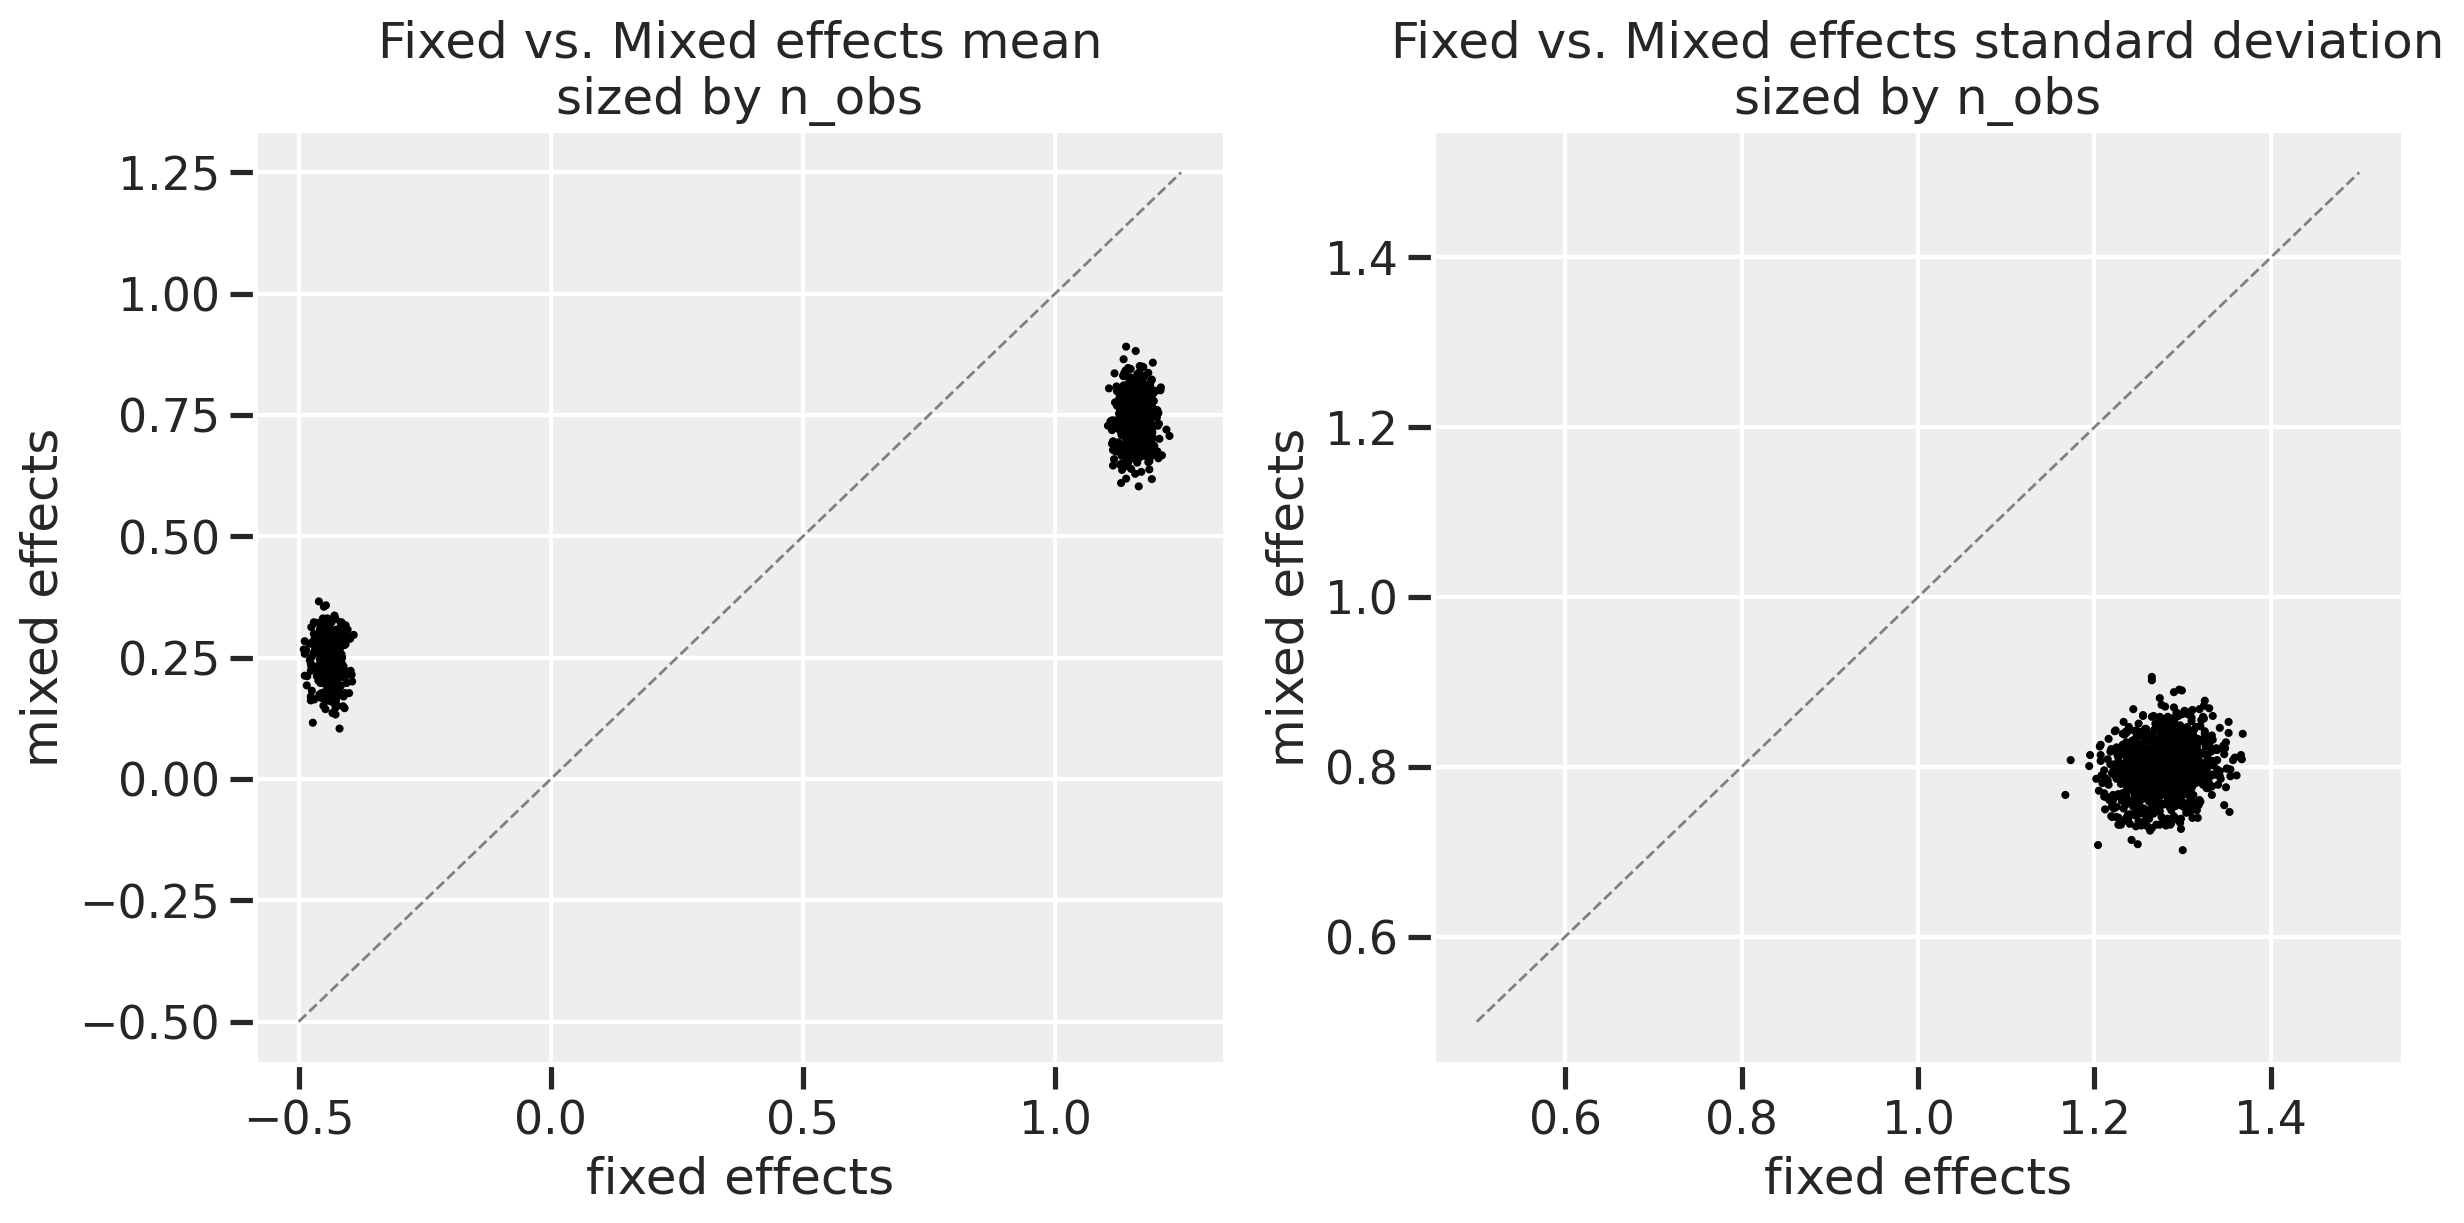

<IPython.core.display.Javascript object>

In [577]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.scatter(df_summary_mSim1I_fixed_mixed['mean_x'], df_summary_mSim1I_fixed_mixed['mean_y'], s=2, facecolors='none', edgecolors='k')
ax0.plot([-0.5, 1.25], [-0.5, 1.25], linestyle='dashed', linewidth=1, color='gray')
ax0.set(xlabel='fixed effects', ylabel='mixed effects', title='Fixed vs. Mixed effects mean\nsized by n_obs')

ax1.scatter(df_summary_mSim1I_fixed_mixed['sd_x'], df_summary_mSim1I_fixed_mixed['sd_y'], s=2, facecolors='none', edgecolors='k')
ax1.plot([0.5, 1.5], [0.5, 1.5], linestyle='dashed', linewidth=1, color='gray')
ax1.set(xlabel='fixed effects', ylabel='mixed effects', title='Fixed vs. Mixed effects standard deviation\nsized by n_obs')

# Data with only the intercept, with repeat observations

Distribute observations in a skewed distribution.

In [582]:
s_appt = pd.Series(stats.nbinom.rvs(n=1, p=0.075, size=1000))
s_appt.value_counts().sort_index().head()

0    69
1    69
2    69
3    63
4    55
dtype: int64

<IPython.core.display.Javascript object>

In [583]:
s_appt = s_appt.value_counts().reset_index()
s_appt['patient_id'] = pd.Categorical(s_appt['index']).codes
s_appt.rename({0:'n_appts'}, axis=1, inplace=True)
# s_appt.sort_values(by='patient_id')

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'Patient ID'), Text(0, 0.5, 'No. of appointments')]

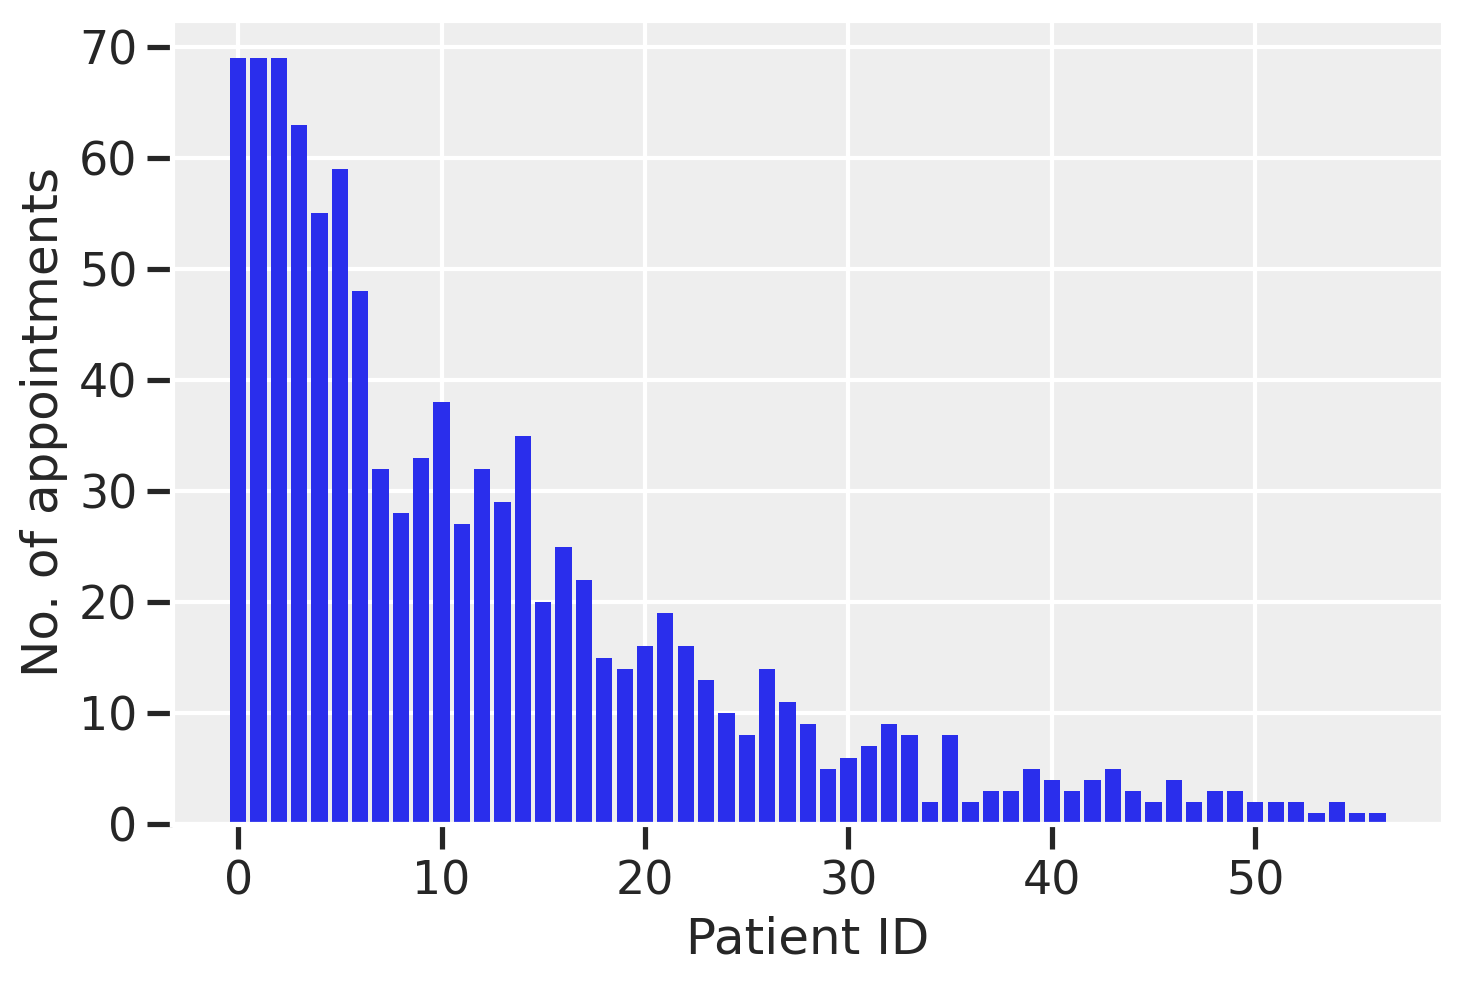

<IPython.core.display.Javascript object>

In [584]:
f, ax0 = plt.subplots()
ax0.bar(s_appt['patient_id'], s_appt['n_appts'])
ax0.set(xlabel='Patient ID', ylabel='No. of appointments')

We'll use the same population parameter as in the above generated data.

In [586]:
patient_id = sum([[i] * j for i, j in zip(s_appt['patient_id'], s_appt['n_appts'])], [])     # list comprehension and using sum as an easy way to flatten the list
appt_adhere = list()

a_bar = 0.75  # population average log-odds of adherence
sd_pop = 1.5  # population SD on log-odds of adherence
for pid, n in zip(s_appt['patient_id'], s_appt['n_appts']):
    alpha_i = stats.norm.rvs(
        loc=a_bar, scale=sd_pop, size=n
    )  # use population to get individuals
    prob_adhere_i = expit(alpha_i)  # use probability of adherence to get individuals
    appt_adhere_i = stats.bernoulli.rvs(p=prob_adhere_i)
    # print(pid, n)
    if type(appt_adhere_i) is int:
        appt_adhere_i = [appt_adhere_i]
    else:
        appt_adhere_i = list(appt_adhere_i)
    appt_adhere += appt_adhere_i

df_Sim2 = pd.DataFrame(
    {
        "patient_id": patient_id,
        # "alpha":alpha_i,                     # commenting out because this normally wouldn't be in the EHR
        # "prob_adhere":prob_adhere_i,         # commenting out because this normally wouldn't be in the EHR
        "appt_adhere": appt_adhere,
    }
)

print(
    "Have a look at 10 randomly sampled values that would be observed from the dataframe"
)
df_Sim2.sample(10)


Have a look at 10 randomly sampled values that would be observed from the dataframe


patient_id  appt_adhere
263           3            0
983          54            0
597           7            0
977          48            1
935          30            1
54            0            1
127           2            1
811          18            0
632           8            0
799          20            1

<IPython.core.display.Javascript object>

In [587]:
print("prop. adhere, all appointments: ", df_Sim2['appt_adhere'].mean())
print(f"log-odds, all appointments: {logit(df_Sim2['appt_adhere'].mean()):0.3f}")

prop. adhere, all appointments:  0.625
log-odds, all appointments: 0.511


<IPython.core.display.Javascript object>

## Run inference

### Fixed prior, population intercept only

In this first model, we're deliberately ignoring any patient-specific patterns. Alpha will represent the average log-odds of adherence across all appointments, regardless of patient.

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha $$
$$ \alpha_j \sim \text{Normal}(0.5, 1.5) $$


In [595]:
# population intercept only, no patient-specific intercept, fixed prior
with pm.Model() as mSim2Ia:

    # prior for patient_id
    a = pm.Normal("a", 0.5, 1.5)

    # link functionƒ˙
    p = pm.math.invlogit(a)

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim2["appt_adhere"])

    trace_mSim2Ia = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # summaries and plotting
    df_summary_mSim2Ia = az.summary(trace_mSim2Ia)
    trace_mSim2Ia_df = pm.trace_to_dataframe(trace_mSim2Ia)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [596]:
df_summary_mSim2Ia

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a  0.51  0.066     0.385      0.637      0.002    0.001    1802.0  1792.0   

   ess_bulk  ess_tail  r_hat  
a    1818.0    2755.0    1.0

<IPython.core.display.Javascript object>

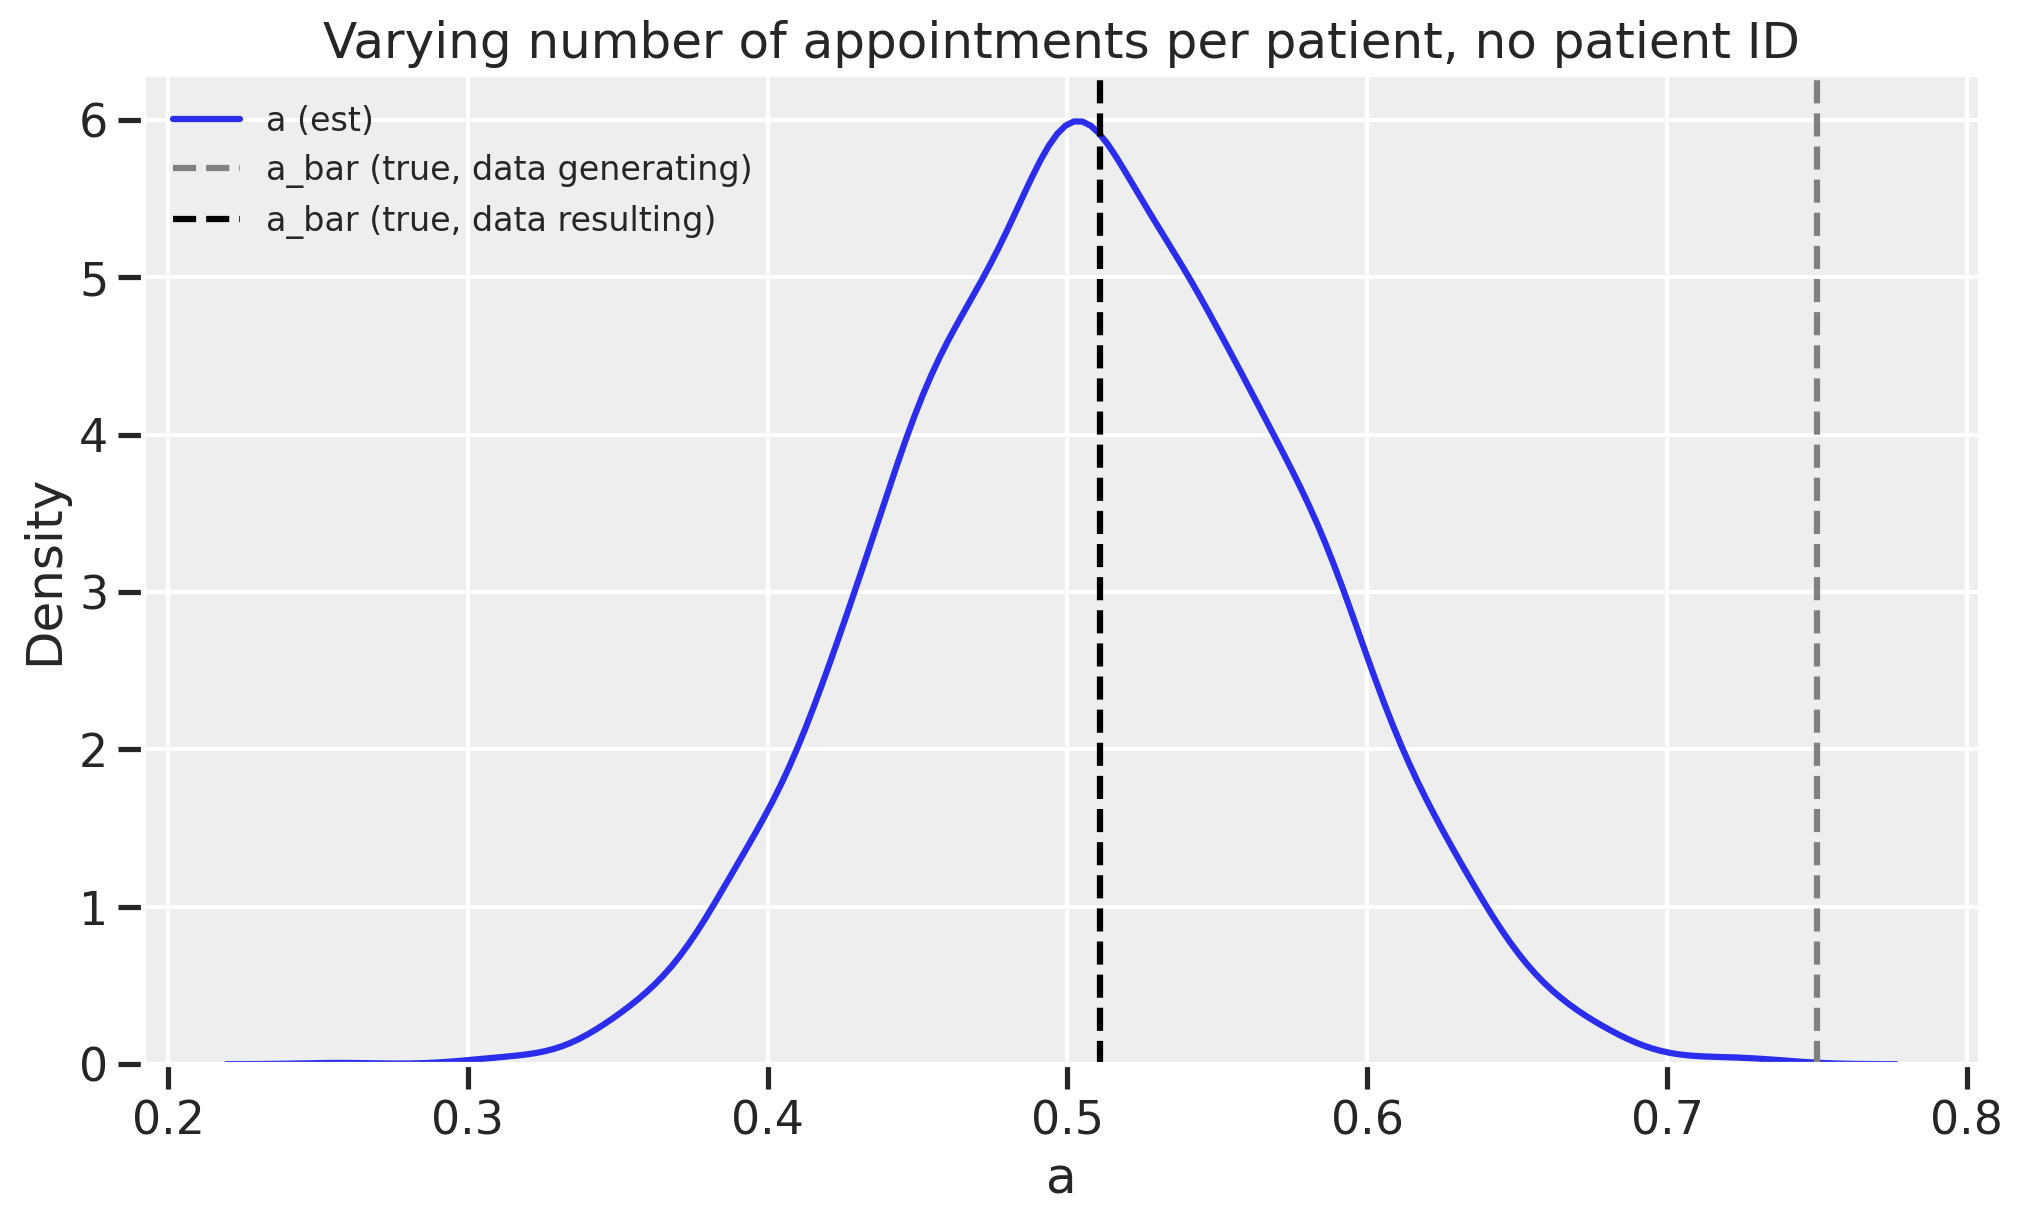

<IPython.core.display.Javascript object>

In [597]:
f, ax0 = plt.subplots(figsize=(10,6))
sns.kdeplot(trace_mSim2Ia_df[f'a'], label='a (est)')

ax0.axvline(0.75, color='gray', linestyle='dashed', label='a_bar (true, data generating)')
ax0.axvline(logit(df_Sim2['appt_adhere'].mean()), color='black', linestyle='dashed', label='a_bar (true, data resulting)')
ax0.set(title='Varying number of appointments per patient, no patient ID')
ax0.legend(fontsize=12)

### Fixed prior, with patient-specific intercept

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} $$
$$ \alpha_j \sim \text{Normal}(0.5, 1.5) $$

In [598]:
n_patients = len(df_Sim2['patient_id'].unique())

# population intercept only, no patient-specific intercept, fixed prior
with pm.Model() as mSim2Ib:

    # prior for patient_id
    a = pm.Normal("a", 0.5, 1.5, shape=n_patients)

    # link functionƒ˙
    p = pm.math.invlogit(a[df_Sim2['patient_id']])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim2["appt_adhere"])

    trace_mSim2Ib = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # summaries and plotting
    df_summary_mSim2Ib = az.summary(trace_mSim2Ib)
    trace_mSim2Ib_df = pm.trace_to_dataframe(trace_mSim2Ib)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


<IPython.core.display.Javascript object>

In [600]:
df_summary_mSim2Ib.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0]  0.699  0.252     0.231      1.203      0.003    0.002    9584.0  6989.0   
a[1]  0.634  0.253     0.117      1.110      0.003    0.002    8929.0  6087.0   
a[2]  0.275  0.238    -0.204      0.733      0.002    0.003    9473.0  3596.0   
a[3]  0.627  0.260     0.128      1.161      0.002    0.002   12236.0  7174.0   
a[4]  0.975  0.296     0.385      1.523      0.003    0.003    8147.0  6566.0   

      ess_bulk  ess_tail  r_hat  
a[0]    9559.0    2877.0    1.0  
a[1]    8958.0    2741.0    1.0  
a[2]    9497.0    3009.0    1.0  
a[3]   12328.0    2825.0    1.0  
a[4]    8173.0    2779.0    1.0

<IPython.core.display.Javascript object>

In [605]:
df_summary_mSim2Ib['pid'] = df_summary_mSim2Ib.index
df_summary_mSim2Ib['pid'] = df_summary_mSim2Ib['pid'].str.split('a\[', expand=True)[1].str.strip('\]')
s_appt['patient_id_s'] = s_appt['patient_id'].astype('str')

<IPython.core.display.Javascript object>

In [606]:
df_summary_mSim2Ib = pd.merge(
        df_summary_mSim2Ib.reset_index(),
        s_appt[['n_appts','patient_id_s']],
        how='left',
        left_on='pid',
        right_on='patient_id_s'
    )

df_summary_mSim2Ib.head()

index   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
0  a[0]  0.699  0.252     0.231      1.203      0.003    0.002    9584.0   
1  a[1]  0.634  0.253     0.117      1.110      0.003    0.002    8929.0   
2  a[2]  0.275  0.238    -0.204      0.733      0.002    0.003    9473.0   
3  a[3]  0.627  0.260     0.128      1.161      0.002    0.002   12236.0   
4  a[4]  0.975  0.296     0.385      1.523      0.003    0.003    8147.0   

   ess_sd  ess_bulk  ess_tail  r_hat pid  n_appts patient_id_s  
0  6989.0    9559.0    2877.0    1.0   0       69            0  
1  6087.0    8958.0    2741.0    1.0   1       69            1  
2  3596.0    9497.0    3009.0    1.0   2       69            2  
3  7174.0   12328.0    2825.0    1.0   3       63            3  
4  6566.0    8173.0    2779.0    1.0   4       55            4

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'n_appts'),
 Text(0, 0.5, 'SD of estimate'),
 Text(0.5, 1.0, 'Sample size and standard deviation\nof estimate')]

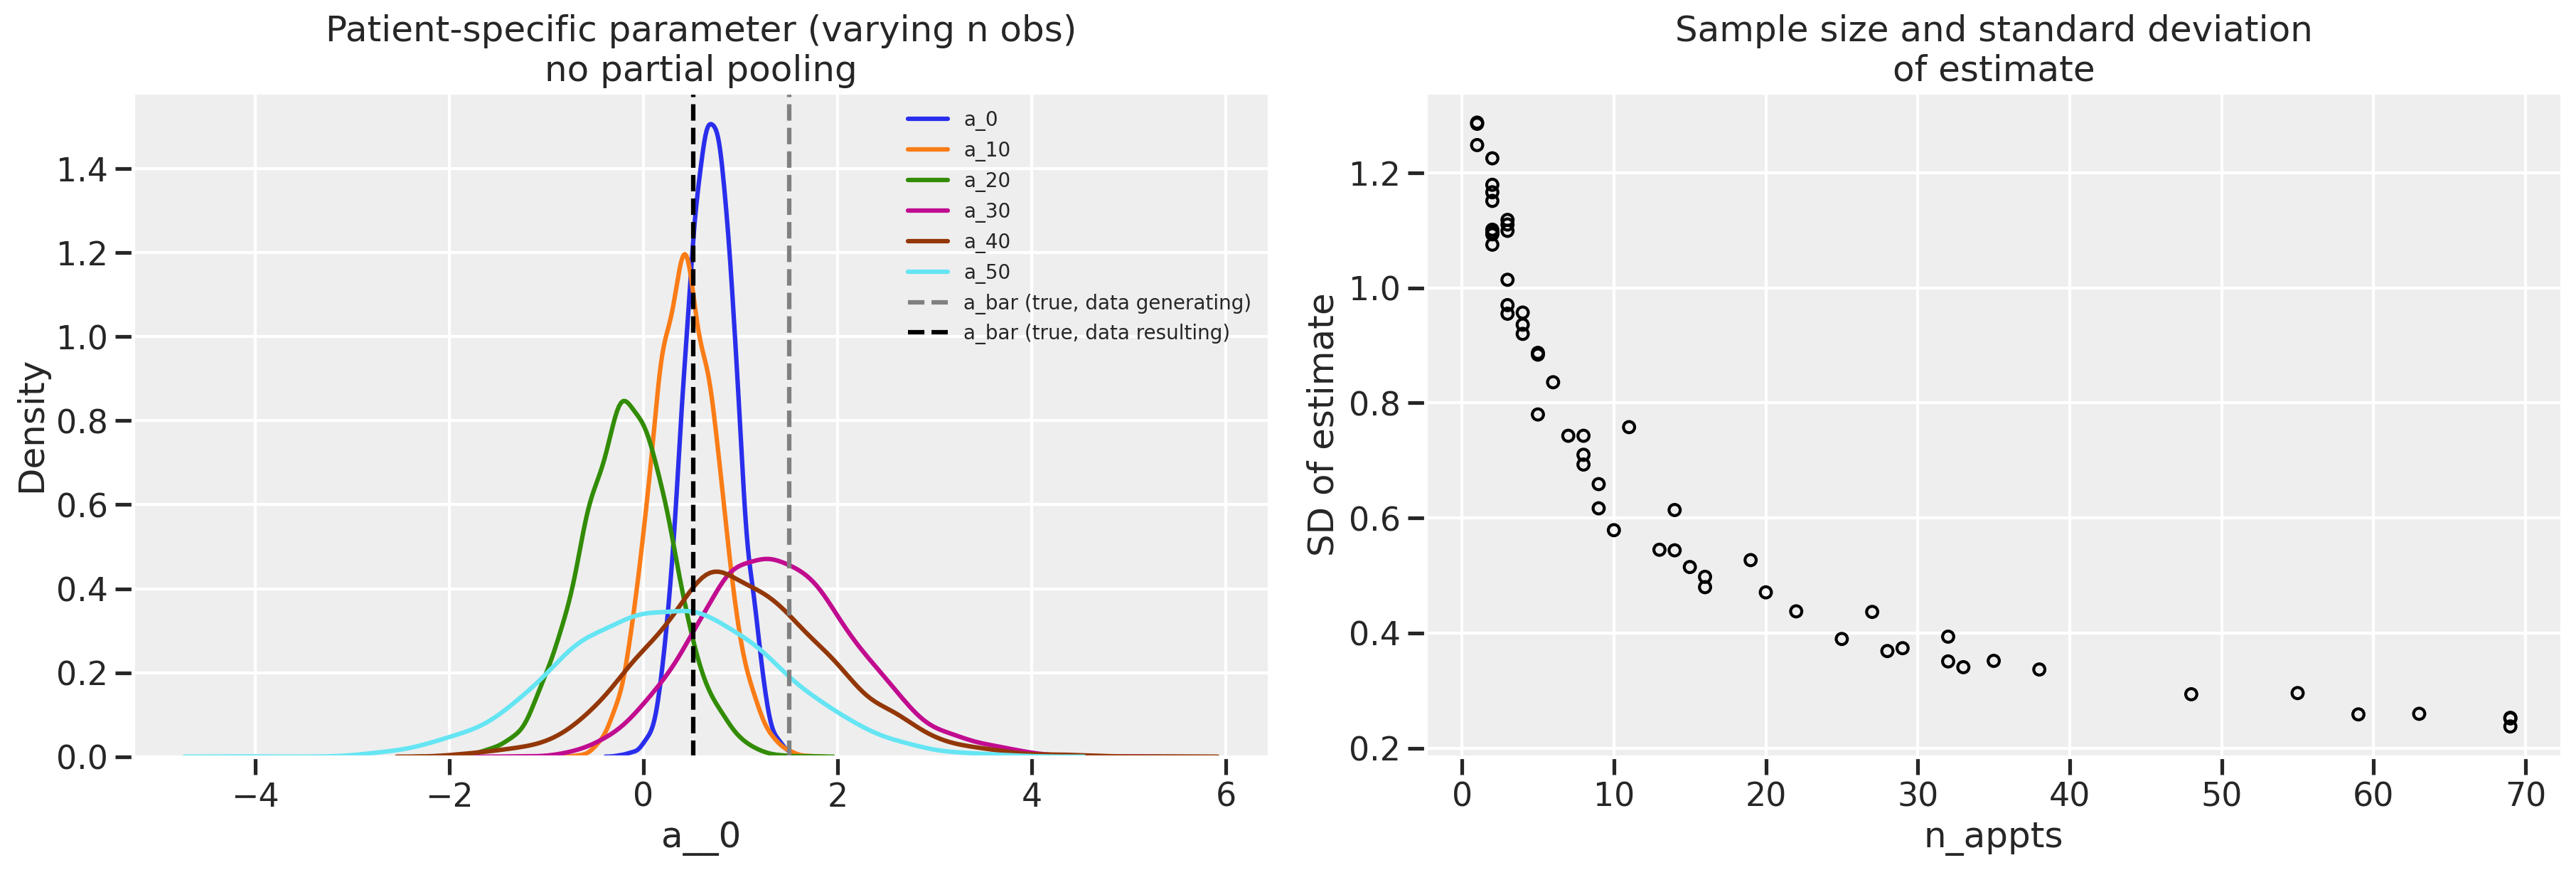

<IPython.core.display.Javascript object>

In [677]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(18,6))

# First plot
for i in range(0, 60, 10):
    sns.kdeplot(trace_mSim2Ib_df[f'a__{i}'], label=f'a_{i}', ax=ax0)
ax0.axvline(1.5, color='gray', linestyle='dashed', label='a_bar (true, data generating)')
ax0.axvline(logit(df_Sim2['appt_adhere'].mean()), color='black', linestyle='dashed', label='a_bar (true, data resulting)')

ax0.set(title='Patient-specific parameter (varying n obs)\nno partial pooling')
ax0.legend(fontsize=10)

# Second plot
ax1.scatter(df_summary_mSim2Ib['n_appts'], df_summary_mSim2Ib['sd'], s=2**5, facecolors='none', edgecolors='k')
ax1.set(xlabel='n_appts', ylabel='SD of estimate', title='Sample size and standard deviation\nof estimate')

### Adaptive prior, with patient-specific intercept

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) $$
$$ \sigma_{\alpha} \sim \text{Exp}(1) $$
$$ \bar{\alpha} \sim \text{Normal}(0.5, 1.5) $$

In [616]:
# patient-specific intercept, adaptive prior
with pm.Model() as mSim2Ic:

    # adaptive priors
    a_bar = pm.Normal("a_bar", 0.5, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    a = pm.Normal("a", a_bar, sigma_a, shape=n_patients)

    # link functionƒ˙
    p = pm.math.invlogit(a[df_Sim2['patient_id']])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim2["appt_adhere"])

    trace_mSim2Ic = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # summaries and plotting
    df_summary_mSim2Ic = az.summary(trace_mSim2Ic)
    trace_mSim2Ic_df = pm.trace_to_dataframe(trace_mSim2Ic)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma_a, a_bar]
INFO:pymc3:NUTS: [a, sigma_a, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6215764422155067, but sho

<IPython.core.display.Javascript object>

In [629]:
df_summary_mSim2Ic.head()

index   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
0  a_bar  0.517  0.069     0.378      0.653      0.005    0.003     212.0   
1   a[0]  0.567  0.142     0.288      0.865      0.006    0.005     517.0   
2   a[1]  0.548  0.146     0.262      0.849      0.007    0.005     475.0   
3   a[2]  0.448  0.148     0.131      0.711      0.010    0.007     232.0   
4   a[3]  0.550  0.145     0.245      0.841      0.004    0.003    1145.0   

   ess_sd  ess_bulk  ess_tail  r_hat   pid  n_appts patient_id_s  
0   212.0     204.0     595.0   1.02  None      NaN          NaN  
1   456.0     492.0     823.0   1.03     0     69.0            0  
2   420.0     429.0    1041.0   1.02     1     69.0            1  
3   232.0     278.0     935.0   1.02     2     69.0            2  
4   965.0     991.0    1303.0   1.02     3     63.0            3

<IPython.core.display.Javascript object>

I should try a non-centered paramaterization to improve sampling.

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} $$
$$ \alpha_j = \bar{\alpha} + z \times \sigma_{\alpha} $$
$$ z \sim \text{Normal}(0,1) $$
$$ \sigma_{\alpha} \sim \text{Exp}(1) $$
$$ \bar{\alpha} \sim \text{Normal}(0.5, 1.5) $$

In [627]:
# patient-specific intercept, adaptive prior, non-centered paramaterization
with pm.Model() as mSim2Id:

    # adaptive priors
    a_bar = pm.Normal("a_bar", 0.5, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1)

    z = pm.Normal("z", 0, 1, shape=n_patients)

    # prior for patient_id deterministic
    a = pm.Deterministic("a", a_bar + z*sigma_a)

    # link functionƒ˙
    p = pm.math.invlogit(a[df_Sim2['patient_id']])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim2["appt_adhere"])

    trace_mSim2Id = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # summaries and plotting
    df_summary_mSim2Id = az.summary(trace_mSim2Id)
    trace_mSim2Id_df = pm.trace_to_dataframe(trace_mSim2Id)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma_a, a_bar]
INFO:pymc3:NUTS: [z, sigma_a, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:

<IPython.core.display.Javascript object>

In [636]:
df_summary_mSim2Ic.loc[df_summary_mSim2Ic['index'].str.contains('a\['), 'r_hat'].value_counts()

1.02    38
1.01    12
1.03     7
Name: r_hat, dtype: int64

<IPython.core.display.Javascript object>

In [635]:
df_summary_mSim2Id.loc[df_summary_mSim2Id.index.str.contains('a\['), 'r_hat'].value_counts()

1.00    53
1.01     4
Name: r_hat, dtype: int64

<IPython.core.display.Javascript object>

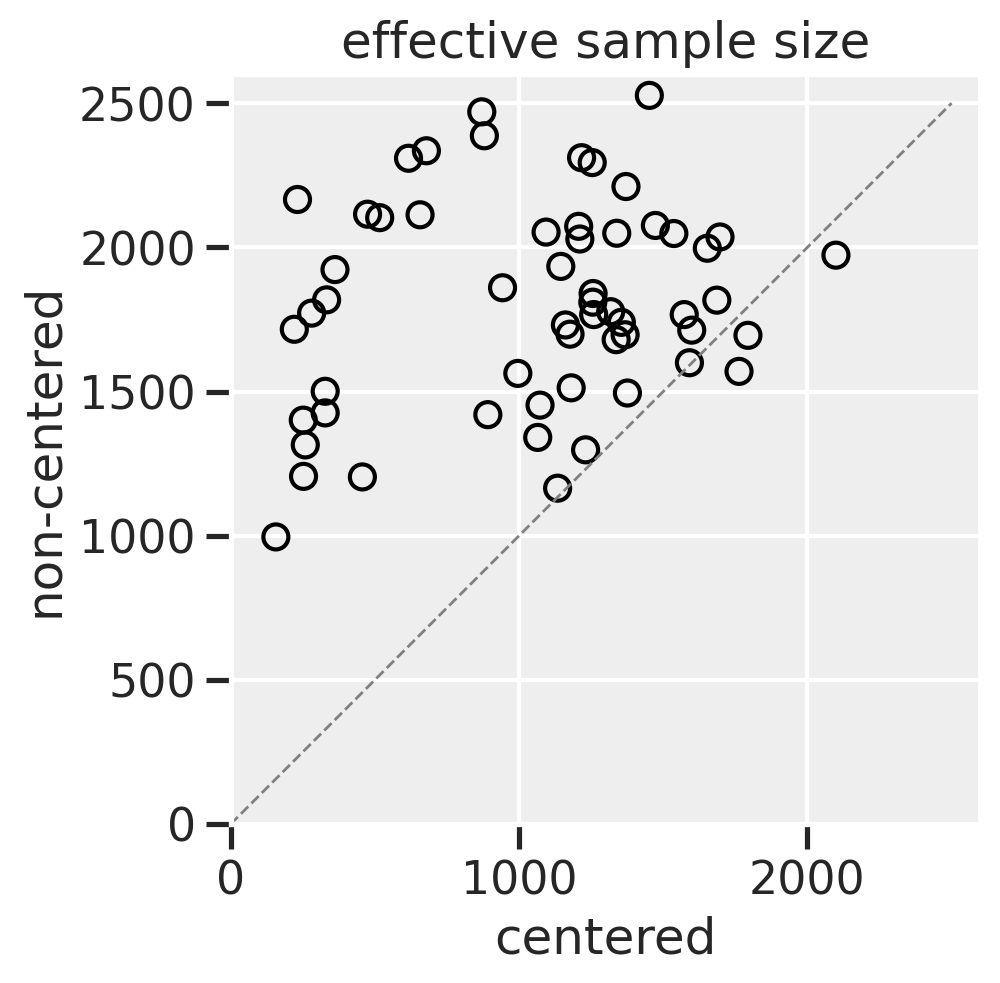

<IPython.core.display.Javascript object>

In [653]:
f, ax0 = plt.subplots()
ax0.scatter(
    df_summary_mSim2Ic.loc[df_summary_mSim2Ic['index'].str.contains('a\['), 'ess_mean'],
    df_summary_mSim2Id.loc[df_summary_mSim2Id.index.str.contains('a\['), 'ess_mean'],
    facecolors='none',
    edgecolors='k'
    )
ax0.plot([0, 2500], [0, 2500], linestyle='dashed', linewidth=1, color='gray')
ax0.set(xlim=[0,2600], ylim=[0,2600], xlabel='centered', ylabel='non-centered', title='effective sample size')
ax0.set_aspect('equal', 'box')

The non-centered paramaterization should have better estimates.

In [662]:
df_summary_mSim2Id['pid'] = df_summary_mSim2Id['index']
df_summary_mSim2Id['pid'] = df_summary_mSim2Id['pid'].str.split('a\[', expand=True)[1].str.strip('\]')
df_summary_mSim2Id_avals = df_summary_mSim2Id.loc[df_summary_mSim2Id['index'].str.contains('a\['), :].copy()

<IPython.core.display.Javascript object>

In [664]:
df_summary_mSim2Id_avals = pd.merge(
        df_summary_mSim2Id_avals.reset_index(),
        s_appt[['n_appts','patient_id_s']],
        how='left',
        left_on='pid',
        right_on='patient_id_s'
    )

df_summary_mSim2Id_avals.head()

level_0 index   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
0       59  a[0]  0.554  0.134     0.313      0.846      0.003    0.002   
1       60  a[1]  0.534  0.131     0.279      0.817      0.003    0.002   
2       61  a[2]  0.457  0.135     0.158      0.700      0.003    0.002   
3       62  a[3]  0.533  0.139     0.244      0.814      0.003    0.002   
4       63  a[4]  0.592  0.155     0.331      0.916      0.004    0.003   

   ess_mean  ess_sd  ess_bulk  ess_tail  r_hat pid  n_appts_x patient_id_s_x  \
0    2103.0  1920.0    2316.0    1963.0    1.0   0       69.0              0   
1    2115.0  2115.0    2238.0    2043.0    1.0   1       69.0              1   
2    2166.0  2166.0    2333.0    1824.0    1.0   2       69.0              2   
3    1934.0  1769.0    2085.0    1579.0    1.0   3       63.0              3   
4    1716.0  1485.0    1978.0    1751.0    1.0   4       55.0              4   

   n_appts_y patient_id_s_y  
0         69              0  
1         69              1  
2         69              2  
3         63              3  
4         55              4

<IPython.core.display.Javascript object>

In [668]:
trace_mSim2Id_df.head()

a_bar      z__0      z__1      z__2      z__3      z__4      z__5  \
0  0.569578 -0.875126 -0.443140 -0.356364 -2.138005 -0.410236 -0.501665   
1  0.484167  0.398167  0.899625 -0.318383  1.090972  0.061696 -0.450384   
2  0.546382 -0.507766 -0.867950 -0.234704 -0.966312 -0.005477  0.379294   
3  0.428015  0.146181 -0.384693  1.171010 -0.264783 -0.326739 -0.161076   
4  0.546230 -0.151315  0.913559 -1.315653  0.688865 -0.187082 -0.619441   

       z__6      z__7      z__8  ...     a__47     a__48     a__49     a__50  \
0 -1.485089 -0.095553  0.773444  ...  0.569639  0.570254  0.569549  0.569853   
1  0.851640  0.404977 -0.930471  ...  0.533161  0.287097  0.505914  0.409995   
2 -0.951295 -0.391328  0.729709  ...  0.545478  0.550007  0.545686  0.547947   
3  1.091325 -0.182767 -0.266713  ...  0.439362  0.415015  0.411601  0.429550   
4 -0.516685  0.759409  0.562085  ...  0.482041  0.615658  0.533570  0.561991   

      a__51     a__52     a__53     a__54     a__55     a__56  
0  0.569542  0.570530  0.569903  0.569274  0.568131  0.569112  
1  0.475100  0.359290  0.468957  0.587311  0.977579  0.700057  
2  0.546518  0.548645  0.547304  0.544093  0.536167  0.542405  
3  0.440344  0.413926  0.411973  0.434198  0.468674  0.437880  
4  0.470759  0.713935  0.653854  0.530727  0.292917  0.446728  

[5 rows x 116 columns]

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'n_appts'),
 Text(0, 0.5, 'SD of estimate'),
 Text(0.5, 1.0, 'Sample size and standard deviation\nof estimate')]

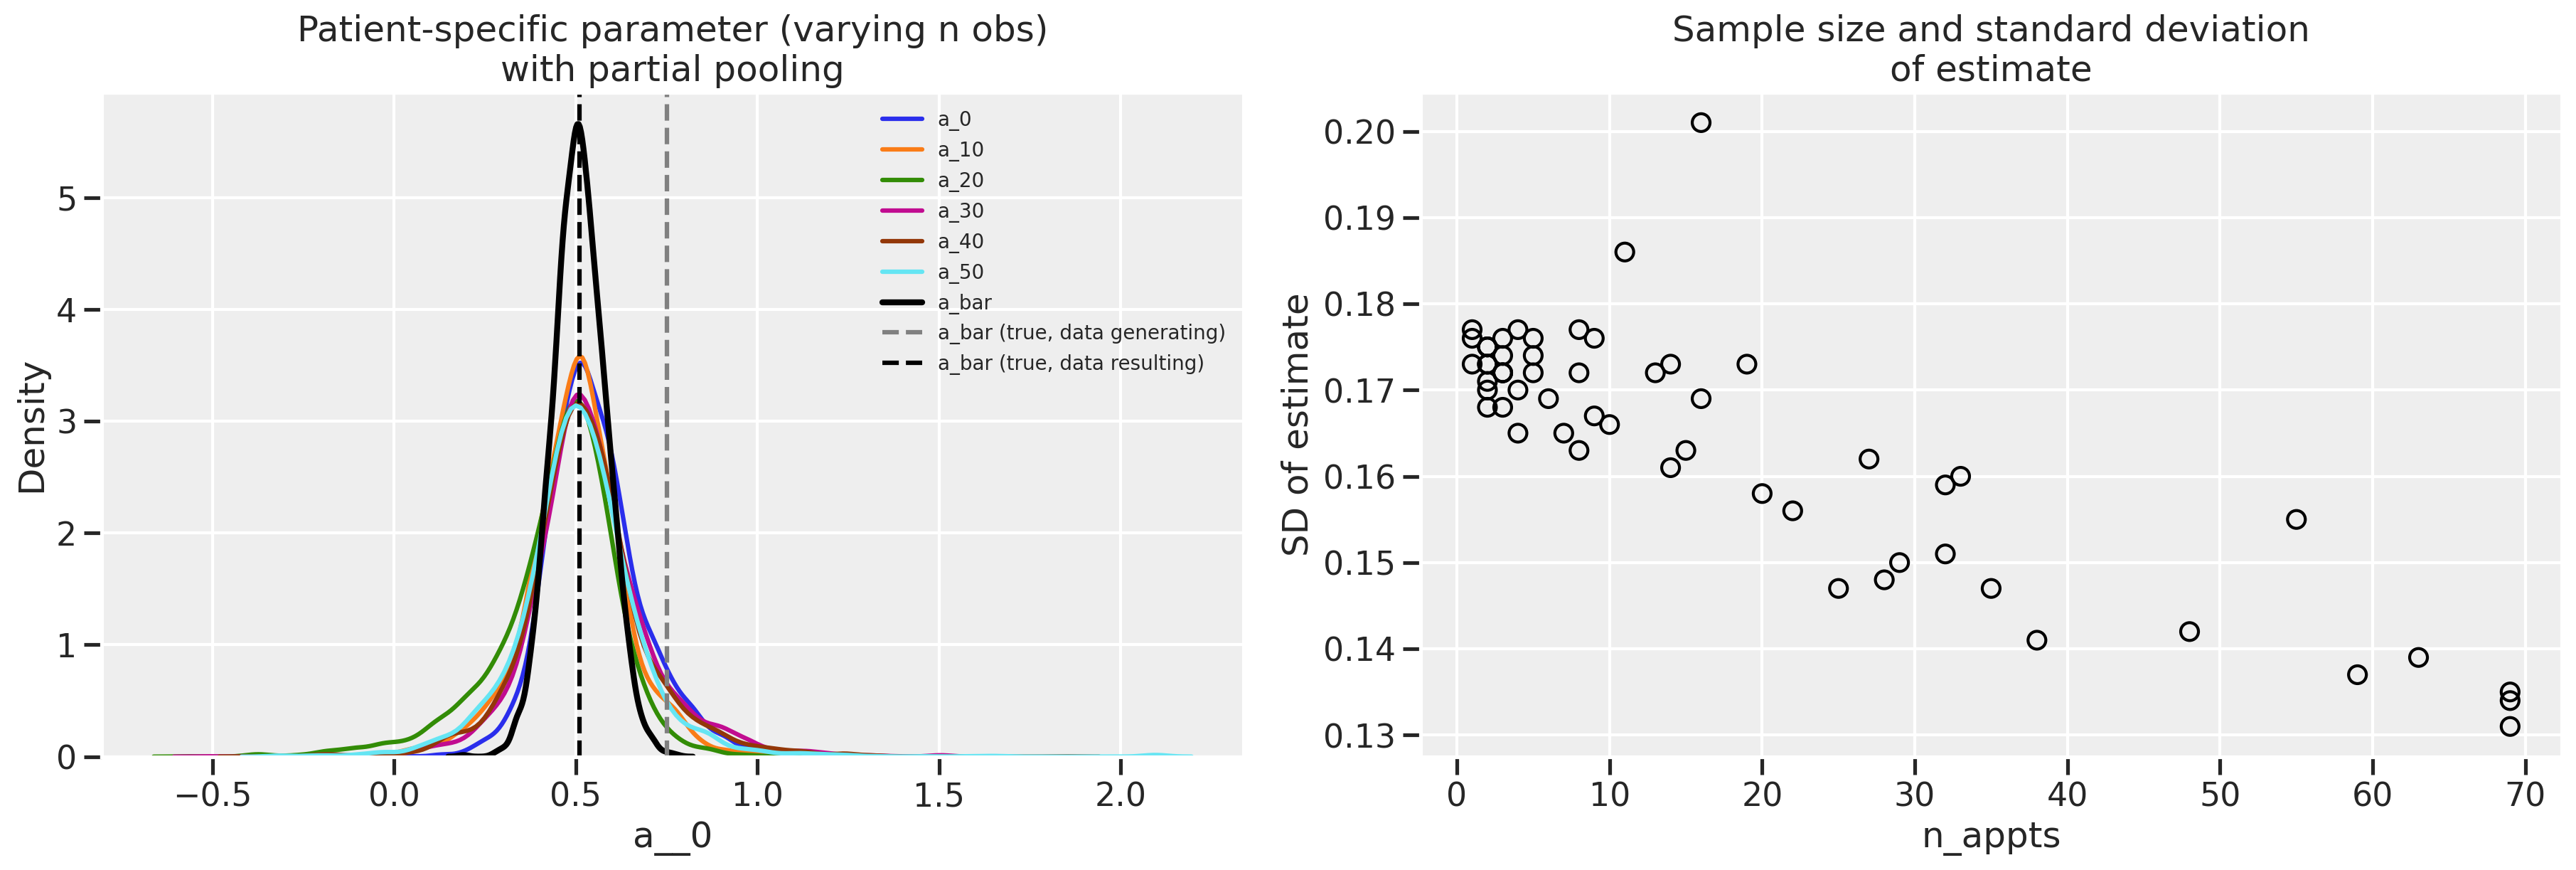

<IPython.core.display.Javascript object>

In [670]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(18,6))

# First plot
for i in range(0, 60, 10):
    sns.kdeplot(trace_mSim2Id_df[f'a__{i}'], label=f'a_{i}', ax=ax0)
sns.kdeplot(trace_mSim2Id_df[f'a_bar'], linewidth=3, color='k', label=f'a_bar', ax=ax0)

ax0.axvline(0.75, color='gray', linestyle='dashed', label='a_bar (true, data generating)')
ax0.axvline(logit(df_Sim2['appt_adhere'].mean()), color='black', linestyle='dashed', label='a_bar (true, data resulting)')

ax0.set(title='Patient-specific parameter (varying n obs)\nwith partial pooling')
ax0.legend(fontsize=10)

# Second plot
ax1.scatter(df_summary_mSim2Id_avals['n_appts_x'], df_summary_mSim2Id_avals['sd'], facecolors='none', edgecolors='k')
ax1.set(xlabel='n_appts', ylabel='SD of estimate', title='Sample size and standard deviation\nof estimate')

In [678]:
cols2get = ['index', 'mean', 'sd', 'pid', 'n_appts']
df_summary_mSim2I_fixed_mixed = pd.merge(
    df_summary_mSim2Ib[cols2get],
    df_summary_mSim2Id[cols2get],
    how='inner',
    on='pid'
)
df_summary_mSim2I_fixed_mixed.head()


index_x  mean_x   sd_x pid  n_appts_x index_y  mean_y   sd_y  n_appts_y
0    a[0]   0.699  0.252   0         69    a[0]   0.554  0.134       69.0
1    a[1]   0.634  0.253   1         69    a[1]   0.534  0.131       69.0
2    a[2]   0.275  0.238   2         69    a[2]   0.457  0.135       69.0
3    a[3]   0.627  0.260   3         63    a[3]   0.533  0.139       63.0
4    a[4]   0.975  0.296   4         55    a[4]   0.592  0.155       55.0

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'fixed effects'),
 Text(0, 0.5, 'mixed effects'),
 Text(0.5, 1.0, 'Fixed vs. Mixed effects standard deviation\nsized by n_obs')]

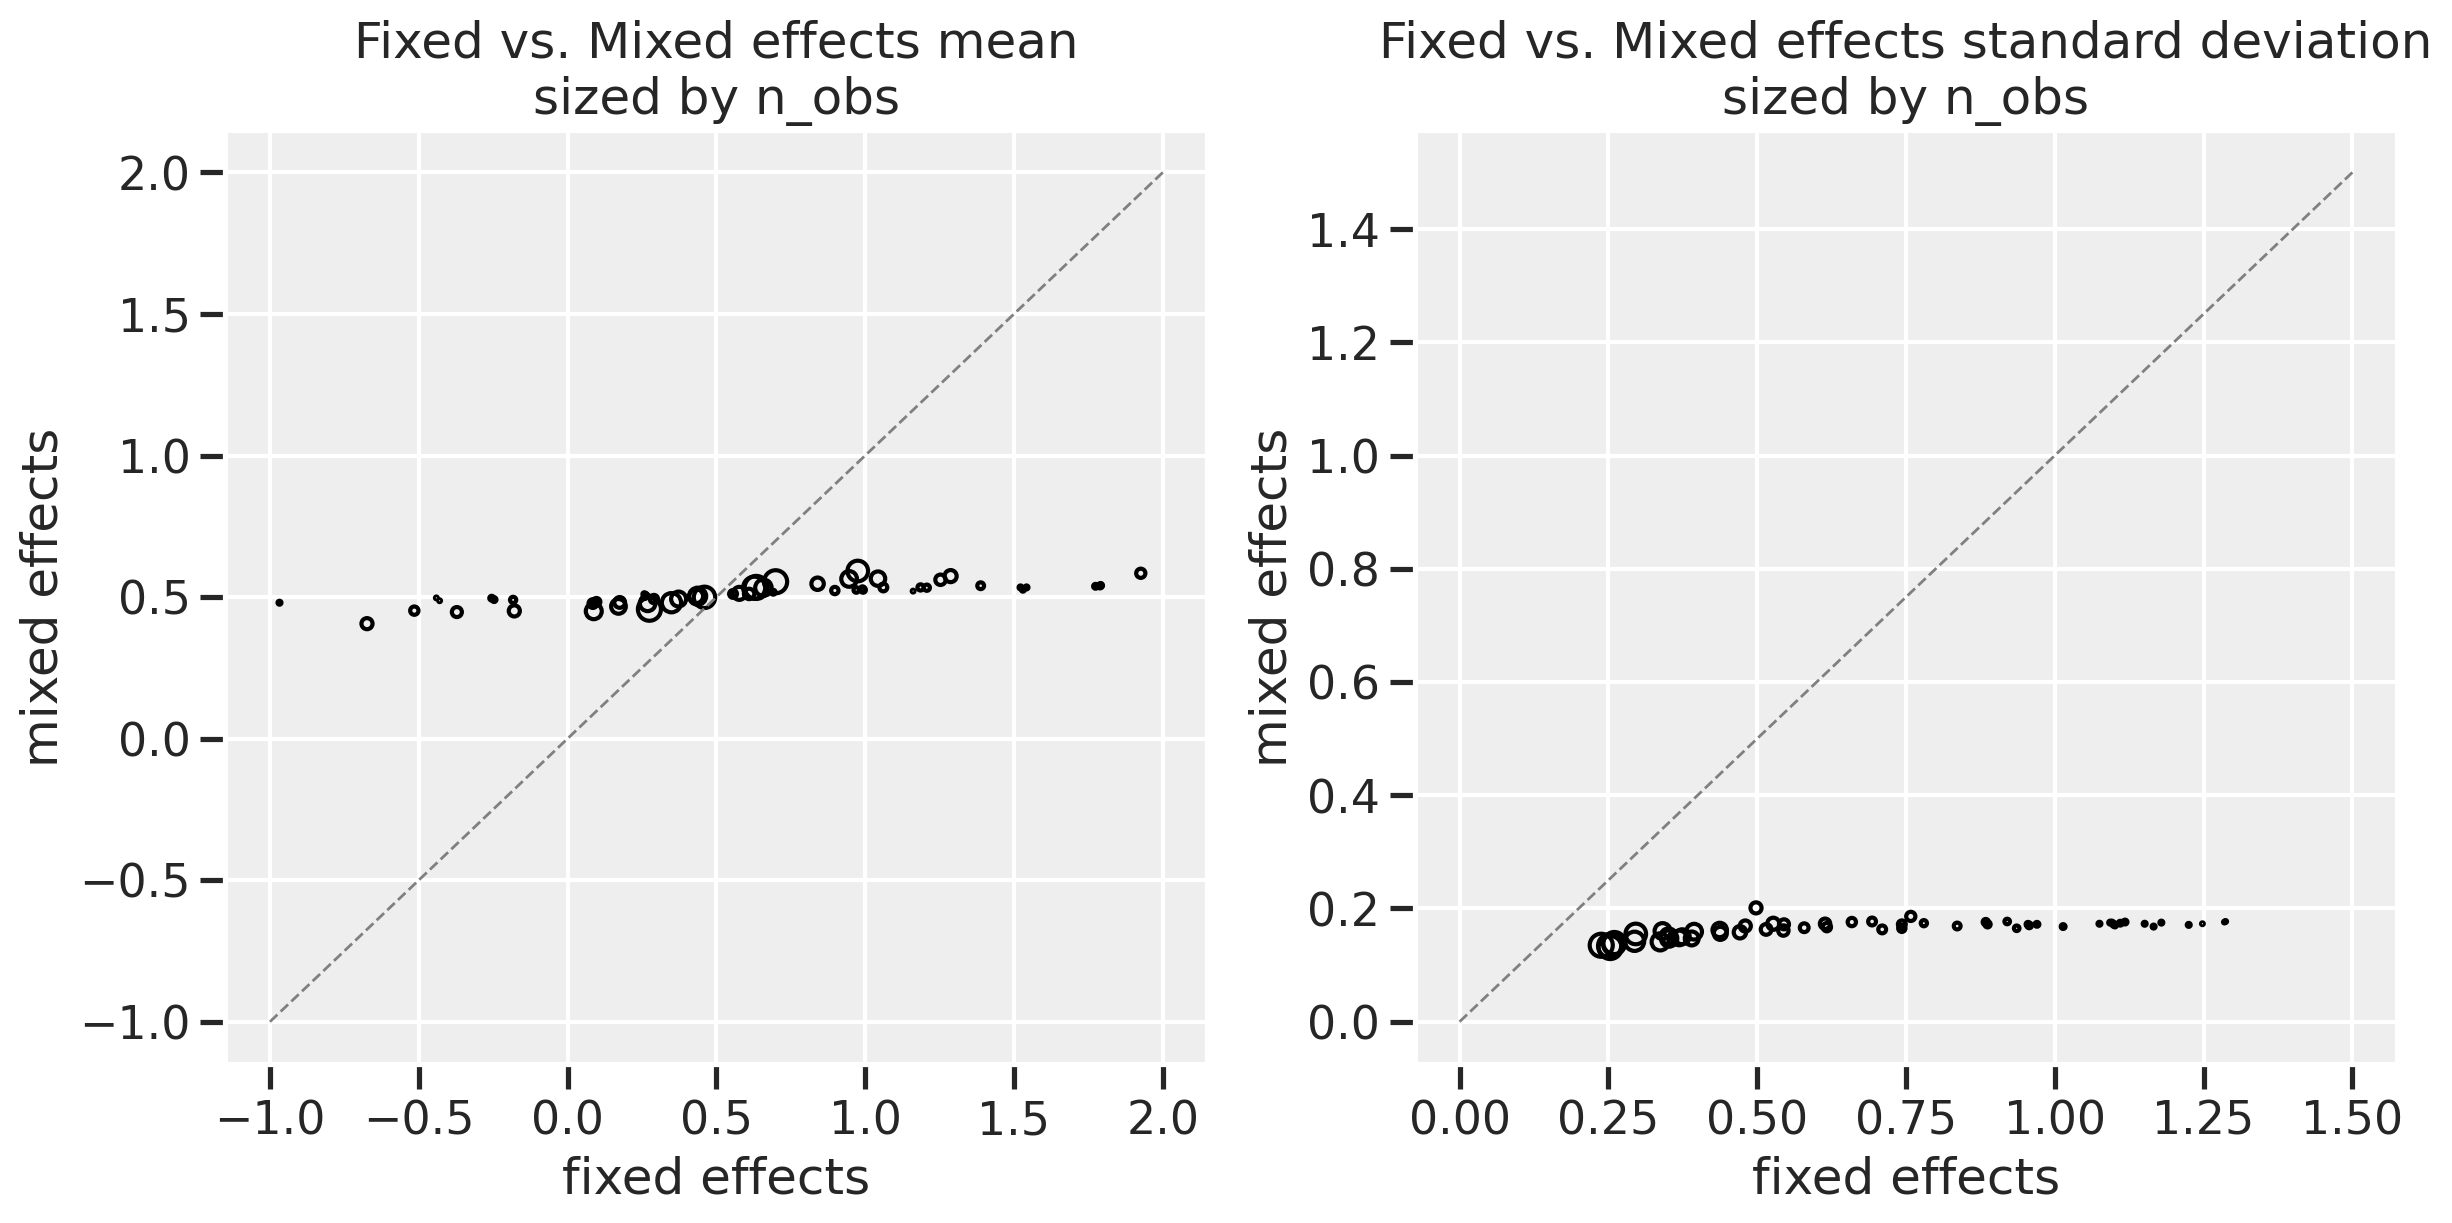

<IPython.core.display.Javascript object>

In [679]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
ax0.scatter(df_summary_mSim2I_fixed_mixed['mean_x'], df_summary_mSim2I_fixed_mixed['mean_y'], s=df_summary_mSim2I_fixed_mixed['n_appts_y'], facecolors='none', edgecolors='k')
ax0.plot([-1, 2], [-1, 2], linestyle='dashed', linewidth=1, color='gray')
ax0.set(xlabel='fixed effects', ylabel='mixed effects', title='Fixed vs. Mixed effects mean\nsized by n_obs')

ax1.scatter(df_summary_mSim2I_fixed_mixed['sd_x'], df_summary_mSim2I_fixed_mixed['sd_y'], s=df_summary_mSim2I_fixed_mixed['n_appts_y'], facecolors='none', edgecolors='k')
ax1.plot([0, 1.5], [0, 1.5], linestyle='dashed', linewidth=1, color='gray')
ax1.set(xlabel='fixed effects', ylabel='mixed effects', title='Fixed vs. Mixed effects standard deviation\nsized by n_obs')

# Summary of intercept only

This set of code is inspired by the idea that there are multiple ways to evaluate a dataset. I'd like to be cognizant of how the data structure affects statistical estimates. This includes the presence of repeat observations and the variability in number.

I started with a very simple set of data where we don't know any characteristics of a patient. All we have is a record of appointments attended or not.

In [680]:
df_summary_mSim1Ia.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a  0.488  0.066     0.357      0.608      0.001    0.001    2131.0  2131.0   

   ess_bulk  ess_tail  r_hat  
a    2146.0    2922.0    1.0

<IPython.core.display.Javascript object>

In [681]:
df_summary_mSim1Ib.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0] -0.449  1.241    -2.989      1.916      0.016    0.025    5808.0  1262.0   
a[1] -0.400  1.276    -2.875      2.100      0.017    0.022    5458.0  1620.0   
a[2]  1.154  1.307    -1.213      3.896      0.018    0.018    5132.0  2565.0   
a[3] -0.416  1.220    -2.787      1.911      0.017    0.024    4954.0  1313.0   
a[4] -0.437  1.202    -2.906      1.866      0.017    0.021    4770.0  1665.0   

      ess_bulk  ess_tail  r_hat  
a[0]    5819.0    2272.0   1.00  
a[1]    5469.0    2477.0   1.00  
a[2]    5140.0    2352.0   1.00  
a[3]    4954.0    2223.0   1.00  
a[4]    4762.0    2371.0   1.01

<IPython.core.display.Javascript object>

In [424]:
df_summary_mSim1Ic.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar  1.002  1.464    -1.788      4.028      0.019    0.023    6104.0   
a[0]   1.508  1.348    -1.083      4.232      0.016    0.020    6979.0   
a[1]  -0.088  1.266    -2.493      2.514      0.016    0.028    6421.0   
a[2]   1.547  1.380    -1.174      4.124      0.016    0.019    7202.0   
a[3]   1.555  1.322    -1.017      4.105      0.015    0.018    8243.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a_bar  1947.0    6085.0    2411.0    1.0  
a[0]   2331.0    7043.0    1925.0    1.0  
a[1]   1040.0    6527.0    1988.0    1.0  
a[2]   2525.0    7245.0    1881.0    1.0  
a[3]   2793.0    8606.0    2275.0    1.0

<IPython.core.display.Javascript object>

In [426]:
df_summary_mSim2Ia.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a  1.115  0.074     0.962      1.255      0.002    0.001    1859.0  1859.0   

   ess_bulk  ess_tail  r_hat  
a    1852.0    2372.0    1.0

<IPython.core.display.Javascript object>

In [427]:
df_summary_mSim2Ib.head()

index   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
0  a[0]  1.457  0.291     0.920      2.054      0.003    0.002    9092.0   
1  a[1]  1.280  0.270     0.784      1.833      0.003    0.002    9564.0   
2  a[2]  0.935  0.252     0.449      1.421      0.003    0.002    8618.0   
3  a[3]  1.198  0.299     0.635      1.803      0.003    0.003    8697.0   
4  a[4]  0.773  0.279     0.241      1.317      0.003    0.003    9905.0   

   ess_sd  ess_bulk  ess_tail  r_hat pid  n_appts patient_id_s  
0  6932.0    9626.0    2623.0    1.0   0       79            0  
1  8098.0    9714.0    2751.0    1.0   1       73            1  
2  6618.0    8627.0    2428.0    1.0   2       77            2  
3  6636.0    8935.0    2636.0    1.0   3       64            3  
4  6177.0   10180.0    2941.0    1.0   4       56            4

<IPython.core.display.Javascript object>

In [428]:
df_summary_mSim2Ic.head()

index   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
0  a_bar  1.031  1.498    -1.730      4.102      0.016    0.020    8874.0   
1   a[0]  1.460  0.277     0.902      1.988      0.003    0.002    8550.0   
2   a[1]  1.280  0.280     0.730      1.838      0.003    0.003    7721.0   
3   a[2]  0.935  0.262     0.426      1.433      0.003    0.002    8051.0   
4   a[3]  1.203  0.290     0.662      1.784      0.003    0.002    9061.0   

   ess_sd  ess_bulk  ess_tail  r_hat   pid  n_appts patient_id_s  
0  2741.0    8833.0    3067.0    1.0  None      NaN          NaN  
1  7428.0    8708.0    3062.0    1.0     0     79.0            0  
2  5930.0    7917.0    2257.0    1.0     1     73.0            1  
3  5648.0    7748.0    2690.0    1.0     2     77.0            2  
4  6872.0    9143.0    2864.0    1.0     3     64.0            3

<IPython.core.display.Javascript object>

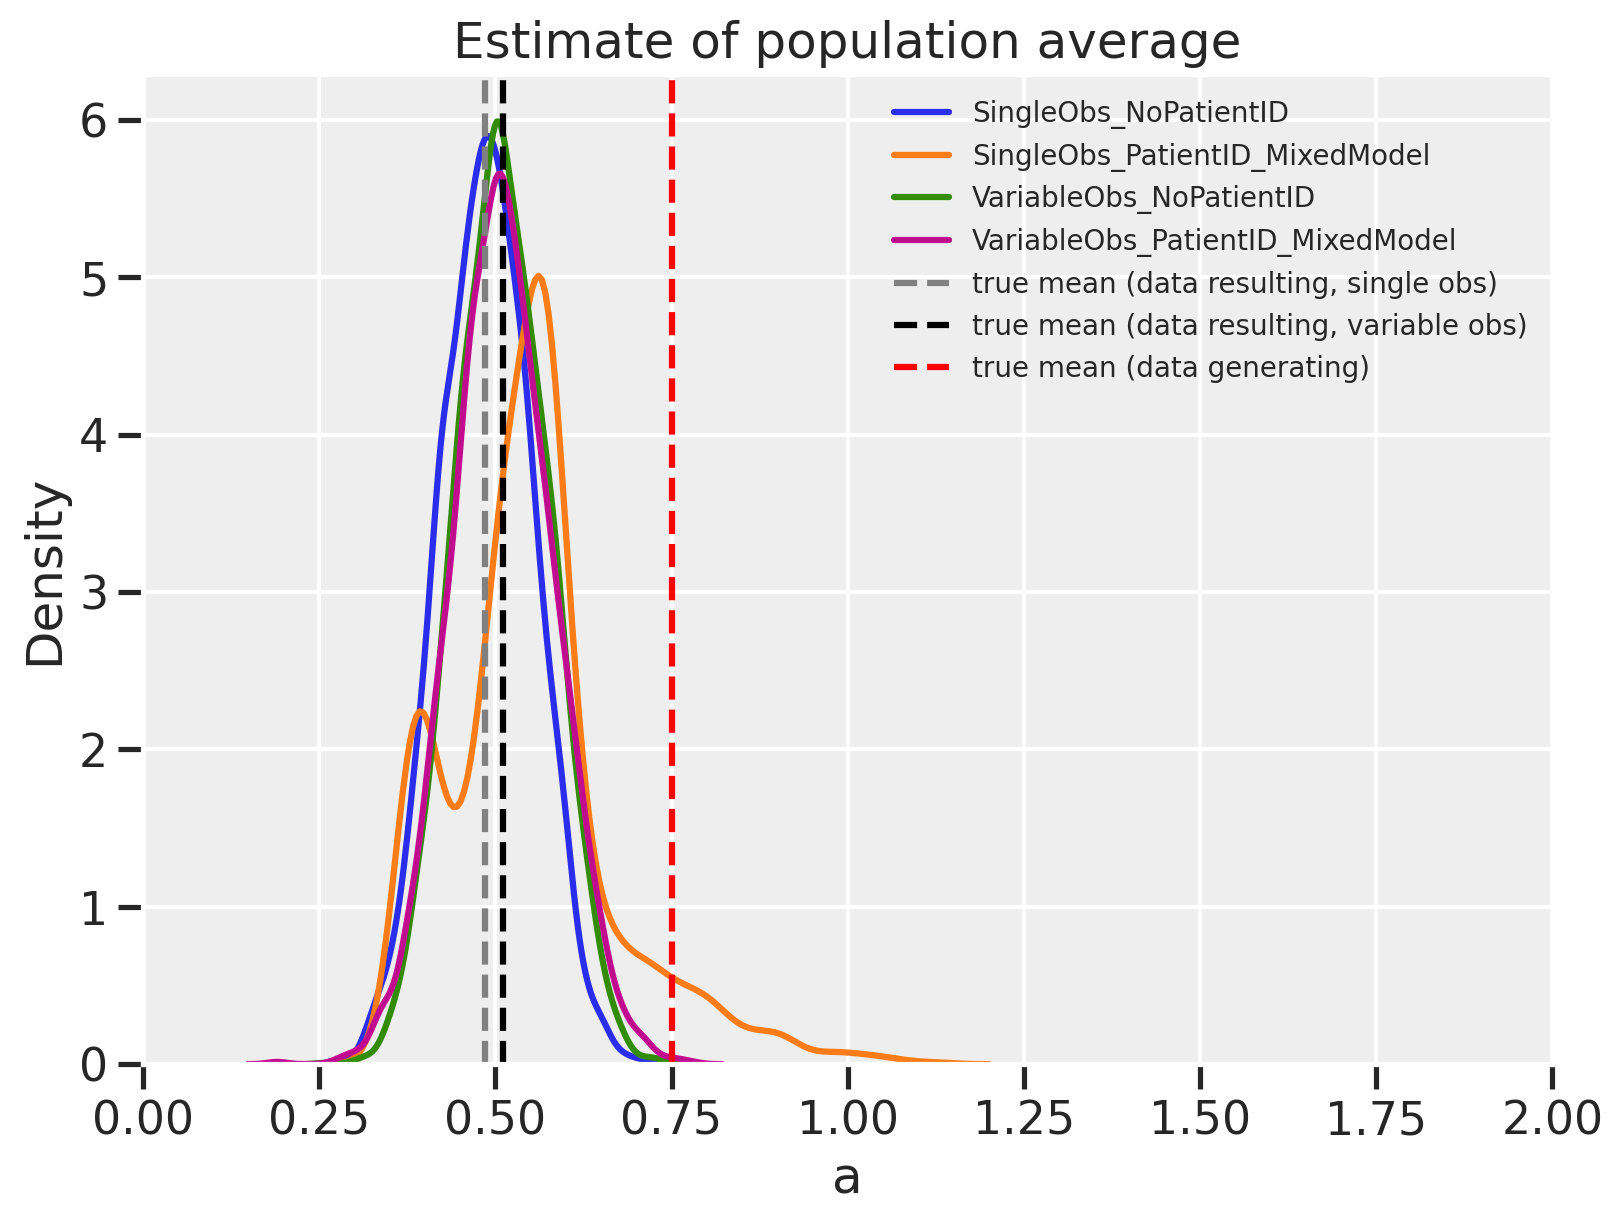

<IPython.core.display.Javascript object>

In [685]:
abar_est2plot = {'SingleObs_NoPatientID':trace_mSim1Ia_df, 
'SingleObs_PatientID_MixedModel':trace_mSim1Ic_df, 
'VariableObs_NoPatientID':trace_mSim2Ia_df, 
'VariableObs_PatientID_MixedModel':trace_mSim2Id_df}

f, ax0 = plt.subplots(figsize=(8,6))
for abar_est in abar_est2plot:
    if abar_est2plot[abar_est].shape[1] == 1:
        sns.kdeplot(abar_est2plot[abar_est]['a'], alpha=0.5, label=abar_est, ax=ax0)
    else:
        sns.kdeplot(abar_est2plot[abar_est]['a_bar'], alpha=0.5, label=abar_est, ax=ax0)

ax0.axvline(logit(df_Sim1['appt_adhere'].mean()), linestyle='dashed', color='gray', label='true mean (data resulting, single obs)')
ax0.axvline(logit(df_Sim2['appt_adhere'].mean()), linestyle='dashed', color='black', label='true mean (data resulting, variable obs)')
ax0.axvline(0.75, linestyle='dashed', color='red', label='true mean (data generating)')
ax0.set(xlim=[0,2], title='Estimate of population average')
ax0.legend(fontsize=10)

# Dataset with intercept and one slope (AKA data with two intercepts or two clusters)

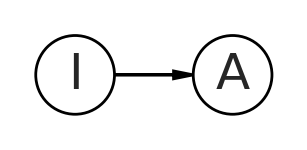

<IPython.core.display.Javascript object>

In [688]:
dag = CausalGraphicalModel(
    nodes=["I", "A"],
    edges=[("I", "A")],
)
pgm = daft.PGM()
coordinates = {
    "I": (0, 0),
    "A": (1, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)

pgm.render()


### Model equation

Each patient has only one observation. It is influenced by an average affect of their insurance status. Insurance status will be encoded as a categorical index variable (public and private).

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu = \alpha + \beta_{[\text{INS}]} $$

This is what the code looked like before. 

```
n_patients = 1000
patient_id = range(n_patients)
a_bar = 0.75  # population average log-odds of adherence
sd_pop = 1.5  # population SD on log-odds of adherence
alpha_i = stats.norm.rvs(
    loc=a_bar, scale=sd_pop, size=n_patients
)  # use population to get individuals
prob_adhere_i = expit(alpha_i)  # use probability of adherence to get individuals
appt_adhere_i = stats.bernoulli.rvs(p=prob_adhere_i)
```

In [739]:
n_patients = 1000
patient_id = range(n_patients)
# mu = 0.75  # population average log-odds of adherence, taking all variables into account
# simulate insurance status, most will have private (1) https://www.census.gov/library/publications/2021/demo/p60-274.html
ins_status = stats.bernoulli.rvs(p=0.7, size=n_patients)
b0 = 0.05  # public insurance has small improvement over alpha
b1 = 0.2  # private insurance has large improvement over alpha
beta_i = np.where(ins_status == 1, b1, b0)
alpha_i = 0.5

sd_pop = 0.2  # population SD on log-odds of adherence
mu_i = stats.norm.rvs(
    loc=alpha_i + beta_i, scale=sd_pop                  ####### changed sd_pop
)  # use population to get individuals

prob_adhere_i = expit(mu_i)  # use probability of adherence to get individuals
appt_adhere_i = stats.bernoulli.rvs(p=prob_adhere_i)

df_Sim3 = pd.DataFrame(
    {
        "patient_id": patient_id,
        "mu": mu_i,  # wouldn't be present in EHR but keep for comparison purposes
        "alpha": alpha_i,  # wouldn't be present in EHR but keep for comparison purposes
        "b_ins": beta_i,  # wouldn't be present in EHR but keep for comparison purposes
        "ins_status": ins_status,
        "appt_adhere": appt_adhere_i,
    }
)

print(
    "Have a look at 10 randomly sampled values that would be observed from the dataframe"
)
df_Sim3.sample(10)


Have a look at 10 randomly sampled values that would be observed from the dataframe


patient_id        mu  alpha  b_ins  ins_status  appt_adhere
115         115  0.488348    0.5   0.20           1            1
553         553  0.420766    0.5   0.20           1            0
452         452  0.592746    0.5   0.05           0            1
743         743  0.791006    0.5   0.20           1            1
133         133  0.706695    0.5   0.05           0            1
325         325  0.902387    0.5   0.20           1            0
566         566  0.495207    0.5   0.05           0            0
222         222  0.705987    0.5   0.20           1            1
843         843  0.932311    0.5   0.20           1            1
472         472  0.540160    0.5   0.05           0            0

<IPython.core.display.Javascript object>

In [780]:
df_Sim3.groupby('ins_status').mean()['appt_adhere']

ins_status
0    0.648903
1    0.693098
Name: appt_adhere, dtype: float64

<IPython.core.display.Javascript object>

### FOLLOW-UP
How to set the correct population SD? 

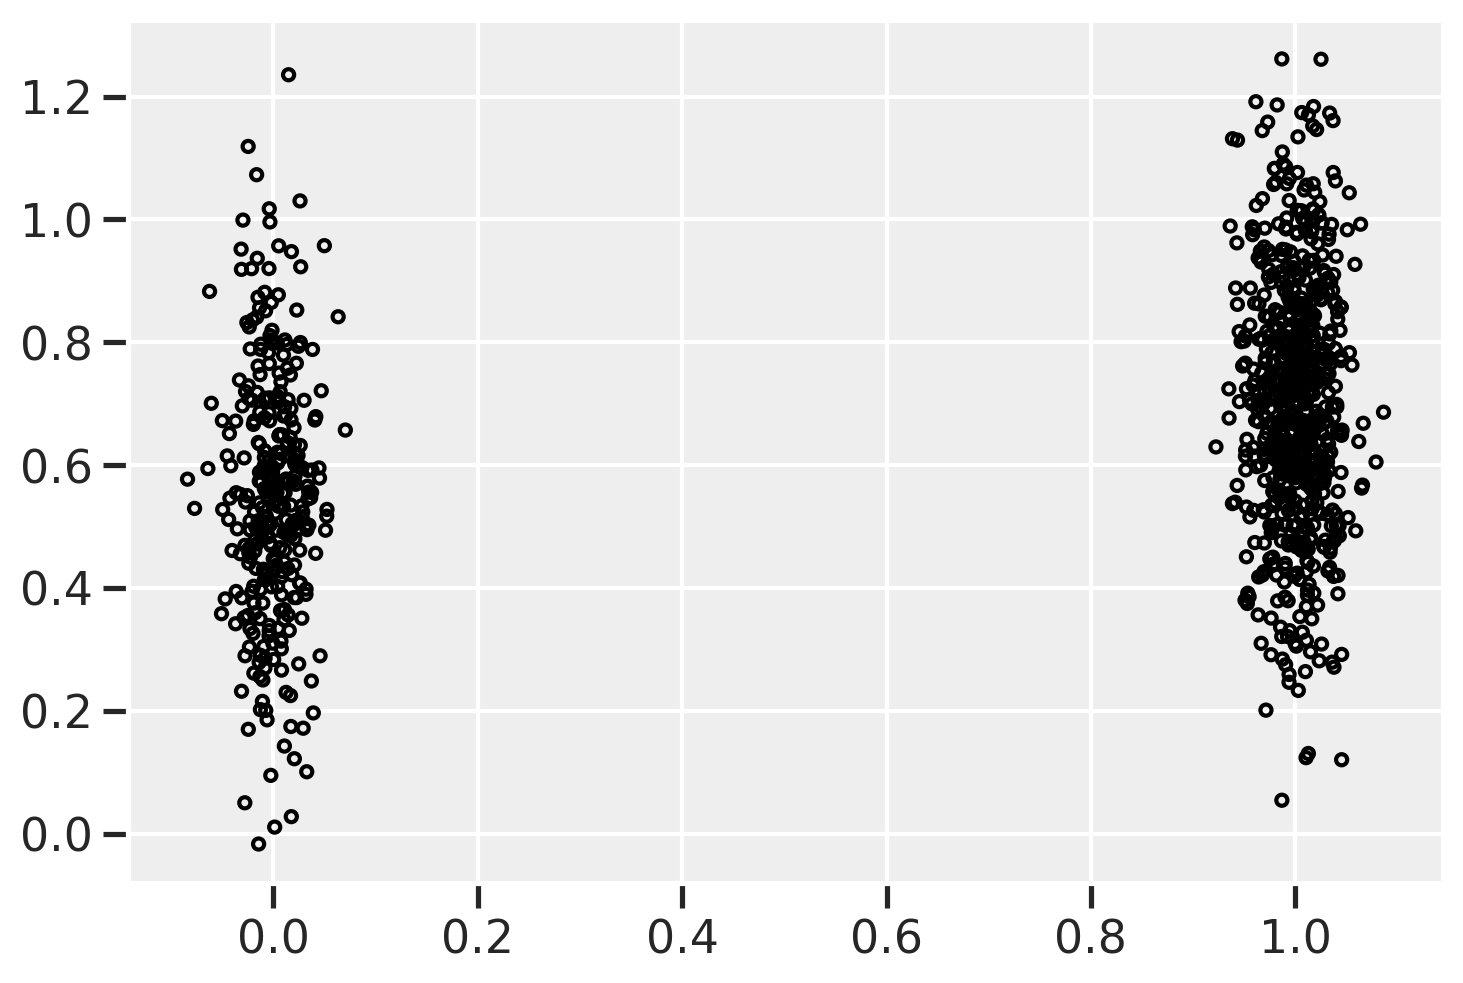

<IPython.core.display.Javascript object>

In [843]:
f, ax0 = plt.subplots()
x_jitter = np.random.normal(0, 0.025, size=len(df_Sim3))
ax0.scatter(df_Sim3['ins_status'] + x_jitter, df_Sim3['mu'], s=2**4, facecolors='none', edgecolors='k')

### Fixed prior, no `patientID`, additive model

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu = \alpha + \beta_{[\text{INS}]} $$
$$ \alpha_j \sim \text{Normal}(0.5, 1.5) $$
$$ \beta_j \sim \text{Normal}(0, 1) $$

In [747]:
df_Sim3.head()

patient_id        mu  alpha  b_ins  ins_status  appt_adhere
0           0  0.848135    0.5   0.20           1            1
1           1  0.494790    0.5   0.05           0            1
2           2  0.676759    0.5   0.20           1            1
3           3  0.359931    0.5   0.05           0            1
4           4  0.979200    0.5   0.20           1            0

<IPython.core.display.Javascript object>

In [748]:
df_Sim3['appt_adhere'].mean()

0.679

<IPython.core.display.Javascript object>

In [749]:
n_ins = 2

# population intercept only, no patient-specific intercept, fixed prior
with pm.Model() as mSim3Ia:

    # prior for patient_id
    a = pm.Normal("a", 0.5, 1.5)
    b = pm.Normal("b", 0, 1, shape=n_ins)

    # link function
    p = pm.math.invlogit(a + b[df_Sim3['ins_status']])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim3["appt_adhere"])

    trace_mSim3Ia = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # prior predictive checks
    prior_checks_mSim3Ia = pm.sample_prior_predictive(samples=100)

    # summaries and plotting
    df_summary_mSim3Ia = az.summary(trace_mSim3Ia)
    trace_mSim3Ia_df = pm.trace_to_dataframe(trace_mSim3Ia)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8826948542504818, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [750]:
df_summary_mSim3Ia

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a     0.646  0.626    -0.562      1.885      0.023    0.017     718.0   708.0   
b[0] -0.030  0.628    -1.254      1.196      0.023    0.017     731.0   698.0   
b[1]  0.167  0.627    -1.012      1.432      0.023    0.017     720.0   693.0   

      ess_bulk  ess_tail  r_hat  
a        717.0     795.0   1.01  
b[0]     730.0     794.0   1.01  
b[1]     718.0     817.0   1.01

<IPython.core.display.Javascript object>

In [784]:
expit(0.646 - 0.03), expit(0.646 + 0.167)

(0.6493082652711343, 0.6927484174138304)

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>]], dtype=object)

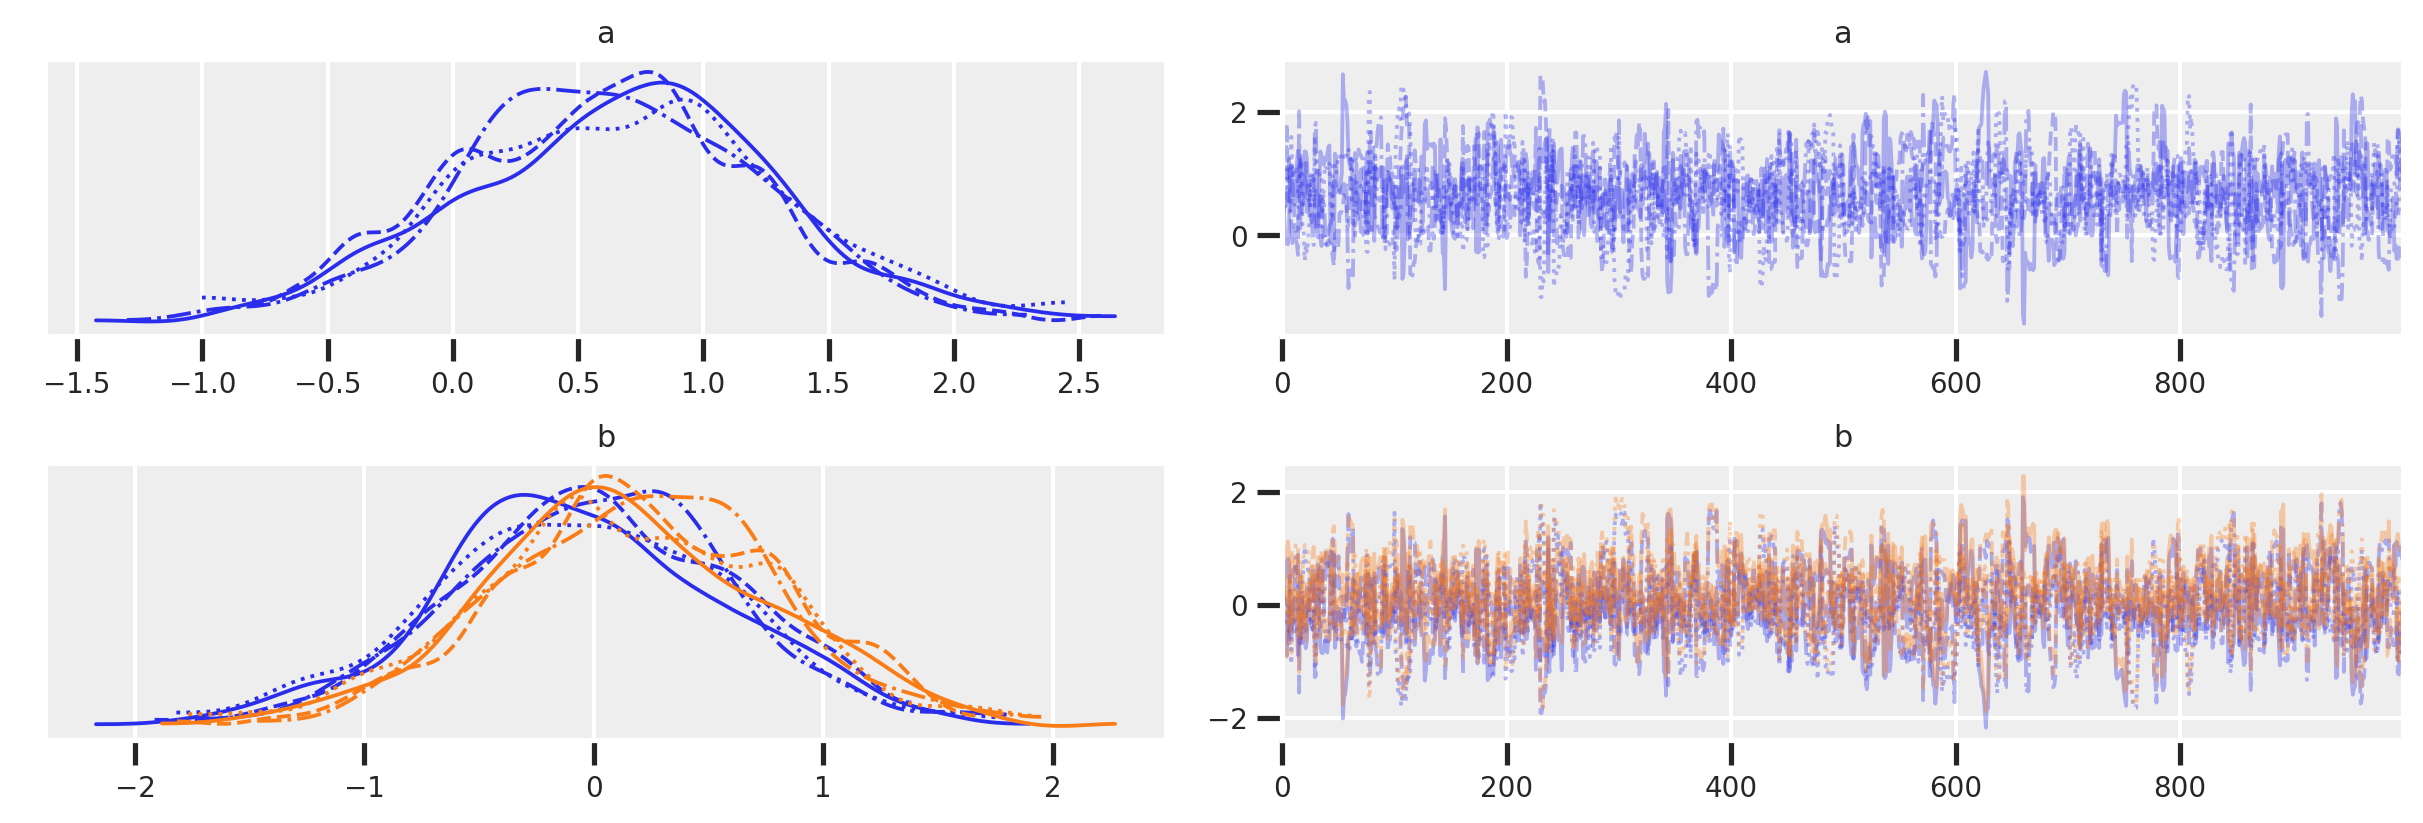

<IPython.core.display.Javascript object>

In [752]:
az.plot_trace(trace_mSim3Ia)

Find the contrasts

In [754]:
az.summary(np.array(trace_mSim3Ia_df['b__1'] - trace_mSim3Ia_df['b__0']))

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
x  0.197  0.143    -0.075      0.483      0.002    0.002    3292.0  2936.0   

   ess_bulk  ess_tail  r_hat  
x    3300.0    2495.0    NaN

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'contrast\n(private-public)')]

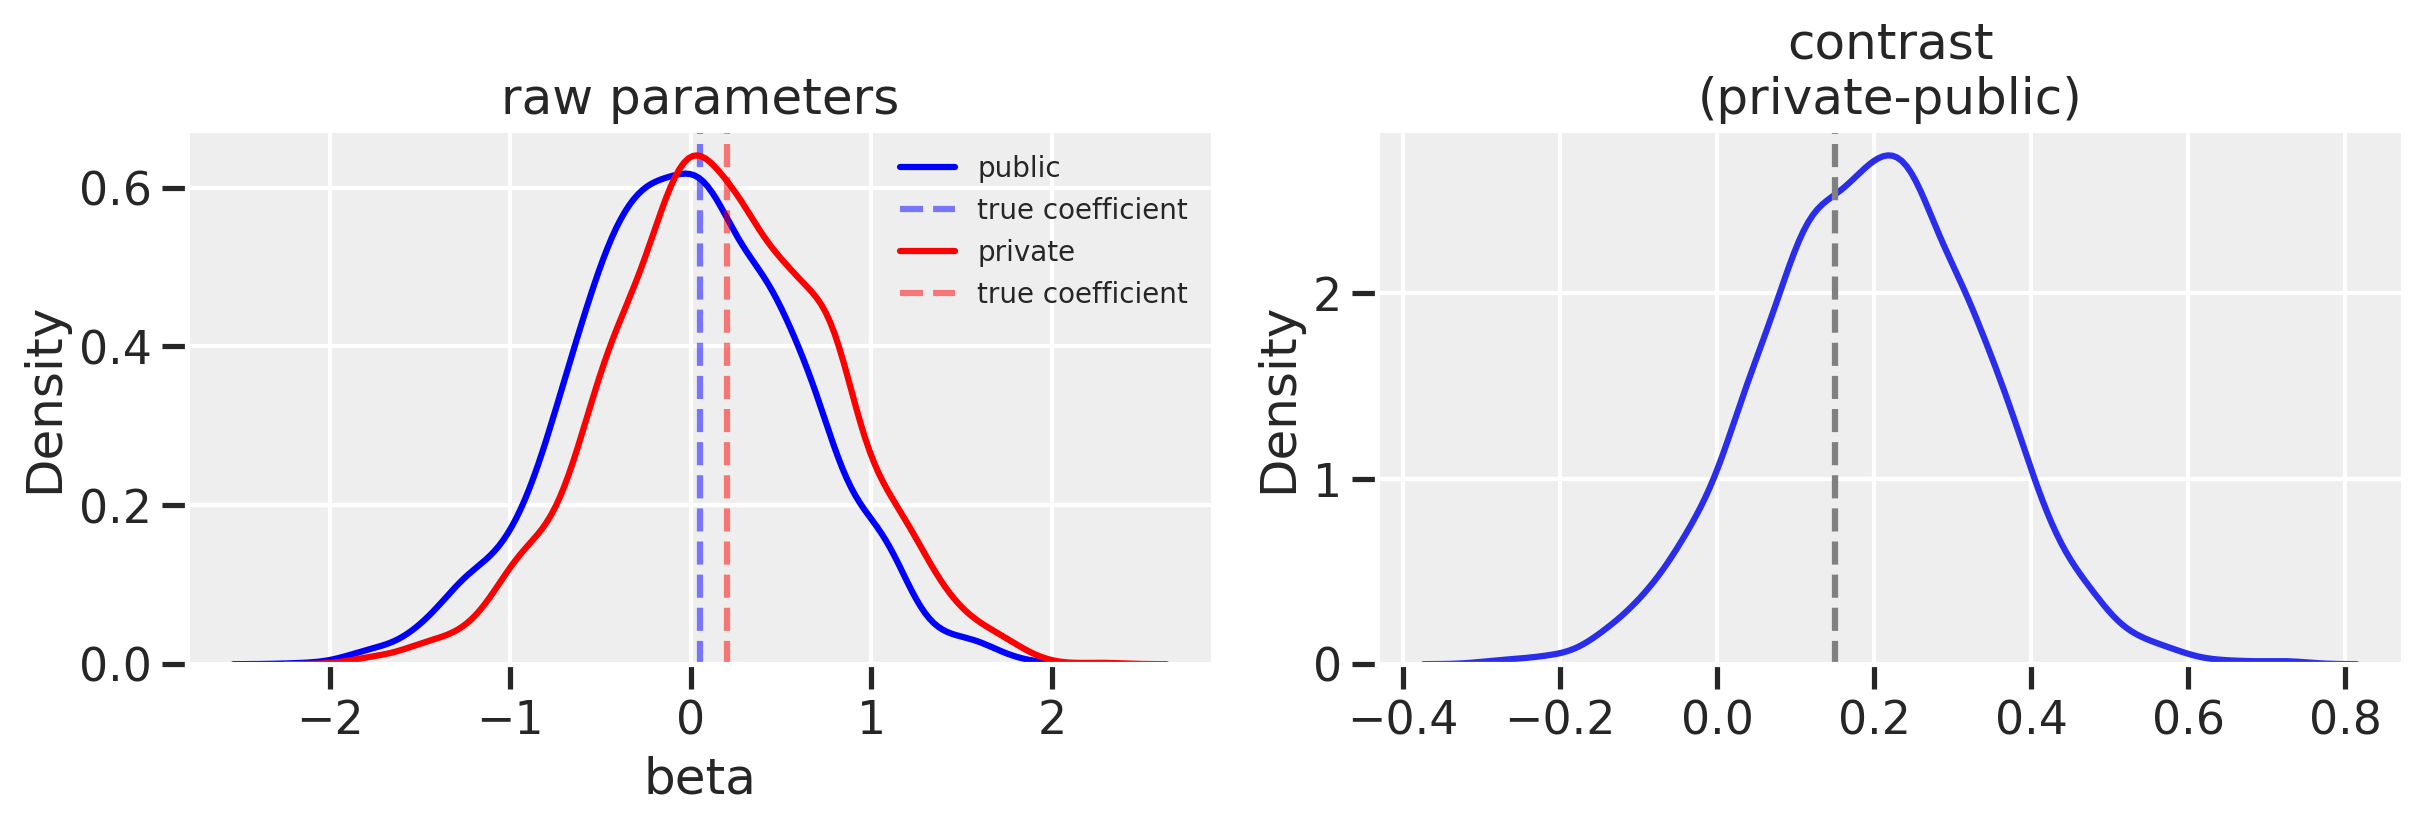

<IPython.core.display.Javascript object>

In [774]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
# raw values
sns.kdeplot(trace_mSim3Ia_df['b__0'], c='blue', label='public', ax=ax0)
ax0.axvline(b0, linestyle='dashed', alpha=0.5, color='blue', label='true coefficient')
sns.kdeplot(trace_mSim3Ia_df['b__1'], c='red', label='private', ax=ax0)
ax0.axvline(b1, linestyle='dashed', alpha=0.5, color='red', label='true coefficient')
ax0.set(xlabel='beta', title='raw parameters')
ax0.legend(fontsize=10)

# contrast
sns.kdeplot((trace_mSim3Ia_df['b__1'] - trace_mSim3Ia_df['b__0']), ax=ax1)
ax1.axvline(0.15, linestyle='dashed', color='gray', label='true difference')
ax1.set(title='contrast\n(private-public)')

There's a lot of uncertainty but the inference is consistent with the data generating model.

### Fixed prior, no `patientID`, index model

Alpha gets absorbed into beta.

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu[\beta_I] $$
$$ \beta_j \sim \text{Normal}(0, 1) $$

In [771]:
df_Sim3.head()

patient_id        mu  alpha  b_ins  ins_status  appt_adhere
0           0  0.848135    0.5   0.20           1            1
1           1  0.494790    0.5   0.05           0            1
2           2  0.676759    0.5   0.20           1            1
3           3  0.359931    0.5   0.05           0            1
4           4  0.979200    0.5   0.20           1            0

<IPython.core.display.Javascript object>

In [772]:
n_ins = 2

# population intercept only, no patient-specific intercept, fixed prior
with pm.Model() as mSim3Ib:

    # prior for patient_id
    b = pm.Normal("b", 0, 1, shape=n_ins)

    # link function
    p = pm.math.invlogit(b[df_Sim3['ins_status']])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim3["appt_adhere"])

    trace_mSim3Ib = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # prior predictive checks
    prior_checks_mSim3Ib = pm.sample_prior_predictive(samples=100)

    # summaries and plotting
    df_summary_mSim3Ib = az.summary(trace_mSim3Ib)
    trace_mSim3Ib_df = pm.trace_to_dataframe(trace_mSim3Ib)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
INFO:pymc3:NUTS: [b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


<IPython.core.display.Javascript object>

In [773]:
df_summary_mSim3Ib

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
b[0]  0.610  0.120     0.381      0.835      0.002    0.001    3490.0  3398.0   
b[1]  0.809  0.083     0.650      0.978      0.001    0.001    3517.0  3517.0   

      ess_bulk  ess_tail  r_hat  
b[0]    3486.0    2815.0    1.0  
b[1]    3523.0    2701.0    1.0

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'contrast\n(private-public)')]

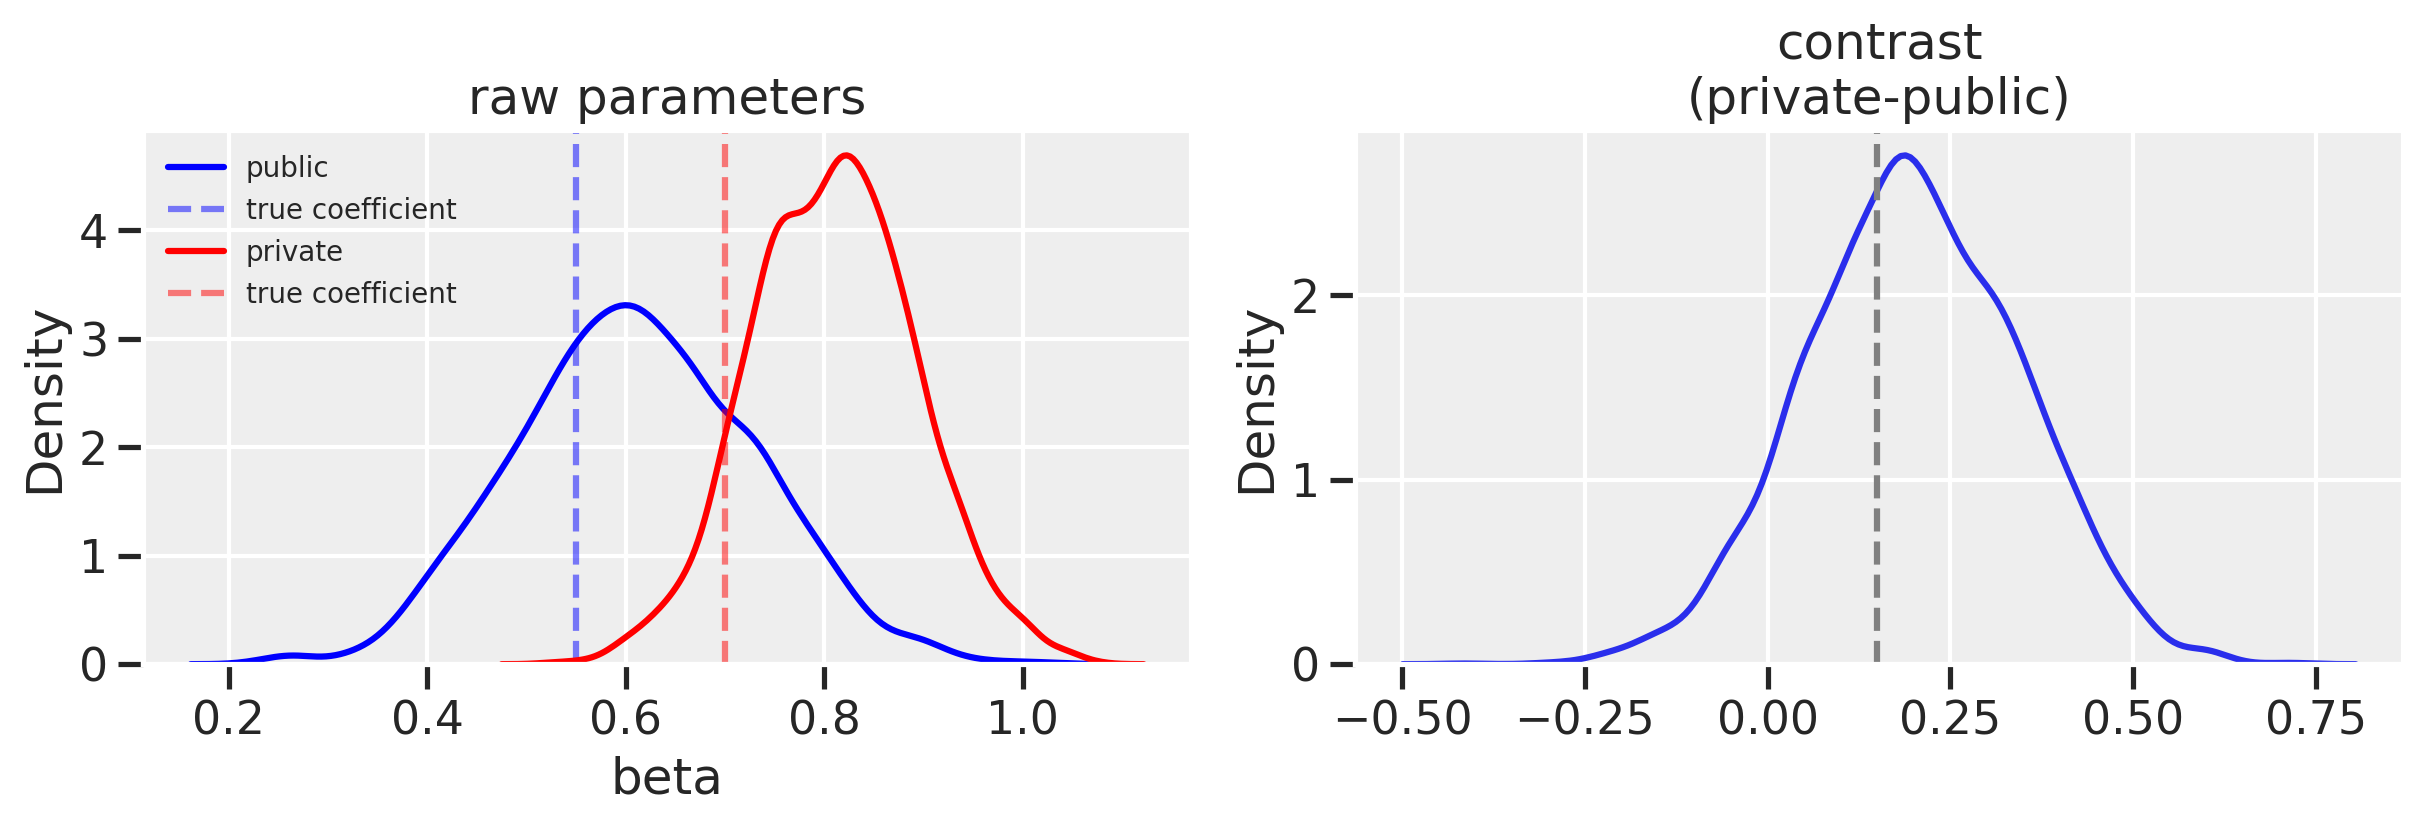

<IPython.core.display.Javascript object>

In [778]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
# raw values
sns.kdeplot(trace_mSim3Ib_df['b__0'], c='blue', label='public', ax=ax0)
ax0.axvline(alpha_i + b0, linestyle='dashed', alpha=0.5, color='blue', label='true coefficient')
sns.kdeplot(trace_mSim3Ib_df['b__1'], c='red', label='private', ax=ax0)
ax0.axvline(alpha_i + b1, linestyle='dashed', alpha=0.5, color='red', label='true coefficient')
ax0.set(xlabel='beta', title='raw parameters')
ax0.legend(fontsize=10)

# contrast
sns.kdeplot((trace_mSim3Ib_df['b__1'] - trace_mSim3Ib_df['b__0']), ax=ax1)
ax1.axvline(0.15, linestyle='dashed', color='gray', label='true difference')
ax1.set(title='contrast\n(private-public)')

**Should the red dashed line be where it is?**

Overall we see the expected results.

# Dataset with two clusters (patient_id, insurance), variable number of obervations per patient

In [798]:
s_appt.head()

index  n_appts  patient_id patient_id_s  ins_status
0      0       69           0            0           1
1      2       69           2            2           1
2      1       69           1            1           1
3      3       63           3            3           0
4      5       59           5            5           0

<IPython.core.display.Javascript object>

In [804]:
patient_id = sum(
    [[i] * j for i, j in zip(s_appt["patient_id"], s_appt["n_appts"])], []
)  # list comprehension and using sum as an easy way to flatten the list
ins_list = sum([[i] * j for i, j in zip(s_appt["ins_status"], s_appt["n_appts"])], [])
appt_adhere = list()
mu_i_list = list()

sd_pop = 0.2  # population SD on log-odds of adherence
alpha_i = 0.5
b0 = 0.05  # public insurance has small improvement over alpha
b1 = 0.2  # private insurance has large improvement over alpha
for pid, n, ins in zip(s_appt["patient_id"], s_appt["n_appts"], s_appt["ins_status"]):
    beta_i = np.where(ins == 1, b1, b0)
    mu_i = stats.norm.rvs(
        loc=alpha_i + beta_i, scale=sd_pop, size=n
    )  # use population to get individuals
    prob_adhere_i = expit(mu_i)  # use probability of adherence to get individuals
    if type(mu_i) is int:
        mu_i = [mu_i]
    else:
        mu_i = list(mu_i)
    mu_i_list += mu_i

    appt_adhere_i = stats.bernoulli.rvs(p=prob_adhere_i)
    # print(pid, n)
    if type(appt_adhere_i) is int:
        appt_adhere_i = [appt_adhere_i]
    else:
        appt_adhere_i = list(appt_adhere_i)
    appt_adhere += appt_adhere_i

df_Sim4 = pd.DataFrame(
    {
        "patient_id": patient_id,
        "mu": mu_i_list,  # wouldn't be present in EHR but keep for comparison purposes
        "ins_status": ins_list,
        # "prob_adhere":prob_adhere_i,         # commenting out because this normally wouldn't be in the EHR
        "appt_adhere": appt_adhere,
    }
)

print(
    "Have a look at 10 randomly sampled values that would be observed from the dataframe"
)
df_Sim4.sample(10)


Have a look at 10 randomly sampled values that would be observed from the dataframe


patient_id        mu  ins_status  appt_adhere
276           5  0.276327           0            1
216           3  1.136939           0            1
305           5  0.404913           0            0
152           1  0.647263           1            1
396           6  0.677612           1            0
819          19  0.618545           1            0
592           7  0.737603           1            0
516           9  0.862597           1            1
218           3  0.682756           0            1
19            0  0.514928           1            1

<IPython.core.display.Javascript object>

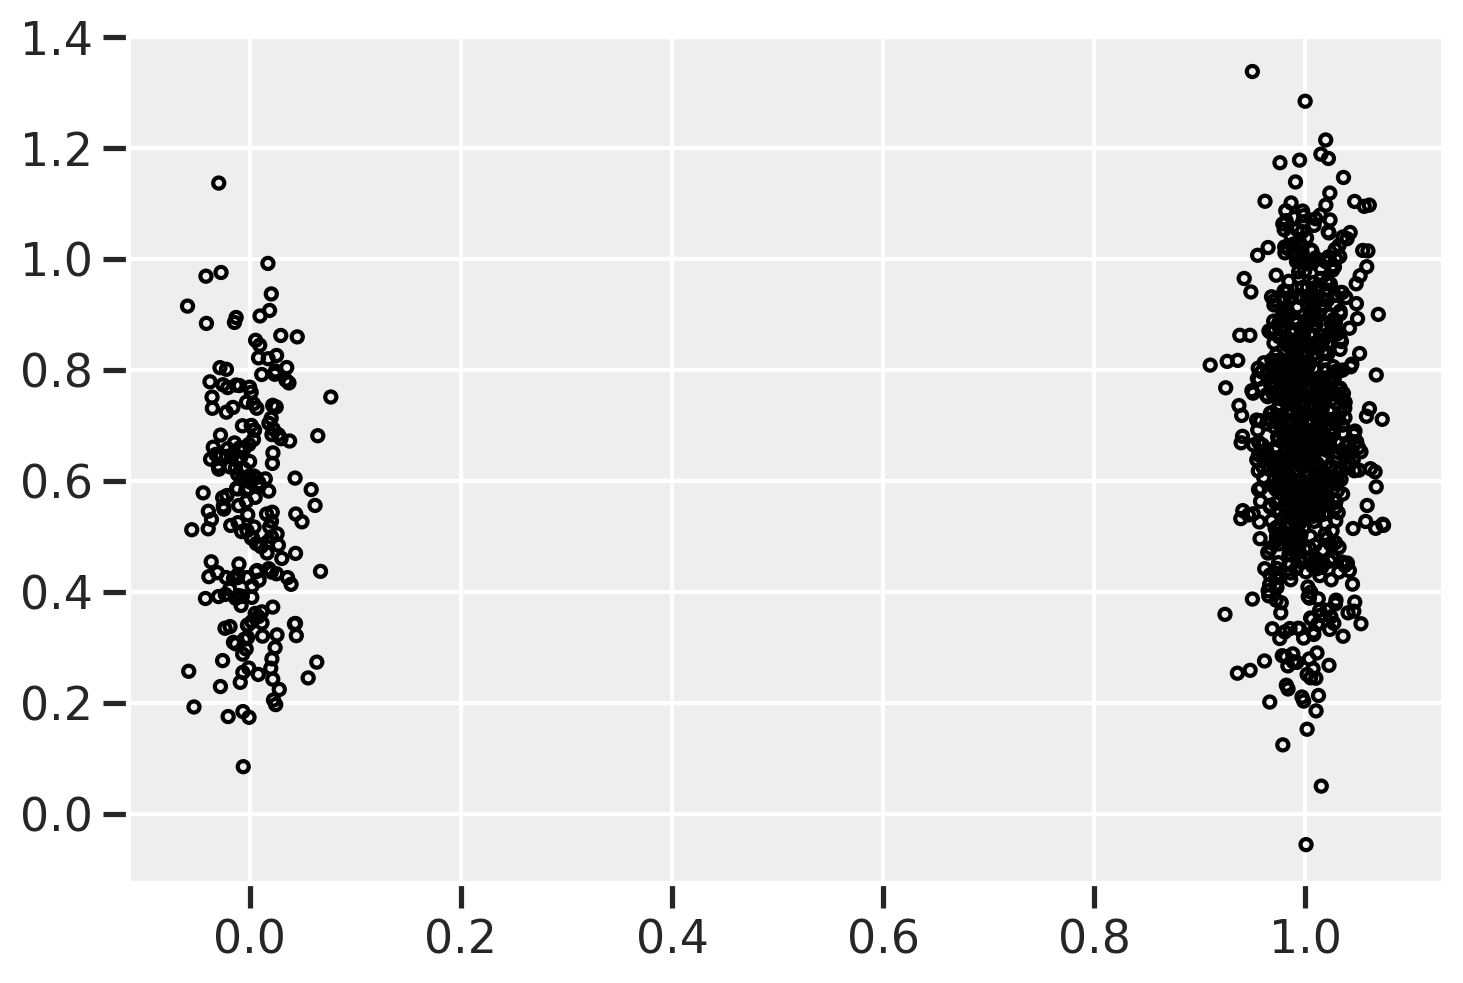

<IPython.core.display.Javascript object>

In [844]:
f, ax0 = plt.subplots()
x_jitter = np.random.normal(0, 0.025, size=len(df_Sim4))
ax0.scatter(df_Sim4['ins_status'] + x_jitter, df_Sim4['mu'], s=2**4, facecolors='none', edgecolors='k')

### Fixed prior, no `patientID`, additive model

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu = \alpha + \beta_{[\text{INS}]} $$
$$ \alpha_j \sim \text{Normal}(0.5, 1.5) $$
$$ \beta_j \sim \text{Normal}(0, 1) $$

In [805]:
df_Sim4.head()

patient_id        mu  ins_status  appt_adhere
0           0  0.552923           1            1
1           0  0.899070           1            1
2           0  0.772475           1            1
3           0  0.854533           1            1
4           0  0.930964           1            1

<IPython.core.display.Javascript object>

In [809]:
df_Sim4.groupby('ins_status').mean()['appt_adhere']

ins_status
0    0.588235
1    0.641960
Name: appt_adhere, dtype: float64

<IPython.core.display.Javascript object>

In [806]:
n_ins = 2

# population intercept only, no patient-specific intercept, fixed prior
with pm.Model() as mSim4Ia:

    # prior for patient_id
    a = pm.Normal("a", 0.5, 1.5)
    b = pm.Normal("b", 0, 1, shape=n_ins)

    p = pm.math.invlogit(a + b[df_Sim4['ins_status']])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim4["appt_adhere"])

    trace_mSim4Ia = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # prior predictive checks
    prior_checks_mSim4Ia = pm.sample_prior_predictive(samples=100)

    # summaries and plotting
    df_summary_mSim4Ia = az.summary(trace_mSim4Ia)
    trace_mSim4Ia_df = pm.trace_to_dataframe(trace_mSim4Ia)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.8927730071017056, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [807]:
df_summary_mSim4Ia

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a     0.526  0.638    -0.657      1.804      0.025    0.020     628.0   511.0   
b[0] -0.166  0.640    -1.497      0.989      0.025    0.021     643.0   474.0   
b[1]  0.059  0.639    -1.175      1.330      0.025    0.020     630.0   515.0   

      ess_bulk  ess_tail  r_hat  
a        641.0     629.0   1.01  
b[0]     655.0     661.0   1.01  
b[1]     641.0     659.0   1.01

<IPython.core.display.Javascript object>

In [819]:
# check both insurance status groups
expit(df_summary_mSim4Ia.loc['a', 'mean'] + df_summary_mSim4Ia.loc['b[0]', 'mean']), expit(df_summary_mSim4Ia.loc['a', 'mean'] + df_summary_mSim4Ia.loc['b[1]', 'mean'])

(0.5890404340586651, 0.6422170929574377)

<IPython.core.display.Javascript object>

### Fixed prior, with patient-specific intercept (non-adaptive prior)

Now we'll introduce the idea of patient-specific averages and see what impact that has on the coefficients for insurance.

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu = \alpha_{\text{patient}} + \beta_{[\text{INS}]} $$
$$ \alpha_j \sim \text{Normal}(0.5, 1.5) $$
$$ \beta_j \sim \text{Normal}(0, 1) $$

In [823]:
df_Sim4.head()

patient_id        mu  ins_status  appt_adhere
0           0  0.552923           1            1
1           0  0.899070           1            1
2           0  0.772475           1            1
3           0  0.854533           1            1
4           0  0.930964           1            1

<IPython.core.display.Javascript object>

In [824]:
n_patients = len(df_Sim4['patient_id'].unique())
n_ins = 2

# patient-specific intercept, fixed prior
with pm.Model() as mSim4Ib:

    # prior for patient_id
    a = pm.Normal("a", 0.5, 1.5, shape=n_patients)
    b = pm.Normal("b", 0, 1, shape=n_ins)

    # link function
    p = pm.math.invlogit(a[df_Sim4['patient_id']] + b[df_Sim4['ins_status']])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim4["appt_adhere"])

    trace_mSim4Ib = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # prior predictive checks
    prior_checks_mSim4Ib = pm.sample_prior_predictive(samples=100)

    # summaries and plotting
    df_summary_mSim4Ib = az.summary(trace_mSim4Ib)
    trace_mSim4Ib_df = pm.trace_to_dataframe(trace_mSim4Ib)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [826]:
df_summary_mSim4Ib.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a[0]  0.457  0.354    -0.210      1.163      0.009    0.007    1432.0  1432.0   
a[1]  0.579  0.355    -0.146      1.241      0.010    0.007    1387.0  1387.0   
a[2]  0.581  0.352    -0.122      1.251      0.010    0.007    1365.0  1365.0   
a[3]  0.480  0.509    -0.540      1.474      0.011    0.008    2097.0  1894.0   
a[4]  0.841  0.381     0.095      1.564      0.010    0.007    1608.0  1608.0   

      ess_bulk  ess_tail  r_hat  
a[0]    1434.0    2510.0    1.0  
a[1]    1397.0    2444.0    1.0  
a[2]    1360.0    2086.0    1.0  
a[3]    2100.0    2482.0    1.0  
a[4]    1611.0    2701.0    1.0

<IPython.core.display.Javascript object>

In [829]:
df_summary_mSim4Ib['pid'] = df_summary_mSim4Ib.index
df_summary_mSim4Ib['pid'] = df_summary_mSim4Ib['pid'].str.split('a\[', expand=True)[1].str.strip('\]')

<IPython.core.display.Javascript object>

In [830]:
df_summary_mSim4Ib = pd.merge(
        df_summary_mSim4Ib.reset_index(),
        s_appt[['n_appts','patient_id_s']],
        how='left',
        left_on='pid',
        right_on='patient_id_s'
    )

df_summary_mSim4Ib.head()

index   mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
0  a[0]  0.457  0.354    -0.210      1.163      0.009    0.007    1432.0   
1  a[1]  0.579  0.355    -0.146      1.241      0.010    0.007    1387.0   
2  a[2]  0.581  0.352    -0.122      1.251      0.010    0.007    1365.0   
3  a[3]  0.480  0.509    -0.540      1.474      0.011    0.008    2097.0   
4  a[4]  0.841  0.381     0.095      1.564      0.010    0.007    1608.0   

   ess_sd  ess_bulk  ess_tail  r_hat pid  n_appts patient_id_s  
0  1432.0    1434.0    2510.0    1.0   0     69.0            0  
1  1387.0    1397.0    2444.0    1.0   1     69.0            1  
2  1365.0    1360.0    2086.0    1.0   2     69.0            2  
3  1894.0    2100.0    2482.0    1.0   3     63.0            3  
4  1608.0    1611.0    2701.0    1.0   4     55.0            4

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'n_appts'),
 Text(0, 0.5, 'SD of estimate'),
 Text(0.5, 1.0, 'Sample size and standard deviation\nof estimate')]

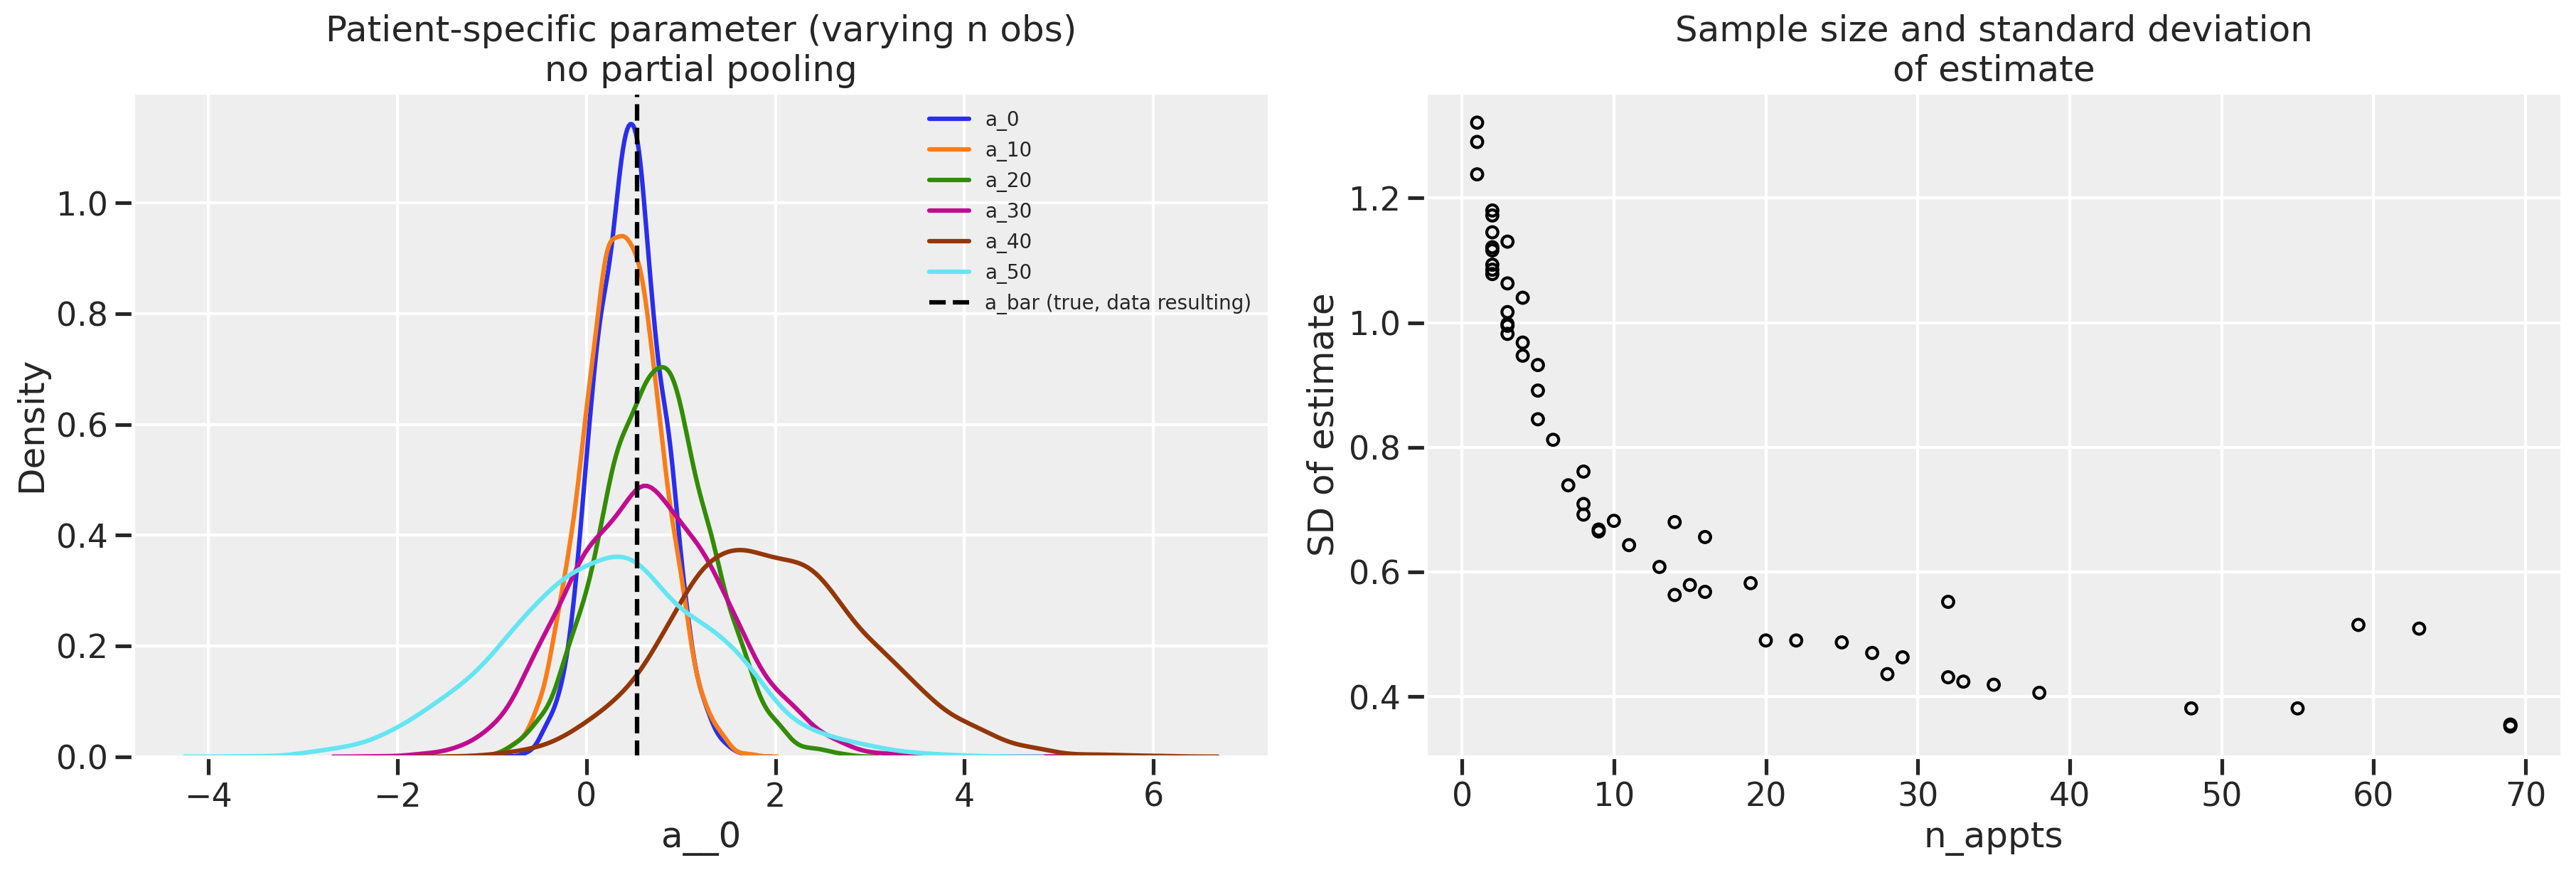

<IPython.core.display.Javascript object>

In [831]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(18,6))

# First plot
for i in range(0, 60, 10):
    sns.kdeplot(trace_mSim4Ib_df[f'a__{i}'], label=f'a_{i}', ax=ax0)
ax0.axvline(logit(df_Sim4['appt_adhere'].mean()), color='black', linestyle='dashed', label='a_bar (true, data resulting)')

ax0.set(title='Patient-specific parameter (varying n obs)\nno partial pooling')
ax0.legend(fontsize=10)

# Second plot
ax1.scatter(df_summary_mSim4Ib['n_appts'], df_summary_mSim4Ib['sd'], s=2**5, facecolors='none', edgecolors='k')
ax1.set(xlabel='n_appts', ylabel='SD of estimate', title='Sample size and standard deviation\nof estimate')

In [833]:
az.summary(trace_mSim4Ia, var_names='b')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
b[0] -0.166  0.640    -1.497      0.989      0.025    0.021     643.0   474.0   
b[1]  0.059  0.639    -1.175      1.330      0.025    0.020     630.0   515.0   

      ess_bulk  ess_tail  r_hat  
b[0]     655.0     661.0   1.01  
b[1]     641.0     659.0   1.01

<IPython.core.display.Javascript object>

In [832]:
az.summary(trace_mSim4Ib, var_names='b')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
b[0] -0.052  0.451    -0.929      0.828      0.010    0.007    1894.0  1842.0   
b[1]  0.058  0.256    -0.421      0.555      0.009    0.006     837.0   837.0   

      ess_bulk  ess_tail  r_hat  
b[0]    1892.0    2138.0    1.0  
b[1]     842.0    1371.0    1.0

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'contrast\n(private-public)')]

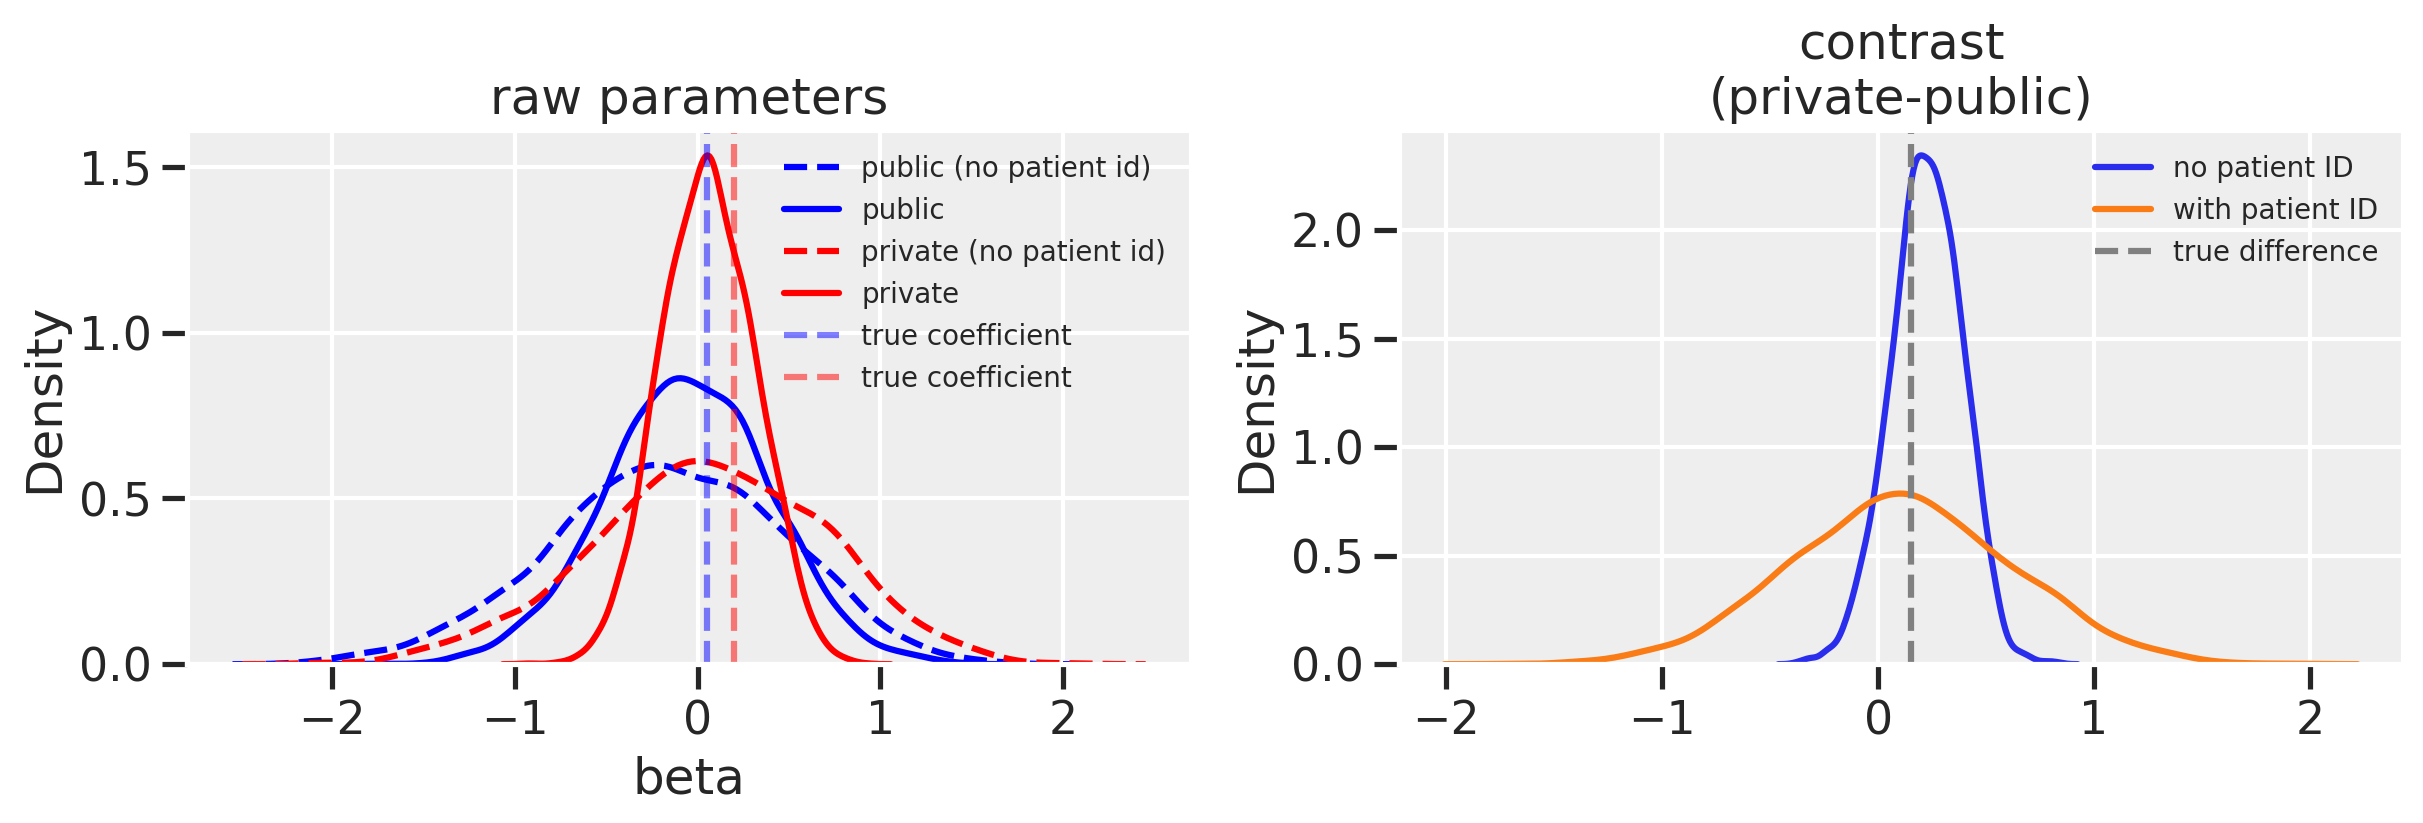

<IPython.core.display.Javascript object>

In [853]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
# raw values
sns.kdeplot(trace_mSim4Ia_df['b__0'], c='blue', linestyle='dashed', label='public (no patient id)', ax=ax0)
sns.kdeplot(trace_mSim4Ib_df['b__0'], c='blue', label='public', ax=ax0)
sns.kdeplot(trace_mSim4Ia_df['b__1'], c='red', linestyle='dashed', label='private (no patient id)', ax=ax0)
sns.kdeplot(trace_mSim4Ib_df['b__1'], c='red', label='private', ax=ax0)

ax0.axvline(b0, linestyle='dashed', alpha=0.5, color='blue', label='true coefficient')
ax0.axvline(b1, linestyle='dashed', alpha=0.5, color='red', label='true coefficient')
ax0.legend(fontsize=10)
ax0.set(xlabel='beta', title='raw parameters')

# contrast
sns.kdeplot((trace_mSim4Ia_df['b__1'] - trace_mSim4Ia_df['b__0']), label='no patient ID', ax=ax1)
sns.kdeplot((trace_mSim4Ib_df['b__1'] - trace_mSim4Ib_df['b__0']), label='with patient ID', ax=ax1)
ax1.axvline(0.15, linestyle='dashed', color='gray', label='true difference')
ax1.legend(fontsize=10)
ax1.set(title='contrast\n(private-public)')


**The patient ID makes the estimate in beta coefficients more uncertain.**

### Adaptive prior, with patient-specific intercept (no pooling on insurance yet)

The adaptive prior (partial pooling) approach in theory lets us get a population average back. We can contrast this with the earlier models.

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu = \alpha_{\text{patient}} + \beta_{[\text{INS}]} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) $$
$$ \sigma_{\alpha} \sim \text{Exp}(1) $$
$$ \bar{\alpha} \sim \text{Normal}(0.5, 1.5) $$
$$ \beta_j \sim \text{Normal}(0, 1) $$

In [856]:
df_Sim4.head()

patient_id        mu  ins_status  appt_adhere
0           0  0.552923           1            1
1           0  0.899070           1            1
2           0  0.772475           1            1
3           0  0.854533           1            1
4           0  0.930964           1            1

<IPython.core.display.Javascript object>

In [866]:
n_patients = len(df_Sim4['patient_id'].unique())
n_ins = 2

# patient-specific intercept, adaptive prior
with pm.Model() as mSim4Ic:

    # adaptive priors
    a_bar = pm.Normal("a_bar", 0.5, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    a = pm.Normal("a", a_bar, sigma_a, shape=n_patients)
    b = pm.Normal("b", 0, 1, shape=n_ins)

    # link functionƒ˙
    p = pm.math.invlogit(a[df_Sim4['patient_id']] + b[df_Sim4['ins_status']])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim4["appt_adhere"])

    trace_mSim4Ic = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=False
    )

    # summaries and plotting
    df_summary_mSim4Ic = az.summary(trace_mSim4Ic)
    trace_mSim4Ic_df = pm.trace_to_dataframe(trace_mSim4Ic)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_a, a_bar]
INFO:pymc3:NUTS: [b, a, sigma_a, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 862 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 862 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.21616318517265795, but should be close to 0.8. Try to increase the number of tuning steps.
There were 221 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There wer

<IPython.core.display.Javascript object>

In [867]:
df_summary_mSim4Ic.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar  0.549  0.724    -0.547      1.484      0.318    0.239       5.0   
a[0]   0.539  0.727    -0.611      1.563      0.316    0.237       5.0   
a[1]   0.564  0.736    -0.618      1.567      0.321    0.241       5.0   
a[2]   0.558  0.731    -0.575      1.571      0.318    0.239       5.0   
a[3]   0.564  0.732    -0.585      1.581      0.319    0.239       5.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a_bar     5.0       6.0      40.0   1.86  
a[0]      5.0       6.0      50.0   1.82  
a[1]      5.0       6.0      41.0   1.85  
a[2]      5.0       6.0      43.0   1.82  
a[3]      5.0       6.0      48.0   1.83

<IPython.core.display.Javascript object>

The `r_hat` values look horrible so I'll re-paramaterize.


$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \bar{\alpha} + z \times \sigma_{\alpha} + \beta_{[\text{INS}]} $$
$$ z \sim \text{Normal}(0,1) $$
$$ \sigma_{\alpha} \sim \text{Exp}(1) $$
$$ \bar{\alpha} \sim \text{Normal}(0.5, 1.5) $$
$$ \beta_j \sim \text{Normal}(0, 1) $$

In [868]:
n_patients = len(df_Sim4['patient_id'].unique())
n_ins = 2

# patient-specific intercept, adaptive prior, non-centered
with pm.Model() as mSim4Id:

    # adaptive priors
    a_bar = pm.Normal("a_bar", 0.5, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # for non-centering
    z = pm.Normal("z", 0, 1, shape=n_patients)

    # prior for patient_id
    a = pm.Deterministic("a", a_bar + z * sigma_a)
    b = pm.Normal("b", 0, 1, shape=n_ins)

    # link function
    p = pm.math.invlogit(a[df_Sim4['patient_id']] + b[df_Sim4['ins_status']])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim4["appt_adhere"])

    trace_mSim4Id = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=True
    )

    # summaries and plotting
    df_summary_mSim4Id = az.summary(trace_mSim4Id)
    trace_mSim4Id_df = pm.trace_to_dataframe(trace_mSim4Id)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, z, sigma_a, a_bar]
INFO:pymc3:NUTS: [b, z, sigma_a, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


<IPython.core.display.Javascript object>

In [869]:
df_summary_mSim4Id.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar  0.480  0.636    -0.722      1.785      0.013    0.009    2537.0   
z[0]  -0.089  0.964    -1.980      1.834      0.013    0.015    5371.0   
z[1]   0.031  0.980    -1.948      1.902      0.012    0.017    6467.0   
z[2]   0.042  0.944    -1.841      1.827      0.012    0.019    6449.0   
z[3]   0.032  0.961    -1.857      1.881      0.010    0.018    8458.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a_bar  2537.0    2544.0    2876.0    1.0  
z[0]   1977.0    5382.0    3049.0    1.0  
z[1]   1581.0    6484.0    2838.0    1.0  
z[2]   1230.0    6460.0    2897.0    1.0  
z[3]   1424.0    8499.0    3178.0    1.0

<IPython.core.display.Javascript object>

In [870]:
df_summary_mSim4Id.tail()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
a[52]  0.476  0.644    -0.835      1.695      0.013    0.009    2563.0   
a[53]  0.477  0.643    -0.792      1.729      0.013    0.009    2609.0   
a[54]  0.486  0.641    -0.747      1.784      0.013    0.009    2599.0   
a[55]  0.485  0.644    -0.780      1.742      0.013    0.009    2570.0   
a[56]  0.474  0.644    -0.722      1.799      0.013    0.009    2521.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
a[52]  2563.0    2565.0    2792.0    1.0  
a[53]  2609.0    2622.0    2921.0    1.0  
a[54]  2599.0    2609.0    2834.0    1.0  
a[55]  2570.0    2582.0    2856.0    1.0  
a[56]  2521.0    2529.0    2827.0    1.0

<IPython.core.display.Javascript object>

In [872]:
az.summary(trace_mSim4Id, var_names=['b', 'sigma_a'])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
b[0]    -0.113  0.636    -1.327      1.163      0.013    0.009    2530.0   
b[1]     0.103  0.637    -1.141      1.362      0.013    0.009    2567.0   
sigma_a  0.074  0.058     0.000      0.187      0.001    0.001    3131.0   

         ess_sd  ess_bulk  ess_tail  r_hat  
b[0]     2530.0    2539.0    2901.0    1.0  
b[1]     2456.0    2576.0    2880.0    1.0  
sigma_a  3131.0    2101.0    1829.0    1.0

<IPython.core.display.Javascript object>

### Adaptive prior, pooling on patient-specific intercept and pooling on insurance

The adaptive prior (partial pooling) approach in theory lets us get a population average back. We can contrast this with the earlier models.

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \bar{\alpha} + z_\alpha \times \sigma_{\alpha} + z_\beta \times \sigma_{\beta} $$
$$ z_\alpha, z_\beta \sim \text{Normal}(0,1) $$
$$ \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) $$
$$ \bar{\alpha} \sim \text{Normal}(0.5, 1.5) $$
$$ \beta_j \sim \text{Normal}(0, 1) $$

In [ ]:
n_patients = len(df_Sim4['patient_id'].unique())
n_ins = 2

# patient-specific intercept, adaptive prior, non-centered
with pm.Model() as mSim4Ie:

    # adaptive priors
    a_bar = pm.Normal("a_bar", 0.5, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1)
    sigma_b = pm.Exponential("sigma_b", 1)

    # for non-centering
    z_a = pm.Normal("z_a", 0, 1, shape=n_patients)
    z_b = pm.Normal("z_b", 0, 1, shape=n_ins)

    # prior for patient_id
    a = pm.Deterministic("a", a_bar + z_a * sigma_a)
    b = pm.Deterministic("b", z_b * sigma_b)

    # link function
    p = pm.math.invlogit(a[df_Sim4['patient_id']] + b[df_Sim4['ins_status']])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_Sim4["appt_adhere"])

    trace_mSim4Ie = pm.sample(
        draws=1000, return_inferencedata=False, progressbar=True
    )

    # summaries and plotting
    df_summary_mSim4Ie = az.summary(trace_mSim4Ie)
    trace_mSim4Ie_df = pm.trace_to_dataframe(trace_mSim4Ie)

In [ ]:
test

# Dataset with different individuals and two characteristics

In [17]:
# create patient ids
pid = np.concatenate([[i] * np.random.randint(1, 10) for i in range(6)])
# assign jobs
jobs = ["teacher", "driver", "cook"]
occ = list()
for id in range(len(pid)):
    job = np.random.choice(jobs)
    occ += [job] * (pid == id).sum()

# assign insurance
ins = ["private", "public"]
ins_type = list()
for id in range(len(pid)):
    ins_type += [np.random.choice(ins)] * (pid == id).sum()

# assign adherence which is a function of occupation and insurance type
b_jobs_sim = {"teacher": 0.75, "driver": 0.5, "cook": 0.25}
b_ins_sim = {"private": 1, "public": 0.5}
mu = np.array([b_jobs_sim[job] for job in occ]) + np.array(
    [b_ins_sim[i] for i in ins_type]
)
a = stats.binom.rvs(n=1, p=expit(mu))


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


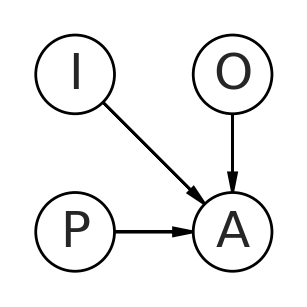

<IPython.core.display.Javascript object>

In [43]:
dag = CausalGraphicalModel(
    nodes=["P", "I", "O", "A"],
    edges=[
        ("P", "A"),
        ("I", "A"),
        ("O", "A"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "P": (0, 0),
    "I": (0, 1),
    "O": (1, 1),
    "A": (1, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)

pgm.render()


In [19]:
df_example = pd.DataFrame(
    {
        "patient_id": pid,
        "occupation": occ,
        "insurance": ins_type,
        "mu": expit(mu),
        "adherence": a,
    }
)
df_example


patient_id occupation insurance        mu  adherence
0            0       cook   private  0.777300          1
1            0       cook   private  0.777300          1
2            0       cook   private  0.777300          0
3            0       cook   private  0.777300          1
4            0       cook   private  0.777300          1
5            1       cook   private  0.777300          1
6            1       cook   private  0.777300          1
7            1       cook   private  0.777300          1
8            2       cook   private  0.777300          0
9            2       cook   private  0.777300          1
10           2       cook   private  0.777300          0
11           2       cook   private  0.777300          0
12           2       cook   private  0.777300          1
13           2       cook   private  0.777300          1
14           2       cook   private  0.777300          1
15           2       cook   private  0.777300          1
16           2       cook   private  0.777300          0
17           3     driver    public  0.731059          1
18           3     driver    public  0.731059          1
19           4       cook    public  0.679179          1
20           4       cook    public  0.679179          1
21           4       cook    public  0.679179          1
22           4       cook    public  0.679179          1
23           4       cook    public  0.679179          1
24           4       cook    public  0.679179          0
25           4       cook    public  0.679179          0
26           4       cook    public  0.679179          1
27           5    teacher    public  0.777300          1
28           5    teacher    public  0.777300          1
29           5    teacher    public  0.777300          0
30           5    teacher    public  0.777300          1
31           5    teacher    public  0.777300          1
32           5    teacher    public  0.777300          1
33           5    teacher    public  0.777300          0
34           5    teacher    public  0.777300          0

<IPython.core.display.Javascript object>

<center>
Model 1
</center>
<br>

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{occ}} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ \sigma \sim \text{Exponential}(1) $$

Questions
- Let's assume the estimand is the effect of occupation on adherence. How do I deal with repeated observations from a given patient? Some patients have more appointments than others. Some patients have more appointments than others and so there will be variability in the occupations represented.
    - Put an alpha parameter for each patient id. `Sigma` will be like an encapsulation of all the variation not explained by other parameters. That is model 1b.
- If I had another column (insurance type).
    - Is insurance treated as another cluster or is it a feature of the patient cluster?
- Should I pool treatments?
    - If they have the same prior, then it's usually better to learn the prior from the sample and partially pool.

- When adding features within a cluster, you'd want to use one population prior but expand dimensionality (e.g. using a MVN prior).

Let's look at a few models:
- insurance only (fixed prior)
- patient only (heirarchical)
- patient (heirarchical) and insurance( fixed)
- patient (heirarchical), insurance( f), job(f)

<center>
Model 1
</center>

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \gamma_{\text{ins}} $$
$$ \gamma_j \sim \text{Normal}(0, 1.5) $$
<br>

<center>
Model 2
</center>

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ \sigma \sim \text{Exponential}(1) $$
<br>

<center>
Model 3
</center>

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} + \gamma_{\text{ins}} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \gamma_j \sim \text{Normal}(0, 1.5) $$

<br>
<center>
Model 4
</center>

$$ A \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \alpha_{\text{patient}} + \gamma_{\text{ins}} + \delta_{\text{occ}} $$
$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) $$
$$ \bar{\alpha} \sim \text{Normal}(0, 1.5) $$
$$ \sigma \sim \text{Exponential}(1) $$
$$ \gamma_j \sim \text{Normal}(0, 1.5) $$
$$ \delta_k \sim \text{Normal}(0, 1.5) $$

In [22]:
df_example["ins_code"] = pd.Categorical(df_example["insurance"]).codes
df_example.head()


patient_id occupation insurance      mu  adherence  occ_code  ins_code
0           0       cook   private  0.7773          1         0         0
1           0       cook   private  0.7773          1         0         0
2           0       cook   private  0.7773          0         0         0
3           0       cook   private  0.7773          1         0         0
4           0       cook   private  0.7773          1         0         0

<IPython.core.display.Javascript object>

In [23]:
df_example["ins_code"].unique()


array([0, 1], dtype=int8)

<IPython.core.display.Javascript object>

In [25]:
# insurance only
with pm.Model() as mSim1:

    # fixed prior for insurance
    g = pm.Normal("g", 0.0, 1.5, shape=2)

    # link function
    p = pm.math.invlogit(g[df_example["ins_code"]])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_example["adherence"])

    trace_mSim1 = pm.sample(
        draws=1000,
        random_seed=19,
        return_inferencedata=False,
        progressbar=False,
        target_accept=0.95,
    )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g]
INFO:pymc3:NUTS: [g]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [28]:
az.summary(trace_mSim1)


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
g[0]  0.810  0.489    -0.107      1.781      0.009    0.007    2781.0  2382.0   
g[1]  0.915  0.517    -0.072      1.965      0.011    0.009    2162.0  1846.0   

      ess_bulk  ess_tail  r_hat  
g[0]    2801.0    2202.0    1.0  
g[1]    2192.0    1914.0    1.0

<IPython.core.display.Javascript object>

In [27]:
df_example.head()


patient_id occupation insurance      mu  adherence  occ_code  ins_code
0           0       cook   private  0.7773          1         0         0
1           0       cook   private  0.7773          1         0         0
2           0       cook   private  0.7773          0         0         0
3           0       cook   private  0.7773          1         0         0
4           0       cook   private  0.7773          1         0         0

<IPython.core.display.Javascript object>

In [29]:
n_patient = len(df_example["patient_id"].unique())

# patientid only, heirarchical
with pm.Model() as mSim2:

    # heirarchical prior for patient_iid
    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    a = pm.Normal("a", a_bar, sigma_a, shape=n_patient)

    # link function
    p = pm.math.invlogit(a[df_example["patient_id"]])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_example["adherence"])

    trace_mSim2 = pm.sample(
        draws=1000,
        random_seed=19,
        return_inferencedata=False,
        progressbar=False,
        target_accept=0.95,
    )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma_a, a_bar]
INFO:pymc3:NUTS: [a, sigma_a, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5900351481432856, but should be close to 0.95. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 30 di

<IPython.core.display.Javascript object>

In [30]:
az.summary(trace_mSim2)


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar    1.006  0.465     0.113      1.873      0.020    0.014     530.0   
a[0]     1.083  0.581    -0.074      2.232      0.020    0.014     852.0   
a[1]     1.238  0.783    -0.097      2.914      0.028    0.020     787.0   
a[2]     0.781  0.534    -0.339      1.667      0.066    0.051      65.0   
a[3]     1.190  0.763    -0.213      2.632      0.027    0.019     788.0   
a[4]     1.056  0.533    -0.073      2.046      0.019    0.013     813.0   
a[5]     0.881  0.520    -0.213      1.807      0.043    0.031     143.0   
sigma_a  0.483  0.445     0.038      1.320      0.066    0.047      46.0   

         ess_sd  ess_bulk  ess_tail  r_hat  
a_bar     530.0     493.0    1113.0   1.02  
a[0]      852.0     747.0    1672.0   1.01  
a[1]      787.0     743.0    1084.0   1.06  
a[2]       56.0      64.0    1322.0   1.05  
a[3]      788.0     727.0     685.0   1.04  
a[4]      813.0     703.0    1738.0   1.01  
a[5]      143.0     129.0    1661.0   1.03  
sigma_a    46.0      15.0      13.0   1.19

<IPython.core.display.Javascript object>

In [36]:
n_patient = len(df_example["patient_id"].unique())

# patientid only, heirarchical
with pm.Model() as mSim2nc:

    # heirarchical prior for patient_id
    a_bar = pm.Normal("a_bar", 0, 1.5)

    z = pm.Normal("z", 0, 1, shape=n_patient)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    # a = pm.Normal("a", a_bar, sigma_a, shape=n_patient)   # centered version
    a = pm.Deterministic("a", a_bar + z * sigma_a)

    # link function
    p = pm.math.invlogit(a[df_example["patient_id"]])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_example["adherence"])

    trace_mSim2nc = pm.sample(
        draws=1000,
        random_seed=19,
        return_inferencedata=False,
        progressbar=False,
        target_accept=0.95,
    )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, z, a_bar]
INFO:pymc3:NUTS: [sigma_a, z, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [40]:
az.summary(trace_mSim2nc, var_names="~z")


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar    0.956  0.458     0.124      1.919      0.009    0.007    2418.0   
sigma_a  0.503  0.468     0.000      1.415      0.011    0.008    1935.0   
a[0]     1.037  0.606    -0.064      2.266      0.010    0.008    3845.0   
a[1]     1.214  0.796    -0.160      2.858      0.016    0.012    2617.0   
a[2]     0.732  0.496    -0.295      1.702      0.007    0.006    4449.0   
a[3]     1.167  0.787    -0.237      2.759      0.014    0.011    2963.0   
a[4]     0.990  0.510     0.052      2.039      0.008    0.006    4603.0   
a[5]     0.828  0.518    -0.136      1.948      0.008    0.006    4729.0   

         ess_sd  ess_bulk  ess_tail  r_hat  
a_bar    2043.0    2593.0    1904.0    1.0  
sigma_a  1935.0    1844.0    2129.0    1.0  
a[0]     3208.0    4048.0    3359.0    1.0  
a[1]     2124.0    3276.0    2394.0    1.0  
a[2]     3610.0    4393.0    2857.0    1.0  
a[3]     2545.0    3468.0    2833.0    1.0  
a[4]     3882.0    4747.0    3199.0    1.0  
a[5]     3770.0    4853.0    3220.0    1.0

<IPython.core.display.Javascript object>

In [31]:
# patientid and insurance
with pm.Model() as mSim3:

    # heirarchical prior for patient id
    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    a = pm.Normal("a", a_bar, sigma_a, shape=n_patient)

    # fixed prior for insurance
    g = pm.Normal("g", 0.0, 1.5, shape=2)

    # link function
    p = pm.math.invlogit(a[df_example["patient_id"]] + g[df_example["ins_code"]])

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_example["adherence"])

    trace_mSim3 = pm.sample(
        draws=1000,
        random_seed=19,
        return_inferencedata=False,
        progressbar=False,
        target_accept=0.95,
    )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, a, sigma_a, a_bar]
INFO:pymc3:NUTS: [g, a, sigma_a, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8909841912079743, b

<IPython.core.display.Javascript object>

In [32]:
az.summary(trace_mSim3)


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_mean  \
a_bar    0.669  0.901    -1.127      2.473      0.045    0.032     402.0   
a[0]     0.780  1.061    -1.396      2.817      0.049    0.035     472.0   
a[1]     0.987  1.194    -1.276      3.317      0.056    0.039     460.0   
a[2]     0.358  0.985    -1.553      2.294      0.045    0.032     469.0   
a[3]     0.937  1.239    -1.509      3.233      0.057    0.040     474.0   
a[4]     0.718  1.006    -1.387      2.551      0.046    0.032     484.0   
a[5]     0.480  0.993    -1.369      2.519      0.046    0.033     465.0   
g[0]     0.350  0.979    -1.520      2.333      0.045    0.032     473.0   
g[1]     0.361  0.969    -1.547      2.120      0.044    0.031     474.0   
sigma_a  0.635  0.544     0.069      1.731      0.030    0.021     330.0   

         ess_sd  ess_bulk  ess_tail  r_hat  
a_bar     402.0     400.0     435.0   1.01  
a[0]      472.0     463.0     491.0   1.01  
a[1]      460.0     432.0     456.0   1.01  
a[2]      469.0     467.0     639.0   1.01  
a[3]      474.0     450.0     497.0   1.01  
a[4]      484.0     478.0     556.0   1.01  
a[5]      465.0     462.0     623.0   1.01  
g[0]      473.0     473.0     668.0   1.01  
g[1]      474.0     474.0    1022.0   1.01  
sigma_a   330.0     224.0     185.0   1.01

<IPython.core.display.Javascript object>

In [49]:
df_example["occ_code"] = pd.Categorical(df_example["occupation"]).codes
df_example.head()

n_ins = len(df_example["ins_code"].unique())
n_occ = len(df_example["occ_code"].unique())


<IPython.core.display.Javascript object>

In [52]:
# patientid and insurance
with pm.Model() as mSim4nc:

    # heirarchical prior for patient_id
    a_bar = pm.Normal("a_bar", 0, 1.5)

    z = pm.Normal("z", 0, 1, shape=n_patient)
    sigma_a = pm.Exponential("sigma_a", 1)

    # prior for patient_id
    # a = pm.Normal("a", a_bar, sigma_a, shape=n_patient)   # centered version
    a = pm.Deterministic("a", a_bar + z * sigma_a)

    # fixed prior for insurance, occupation
    g = pm.Normal("g", 0.0, 1.5, shape=n_ins)
    d = pm.Normal("d", 0.0, 1.5, shape=n_occ)

    # link function
    p = pm.math.invlogit(
        a[df_example["patient_id"]]
        + g[df_example["ins_code"]]
        + d[df_example["occ_code"]]
    )

    # likelihood
    A = pm.Bernoulli("A", p=p, observed=df_example["adherence"])

    trace_mSim4nc = pm.sample(
        draws=1000,
        random_seed=19,
        return_inferencedata=False,
        progressbar=False,
        target_accept=0.95,
    )


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, g, sigma_a, z, a_bar]
INFO:pymc3:NUTS: [d, g, sigma_a, z, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


<IPython.core.display.Javascript object>

In [56]:
az.compare(
    {
        "ins only": trace_mSim1,
        "patient only, centered": trace_mSim2,
        "patient only, non-centered": trace_mSim2nc,
        "ins + patient": trace_mSim3,
        "ins + patient + occupation": trace_mSim4nc,
    },
    ic="loo",
)


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/blacar/opt/anaconda3/en

rank        loo     p_loo     d_loo        weight  \
patient only, non-centered     0 -22.374123  2.005743  0.000000  1.000000e+00   
patient only, centered         1 -22.463653  2.094190  0.089530  1.375289e-14   
ins only                       2 -22.830595  1.860344  0.456472  0.000000e+00   
ins + patient                  3 -23.358177  3.123838  0.984054  0.000000e+00   
ins + patient + occupation     4 -23.797574  3.834274  1.423451  0.000000e+00   

                                  se       dse  warning loo_scale  
patient only, non-centered  2.514161  0.000000    False       log  
patient only, centered      2.650797  0.146255    False       log  
ins only                    2.457318  0.375506    False       log  
ins + patient               2.734794  0.275397    False       log  
ins + patient + occupation  2.843867  0.537456    False       log

<IPython.core.display.Javascript object>

In [35]:
az.summary(trace_mSim1)["mean"]


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


g[0]    0.810
g[1]    0.915
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [34]:
az.summary(trace_mSim2)["mean"]


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


a_bar      1.006
a[0]       1.083
a[1]       1.238
a[2]       0.781
a[3]       1.190
a[4]       1.056
a[5]       0.881
sigma_a    0.483
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

In [33]:
az.summary(trace_mSim3)["mean"]


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


a_bar      0.669
a[0]       0.780
a[1]       0.987
a[2]       0.358
a[3]       0.937
a[4]       0.718
a[5]       0.480
g[0]       0.350
g[1]       0.361
sigma_a    0.635
Name: mean, dtype: float64

<IPython.core.display.Javascript object>

# Appendix: Discovery of `pymc` bug

While working on the above post, I discovered a weird bug that I've narrowed down to `pymc` affecting the behavior of functions outside `pymc`.

In [4]:
for i in range(5):
    print(f" --- loop {i} --- ", end='\n')
    test_vals = stats.norm.rvs(loc=1, scale=1, size=5)
    print(test_vals, end='\n\n')

 --- loop 0 --- 
[ 2.78781918  0.20696795 -0.47400206  2.25240217 -0.30937806]

 --- loop 1 --- 
[ 1.50876659  1.8221553  -1.20705219 -0.84927821 -0.8085355 ]

 --- loop 2 --- 
[1.69489455 0.88016133 0.36331002 1.06086608 0.66051196]

 --- loop 3 --- 
[2.00567726 2.87549063 0.62016998 1.34740385 1.00873457]

 --- loop 4 --- 
[ 1.10582285  0.56149565 -0.45163869  1.90397246  3.30575103]



In [5]:
for i in range(5):
    print(f" --- loop{i} --- ", end='\n')
    test_vals = stats.norm.rvs(loc=2, scale=1, size=5)
    print(test_vals, end='\n')

    with pm.Model() as mS:
        dummy = pm.Normal("dummy", 0, 0.5)
        trace_test = pm.sample(
            draws=100, random_seed=None, return_inferencedata=False, progressbar=False
        )

        

Only 100 samples in chain.


 --- loop0 --- 
[2.80274505 2.58392764 0.66411826 3.68247745 0.65144538]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


 --- loop1 --- 
[0.67536384 1.72740423 2.02626766 3.12547542 1.55755134]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8787, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


 --- loop2 --- 
[1.81629014 1.93631693 2.71444791 1.445055   2.36539921]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8892, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


 --- loop3 --- 
[1.62564    1.81547907 2.7349837  2.79065454 2.51750992]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


 --- loop4 --- 
[2.55248326 1.64696853 0.92084814 1.40946193 2.93765212]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.894, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849, but should be close to 0.8. Try to increase the number of tuning steps.


In [17]:
import numpy as np
import arviz as az

AttributeError: 'MultiTrace' object has no attribute 'head'

### Workaround

See if random_seed has been set. If it has, go back to it. If it hasn't, then reset it to none.

In [19]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

<IPython.core.display.Javascript object>

In [20]:
for i in range(5):
    print(f" --- loop{i} --- ", end='\n')
    test_vals = stats.norm.rvs(loc=1, scale=1, size=5)
    print(test_vals)

 --- loop0 --- 
[ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]
 --- loop1 --- 
[-0.37764807  3.17794384 -1.13254124  1.45146367  1.1294516 ]
 --- loop2 --- 
[0.67051385 0.6102896  2.96706129 1.78099003 1.06009008]
 --- loop3 --- 
[0.93950003 0.64521987 1.673507   1.08672537 1.20135155]
 --- loop4 --- 
[1.90553869 0.3597762  0.76616615 0.6856797  1.6481792 ]


<IPython.core.display.Javascript object>

In [25]:
st0 = np.random.get_state()
st0

('MT19937',
 array([1212928276, 2462041202, 4114273168, 1579687873, 2914973643,
        1197817892,  760979376, 3573439821, 1796331844, 3861268332,
        1113386233, 3281182238, 1994017031, 2947981007, 3074178140,
        2604474050, 1502771022, 4212954285, 1006592875, 1000936541,
        3060251119, 1596485283,  167117810,  351946742,  351119436,
         108010669, 3158788154,  142698966,  874821349, 2974477913,
         197004725, 3704641404, 2787802860,  202868452,  101412085,
        1777277994, 4082250746, 3406026991, 2957309309, 4108700822,
         222420702, 2662617268, 1509807096, 4145559755,  588997395,
         998569097, 2547742732, 3034940299, 2773052630, 3510896452,
        3157794291, 2193478447,  829213730, 2825291289,  957626997,
        1576356457, 2885480146, 1030035325, 1883345433, 1682128734,
        4020218255, 1881933675,  781868973, 1145952200, 2089378884,
        2651691809, 3907822780, 2308534529,  886961366, 2868219854,
         183822456, 1308350605, 1315

<IPython.core.display.Javascript object>

In [23]:
for i in range(5):
    print(f" --- loop{i} --- ", end='\n')
    test_vals = stats.norm.rvs(loc=1, scale=1, size=5)
    print(test_vals)

 --- loop0 --- 
[1.1174869  1.40834446 0.71733043 0.37483326 1.6186118 ]
 --- loop1 --- 
[0.52220247 0.81642544 0.31780039 1.38226964 0.32634686]
 --- loop2 --- 
[ 0.6323248   1.74261167  0.90925701  0.85329919 -0.09032818]
 --- loop3 --- 
[ 0.23089386  1.46133259  0.36951161 -0.27550124  2.88205622]
 --- loop4 --- 
[ 2.93472161 -1.04716187  0.54609181  2.79029219  1.27692083]


<IPython.core.display.Javascript object>

('MT19937',
 array([1212928276, 2462041202, 4114273168, 1579687873, 2914973643,
        1197817892,  760979376, 3573439821, 1796331844, 3861268332,
        1113386233, 3281182238, 1994017031, 2947981007, 3074178140,
        2604474050, 1502771022, 4212954285, 1006592875, 1000936541,
        3060251119, 1596485283,  167117810,  351946742,  351119436,
         108010669, 3158788154,  142698966,  874821349, 2974477913,
         197004725, 3704641404, 2787802860,  202868452,  101412085,
        1777277994, 4082250746, 3406026991, 2957309309, 4108700822,
         222420702, 2662617268, 1509807096, 4145559755,  588997395,
         998569097, 2547742732, 3034940299, 2773052630, 3510896452,
        3157794291, 2193478447,  829213730, 2825291289,  957626997,
        1576356457, 2885480146, 1030035325, 1883345433, 1682128734,
        4020218255, 1881933675,  781868973, 1145952200, 2089378884,
        2651691809, 3907822780, 2308534529,  886961366, 2868219854,
         183822456, 1308350605, 1315

<IPython.core.display.Javascript object>

In [33]:
np.random.seed(None)
stNone = np.random.get_state()
stNone

('MT19937',
 array([2147483648, 1974017895, 2812851234, 1191642421,  141477516,
        2324089784, 4056510387, 3680168920,  447953025, 3447085720,
        3614121153, 4238870394, 1054642398,  244984900,  950107963,
         437304882, 3064099056,  406490036, 3292763401, 1285099499,
        1959095911, 3465937768, 4124258537, 4138995574, 3511542207,
        1606834024, 2576001504, 2453185322, 4090246926, 1219627564,
        3261671219, 1546964310, 1833166673, 1827618209, 2947224481,
        2047945891, 2112153222,  186584737, 2232913901, 1601334896,
         812004564, 1756071621,  322269471,  264866715, 2649392488,
        1294932593,  893833564, 1112009445, 3247448386,  277908126,
         544355768,   44204880, 2963168188, 3271291013, 1511041450,
        2503882108,  959590464, 3190817054, 1631339990, 3093170124,
        3672380326, 4192720121, 2340351652, 2652686846, 1591534158,
         585912098,  761696236, 1890010517, 3701973317, 2913914256,
         825813058, 3586298432, 2752

<IPython.core.display.Javascript object>

In [30]:
np.random.seed(1)
st1 = np.random.get_state()
st1

('MT19937',
 array([         1, 1812433254, 3713160357, 3109174145,   64984499,
        3392658084,  446538473, 2629760756, 2453345558, 1394803949,
        1021787430, 2063496713, 1304877364, 1713639158,  889001601,
        1651239412, 1450863289,  745575081,  361057727, 2288771950,
        1463387568, 2249488362,   26637982,  204036717, 1655702041,
        1329048465, 2092351466, 1681619666, 3220660315, 1301783610,
         626286181,  294669048, 3537128440, 3259518248, 2550101273,
        1160881866,  308703547,  295714668,   35508674, 1599247281,
         376272024, 3166459937, 1852735737, 3680868867,  612352556,
        2760189833, 3816750341,  699140493, 1087846865,  394927937,
        2063539671,  645417889, 2337669049, 3773167612,  678121169,
        3006984620, 1163491294, 2559287860,  543155592, 3194181347,
        2463543297, 3875146860,  475483913, 3707568076, 3881808875,
        1264657097,  208126250, 1802809301,  367907560, 2433375693,
        2851326449, 2380707878, 2911

<IPython.core.display.Javascript object>

In [34]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
st8297 = np.random.get_state()

for i in range(5):
    print(f" --- loop{i} --- ", end='\n')
    test_vals = stats.norm.rvs(loc=1, scale=1, size=5)
    print("stats.norm.rvs values: ", test_vals, end='\n\n')

    with pm.Model() as m:
        dummy = pm.Normal("dummy", 0, 0.5)
        trace_test = pm.sample(
            draws=100, random_seed=0, return_inferencedata=False, progressbar=False
        )
        print("check pymc sampling with random_seed=0")
        print(trace_test['dummy'][0:5], end='\n')
        
        print("reset random seed to what it was before")
        np.random.set_state(st8297)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


 --- loop0 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8868838203812779, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873606422041731, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


check pymc sampling with random_seed=0
[-0.11492257 -0.00398722  0.26818099  0.75019017  0.160017  ]
reset random seed to what it was before
 --- loop1 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8868838203812779, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873606422041731, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


check pymc sampling with random_seed=0
[-0.11492257 -0.00398722  0.26818099  0.75019017  0.160017  ]
reset random seed to what it was before
 --- loop2 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8868838203812779, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873606422041731, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


check pymc sampling with random_seed=0
[-0.11492257 -0.00398722  0.26818099  0.75019017  0.160017  ]
reset random seed to what it was before
 --- loop3 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8868838203812779, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873606422041731, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


check pymc sampling with random_seed=0
[-0.11492257 -0.00398722  0.26818099  0.75019017  0.160017  ]
reset random seed to what it was before
 --- loop4 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]
Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8868838203812779, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873606422041731, but should be close to 0.8. Try to increase the number of tuning steps.


check pymc sampling with random_seed=0
[-0.11492257 -0.00398722  0.26818099  0.75019017  0.160017  ]
reset random seed to what it was before


<IPython.core.display.Javascript object>

In [38]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
st8297 = np.random.get_state()

for i in range(5):
    print(f" --- loop{i} --- ", end='\n')
    test_vals = stats.norm.rvs(loc=1, scale=1, size=5)
    print("stats.norm.rvs values: ", test_vals, end='\n\n')

    np.random.set_state(st8297)

 --- loop0 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]

 --- loop1 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]

 --- loop2 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]

 --- loop3 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]

 --- loop4 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]



<IPython.core.display.Javascript object>

In [37]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
st8297 = np.random.get_state()

for i in range(5):
    print(f" --- loop{i} --- ", end='\n')
    test_vals = stats.norm.rvs(loc=1, scale=1, size=5)
    print("stats.norm.rvs values: ", test_vals, end='\n\n')


 --- loop0 --- 
stats.norm.rvs values:  [ 0.70856787 -0.27033081  1.91979879  3.29447325  0.661021  ]

 --- loop1 --- 
stats.norm.rvs values:  [-0.37764807  3.17794384 -1.13254124  1.45146367  1.1294516 ]

 --- loop2 --- 
stats.norm.rvs values:  [0.67051385 0.6102896  2.96706129 1.78099003 1.06009008]

 --- loop3 --- 
stats.norm.rvs values:  [0.93950003 0.64521987 1.673507   1.08672537 1.20135155]

 --- loop4 --- 
stats.norm.rvs values:  [1.90553869 0.3597762  0.76616615 0.6856797  1.6481792 ]



<IPython.core.display.Javascript object>

In [61]:
%watermark -n -u -v -iv -w

Last updated: Fri Apr 08 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

scipy      : 1.6.0
statsmodels: 0.12.2
arviz      : 0.11.1
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pandas     : 1.2.1
matplotlib : 3.3.4
seaborn    : 0.11.1
daft       : 0.1.0
pymc3      : 3.11.0
numpy      : 1.20.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>